<a href="https://colab.research.google.com/github/adinsegall/dl4am-cvae-bilstm/blob/main/DL4AM_Coursework_Segall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL4AM Coursework: Combining Loop Candidacy Detection and Source Separation Models

**Author**: Adin Segall

This notebook presents the code, experiments, and analysis for my DL4AM coursework project, which explores the use of deep learning for two key musical audio processing tasks: **loop candidacy detection** and **source separation**. The project implements and evaluates two independent models, followed by an exploration of strategies to combine them.

## Models

1. **Loop Candidacy Detection with BiLSTM**  
   A bidirectional LSTM-based binary classifier is trained to predict whether a short music segment can be seamlessly looped. The model operates on **beat-synchronous symbolic features** derived from the Groove MIDI dataset (not mel spectrograms), and incorporates advanced regularization (e.g., dropout, class balancing, early stopping). Evaluation focuses on classification metrics such as F1-score, precision, recall, and accuracy.

2. **Source Separation with Convolutional Variational Autoencoder (CVAE)**  
   A CVAE is trained to learn disentangled representations of musical sources from **magnitude spectrograms**, producing time-frequency masks to isolate individual instruments. The model is trained on paired input-target spectrograms and evaluated using standard source separation metrics (e.g., SDR, SI-SDR, SIR).

Both models are trained independently, each with its own dataset preprocessing pipeline, architecture, and optimization strategy. The loop classifier uses derived rhythmic annotations from Groove MIDI, while the CVAE operates on processed audio from the Free Music Archive (FMA).

## Project Aims

After training and evaluating each model independently, the project explores lightweight integration strategies (e.g., late fusion, cascaded inference, input conditioning) to examine whether the two models can complement one another in a combined pipeline. Due to time constraints, emphasis is placed on code modularity, evaluation reproducibility, and visualization quality rather than full joint training.

## Notebook Structure

1. **Setup**
   - 1.1 Imports  
   - 1.2 Logging  
   - 1.3 Device Configuration  

2. **Dataset Loading and Preprocessing**
   - 2.1 Groove MIDI Segment Dataset  
   - 2.2 FMA-Derived Spectrogram Dataset  

3. **Model Implementations**
   - 3.1 CVAE Architecture  
   - 3.2 BiLSTM and LSTMAttention Classifiers  

4. **Training and Optimization**
   - 4.1 CVAE Training Loop  
   - 4.2 BiLSTM Training Loop  
   - 4.3 Hyperparameter Sweeps  
     - 4.3.1 Mini CVAE Grid Search  
     - 4.3.2 Full CVAE Grid Search  
     - 4.3.3 Mini BiLSTM Grid Search  
     - 4.3.4 Full BiLSTM Grid Search  

5. **Individual Model Evaluation and Visualization**  
   Qualitative and quantitative analysis of the best-trained CVAE and BiLSTM models.

6. **Model Integration Strategies**
   - 6.1 Motivation and Design  
   - 6.2 Combined Inference or Fusion  
   - 6.3 Qualitative Case Studies  

7. **Conclusion and Future Work**

All code and results follow best practices in deep learning for audio, as emphasized throughout the DL4AM module. The goal is a clean, modular implementation with figures and results that would support further experimentation or academic publication.


## 1. Setup

### 1.0 Package Installation

In [12]:
#Only run this cell when needed
!pip install pretty_midi
!pip install dill

### 1.1 Imports

In [13]:
# Standard Library
import ast
import datetime
import gc
import glob
import gzip
import itertools
import json
import logging
import os
import sys
import random
import signal
import threading
import time
import traceback
import zipfile
from os import listdir
from pathlib import Path

# Data Handling
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Machine Learning
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import LabelEncoder

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Dropout
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, WeightedRandomSampler

# Audio Processing
import librosa
import librosa.display
import pretty_midi
import torchaudio
from torchaudio.transforms import MelSpectrogram

# Image and Data Augmentation
import torchvision
from torchvision import transforms

# Utility
from tqdm import tqdm
import dill

### 1.2 Logging

In [14]:
# Configure the root logger with a handler that explicitly uses sys.stdout
root = logging.getLogger()
root.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
# Remove any existing handlers to avoid duplicates
for hdlr in root.handlers[:]:
    root.removeHandler(hdlr)
root.addHandler(handler)
# Get your module-specific logger
logger = logging.getLogger(__name__)

### 1.3 Device Configuration and Reproducibility

In [15]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    """Set random seeds for reproducibility across libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

    # Set CUDA deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seeds()

2025-04-30 07:54:44,127 - __main__ - INFO - Using device: cuda


## 2. Datasets

### 2.1 Dataset Download and Setup

In [16]:
def setup_datasets(drive_root='/content/drive/MyDrive/DL4AM_datasets',
                  download_if_missing=True):
    """
    Download and setup required datasets for the project.

    Args:
        drive_root (str): Root directory to store datasets
        download_if_missing (bool): Whether to download missing datasets

    Returns:
        dict: Dictionary with paths to all dataset folders
    """
    # Create root directory if it doesn't exist
    os.makedirs(drive_root, exist_ok=True)

    # Define dataset paths and URLs
    datasets = {
        'fma_small': {
            'folder': os.path.join(drive_root, 'fma_small'),
            'zip': os.path.join(drive_root, 'fma_small.zip'),
            'url': 'https://os.unil.cloud.switch.ch/fma/fma_small.zip'
        },
        'fma_metadata': {
            'folder': os.path.join(drive_root, 'fma_metadata'),
            'zip': os.path.join(drive_root, 'fma_metadata.zip'),
            'url': 'https://os.unil.cloud.switch.ch/fma/fma_metadata.zip'
        },
        'e-gmd-midi': {
            'folder': os.path.join(drive_root, 'e-gmd-v1.0.0-midi'),
            'zip': os.path.join(drive_root, 'e-gmd-v1.0.0-midi.zip'),
            'url': 'https://storage.googleapis.com/magentadata/datasets/e-gmd/v1.0.0/e-gmd-v1.0.0-midi.zip'
        }
    }

    # Check and download each dataset if needed
    for dataset_name, dataset_info in datasets.items():
        if not os.path.exists(dataset_info['folder']):
            if download_if_missing:
                logger.info(f"Downloading {dataset_name} to {dataset_info['zip']}...")
                !wget -O "{dataset_info['zip']}" "{dataset_info['url']}"

                logger.info(f"Extracting to {dataset_info['folder']}...")
                if dataset_name == 'e-gmd-midi':
                    # Use Python's zipfile for MIDI dataset to handle special characters
                    with zipfile.ZipFile(dataset_info['zip'], 'r') as zip_ref:
                        zip_ref.extractall(drive_root)
                else:
                    # Use unzip for other datasets (more efficient for large files)
                    !unzip -q "{dataset_info['zip']}" -d "{drive_root}"

                # Clean up zip file
                os.remove(dataset_info['zip'])
            else:
                logger.warning(f"{dataset_name} not found at {dataset_info['folder']} and download_if_missing=False")
        else:
            logger.info(f"{dataset_name} already exists at {dataset_info['folder']}")

    # Define and return paths needed for the project
    dataset_paths = {
        'fma_small_dir': datasets['fma_small']['folder'],
        'fma_metadata_file': os.path.join(datasets['fma_metadata']['folder'], 'tracks.csv'),
        'egmd_dir': datasets['e-gmd-midi']['folder'],
        'cache_dir': os.path.join(drive_root, 'spectrogram_cache'),
        'groove_cache_dir': os.path.join(drive_root, 'groove_cache')
    }

    # Create cache directories if they don't exist
    os.makedirs(dataset_paths['cache_dir'], exist_ok=True)
    os.makedirs(dataset_paths['groove_cache_dir'], exist_ok=True)

    # Find E-GMD metadata file
    egmd_metadata_file = os.path.join(dataset_paths['egmd_dir'], "e-gmd-v1.0.0.csv")
    if not os.path.exists(egmd_metadata_file):
        # Try to find it elsewhere
        possible_paths = [
            os.path.join(dataset_paths['egmd_dir'], "metadata.csv"),
            os.path.join(dataset_paths['egmd_dir'], "metadata", "e-gmd-v1.0.0.csv")
        ]

        for path in possible_paths:
            if os.path.exists(path):
                egmd_metadata_file = path
                logger.info(f"Found E-GMD metadata at {path}")
                break
        else:
            logger.warning(f"E-GMD metadata file not found. Please check the path.")

    dataset_paths['egmd_metadata_file'] = egmd_metadata_file
    logger.info("Dataset setup complete.")

    return dataset_paths

### 2.2 FMA Dataset Class

In [17]:
class FMADataset(Dataset):
    """
    Free Music Archive audio dataset for deep learning tasks.

    This dataset provides log-mel spectrograms from the FMA Small dataset,
    along with metadata like genre labels. It includes caching mechanisms
    for efficient reuse.
    """

    def __init__(self, root_dir, metadata_file, transform=None,
                 n_mels=128, hop_length=512, sample_rate=22050, n_frames=860,
                 cache_dir='./spectrogram_cache'):
        """
        Initialize the FMA dataset with audio processing parameters.

        Args:
            root_dir (str): Path to FMA root directory (e.g., 'fma_small')
            metadata_file (str): Path to metadata CSV file (e.g., 'tracks.csv')
            transform (callable, optional): Optional transform to apply to each sample
            n_mels (int): Number of mel bins for spectrogram
            hop_length (int): Hop length for mel spectrogram
            sample_rate (int): Target sample rate
            n_frames (int): Target number of spectrogram frames (for trimming/padding)
            cache_dir (str): Directory to cache preprocessed spectrograms
        """
        self.root_dir = root_dir
        self.transform = transform
        self.n_mels = n_mels
        self.hop_length = hop_length
        self.sample_rate = sample_rate
        self.n_frames = n_frames

        # Setup cache
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)
        self.memory_cache = {}  # In-memory cache

        # Calculate the mean and standard deviation of the training data
        self.data_mean = None
        self.data_std = None

        # Load metadata and filter valid tracks
        logger.info(f"Loading metadata from {metadata_file}")
        self.tracks = self._load_metadata(metadata_file)
        logger.info(f"Loaded metadata for {len(self.tracks)} tracks")

        # Find all MP3 files recursively in the root directory
        self.file_paths = self._find_mp3_files(root_dir)
        logger.info(f"Found {len(self.file_paths)} MP3 files in {root_dir}")

        # Match files to metadata and keep only valid tracks
        self._match_files_to_metadata()
        logger.info(f"Dataset contains {len(self.valid_indices)} valid tracks with metadata")

        # Create label encoder for genres
        self._create_label_encoder()

    def _load_metadata(self, metadata_file):
        """
        Load and parse the tracks metadata file.

        Args:
            metadata_file (str): Path to metadata CSV file

        Returns:
            pandas.DataFrame: Processed metadata
        """
        metadata = pd.read_csv(metadata_file, index_col=0, header=[0, 1])

        # Keep only the tracks with a valid genre
        metadata = metadata[metadata['track', 'genre_top'].notna()]

        # Convert multi-level columns to single level for easier access
        metadata.columns = [f"{col[0]}_{col[1]}" for col in metadata.columns]

        return metadata

    def _find_mp3_files(self, root_dir):
        """
        Recursively find all MP3 files in the root directory.

        Args:
            root_dir (str): Root directory to search

        Returns:
            list: List of paths to MP3 files
        """
        file_paths = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith('.mp3'):
                    file_paths.append(os.path.join(root, file))
        return file_paths

    def _match_files_to_metadata(self):
        """
        Match MP3 files to metadata entries by track ID.

        This creates:
        - valid_indices: List of indices of valid files
        - track_ids: List of track IDs for valid files
        - valid_file_paths: List of file paths for valid files
        """
        self.valid_indices = []
        self.track_ids = []
        self.valid_file_paths = []

        for i, file_path in enumerate(self.file_paths):
            # Extract track ID from filename (remove .mp3 extension)
            filename = os.path.basename(file_path)
            try:
                track_id = int(filename.split('.')[0])

                # Check if track exists in metadata
                if track_id in self.tracks.index:
                    self.valid_indices.append(i)
                    self.track_ids.append(track_id)
                    self.valid_file_paths.append(file_path)
            except:
                # Skip files with invalid names
                continue

    def _create_label_encoder(self):
        """
        Create a label encoder for genre labels.

        This creates:
        - encoder: LabelEncoder for genres
        - num_classes: Number of unique genre classes
        """
        genres = [self.tracks.loc[track_id, 'track_genre_top'] for track_id in self.track_ids]
        self.encoder = LabelEncoder()
        self.encoder.fit(genres)
        self.num_classes = len(self.encoder.classes_)
        logger.info(f"Found {self.num_classes} unique genre classes")

    def _process_audio(self, file_path):
        """
        Process an audio file into a log-mel spectrogram.

        Args:
            file_path (str): Path to the audio file

        Returns:
            torch.Tensor: Log-mel spectrogram tensor
        """
        # Load audio file
        waveform, sr = torchaudio.load(file_path)

        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample if necessary
        if sr != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)

        # Convert to numpy for librosa processing
        waveform_np = waveform.numpy().squeeze()

        # Compute mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=waveform_np,
            sr=self.sample_rate,
            n_mels=self.n_mels,
            hop_length=self.hop_length
        )
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Convert to PyTorch tensor
        log_mel_spec = torch.from_numpy(log_mel_spec).float()

        # Normalize
        if self.data_mean is not None and self.data_std is not None:
            log_mel_spec = (log_mel_spec - self.data_mean) / (self.data_std + 1e-8)
        else:
            log_mel_spec = (log_mel_spec - log_mel_spec.mean()) / (log_mel_spec.std() + 1e-8)

        # Pad or trim using PyTorch operations
        if log_mel_spec.shape[1] < self.n_frames:
            pad_width = self.n_frames - log_mel_spec.shape[1]
            log_mel_spec = torch.nn.functional.pad(log_mel_spec, (0, pad_width))
        else:
            log_mel_spec = log_mel_spec[:, :self.n_frames]

        # Add channel dimension
        log_mel_spec = log_mel_spec.unsqueeze(0)

        return log_mel_spec

    def __len__(self):
        """Return the number of valid tracks in the dataset."""
        return len(self.valid_indices)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.

        Args:
            idx (int): Index of the sample to get

        Returns:
            dict: Sample containing 'spectrogram', 'class_label', and 'track_id'
        """
        # Check in-memory cache first
        if idx in self.memory_cache:
            return self.memory_cache[idx]

        # Get file path and track ID
        file_path = self.valid_file_paths[idx]
        track_id = self.track_ids[idx]

        # Create track_id_tensor
        track_id_tensor = torch.tensor(track_id, dtype=torch.long)

        # Check disk cache
        cache_path = os.path.join(self.cache_dir, f"{track_id}.pt")
        if os.path.exists(cache_path):
            try:
                sample = torch.load(cache_path, weights_only=False)

                # Ensure all elements are PyTorch tensors
                if not isinstance(sample['class_label'], torch.Tensor):
                    sample['class_label'] = torch.tensor(sample['class_label'], dtype=torch.long)
                if not isinstance(sample['track_id'], torch.Tensor):
                    sample['track_id'] = torch.tensor(sample['track_id'], dtype=torch.long)

                self.memory_cache[idx] = sample
                return sample
            except Exception as e:
                logger.warning(f"Error loading cache for {track_id}: {e}")

        try:
            # Process audio to get spectrogram
            log_mel_spec = self._process_audio(file_path)

            # Get genre label
            genre = self.tracks.loc[track_id, 'track_genre_top']
            label = self.encoder.transform([genre])[0]

            # Ensure label is a PyTorch tensor
            label = torch.tensor(label, dtype=torch.long)

            sample = {
                'spectrogram': log_mel_spec,
                'class_label': label,
                'track_id': track_id_tensor
            }

            if self.transform:
                sample = self.transform(sample)

            # Store in cache
            torch.save(sample, cache_path)
            self.memory_cache[idx] = sample

            return sample

        except Exception as e:
            logger.warning(f"Error processing {file_path}: {e}")
            # Return a dummy sample as fallback
            dummy_sample = {
                'spectrogram': torch.zeros((1, self.n_mels, self.n_frames), dtype=torch.float32),
                'class_label': torch.tensor(0, dtype=torch.long),
                'track_id': track_id_tensor
            }
            return dummy_sample

    def get_train_val_indices(self, val_size=0.2, random_state=42, test_size=None):
        """
        Create random train/validation split indices.

        Args:
            val_size (float): Fraction of data to use for validation
            random_state (int): Random seed for reproducibility
            test_size (int, optional): If set, limits the total dataset size for quicker testing

        Returns:
            tuple: (train_indices, val_indices)
        """
        indices = list(range(len(self.valid_indices)))

        # Shuffle indices
        np.random.seed(random_state)
        np.random.shuffle(indices)

        # Optionally limit dataset size for quick testing
        if test_size is not None and test_size < len(indices):
            logger.info(f"QUICK TEST MODE: Limiting dataset to {test_size} samples")
            indices = indices[:test_size]

        # Split indices
        n_val = int(len(indices) * val_size)
        train_indices = indices[n_val:]
        val_indices = indices[:n_val]

        return train_indices, val_indices

    def precompute_spectrograms(self, num_workers=4):
        """
        Precompute and cache all spectrograms using multiprocessing.

        Args:
            num_workers (int): Number of worker processes to use
        """
        # Create a temporary dataset that just returns indices
        class IndexDataset(Dataset):
            def __init__(self, length):
                self.length = length
            def __len__(self):
                return self.length
            def __getitem__(self, idx):
                return idx

        index_dataset = IndexDataset(len(self.valid_indices))

        # Create a loader that will feed indices to multiple workers
        loader = DataLoader(
            index_dataset,
            batch_size=1,
            num_workers=num_workers,
            persistent_workers=True
        )

        logger.info(f"Precomputing {len(self.valid_indices)} spectrograms with {num_workers} workers...")
        for idx_batch in tqdm(loader, total=len(self.valid_indices)):
            idx = idx_batch.item()  # Extract the index from the tensor
            _ = self.__getitem__(idx)  # This will compute and cache the spectrogram

        logger.info("Precomputation complete.")

        # Create a marker file to indicate completion
        with open(os.path.join(self.cache_dir, "PRECOMPUTED.txt"), "w") as f:
            f.write(f"Precomputation completed on {time.strftime('%Y-%m-%d %H:%M:%S')}")
            f.write(f"\nTotal spectrograms: {len(self.valid_indices)}")

    def compute_dataset_stats(self, indices=None, sample_size=100):
        """
        Compute mean and standard deviation of the dataset or a subset.

        Args:
            indices (list, optional): Indices to use for stats calculation. If None, uses a random sample.
            sample_size (int): Maximum number of samples to use for calculation

        Returns:
            tuple: (mean, std) of the dataset
        """
        if indices is None:
            # Use a random sample if indices not provided
            indices = np.random.choice(range(len(self)), min(sample_size, len(self)), replace=False)
        else:
            # Limit to sample_size if indices provided
            indices = indices[:min(sample_size, len(indices))]

        # Collect spectrograms
        spectrograms = []
        for idx in indices:
            sample = self[idx]
            spectrograms.append(sample['spectrogram'])

        # Concatenate and compute stats
        all_data = torch.cat(spectrograms)
        self.data_mean = all_data.mean().item()
        self.data_std = all_data.std().item()

        logger.info(f"Dataset stats computed - Mean: {self.data_mean:.4f}, Std: {self.data_std:.4f}")
        return self.data_mean, self.data_std

### 2.3 Groove MIDI Dataset Class

In [18]:
class GrooveMIDIDataset(Dataset):
    """
    Dataset for extracting rhythmic and loop-related features from MIDI files.

    This dataset processes MIDI files from the Groove MIDI dataset,
    extracting features useful for loop candidacy classification and
    other rhythm-related tasks.
    """

    def __init__(self, root_dir, metadata_file, transform=None, segment_length=16, hop_size=4,
                 cache_dir='./groove_cache', max_files=None, n_mels=128):
        """
        Initialize the Groove MIDI dataset.

        Args:
            root_dir (str): Path to root directory containing MIDI files
            metadata_file (str): Path to metadata CSV file
            transform (callable, optional): Optional transform to apply to samples
            segment_length (int): Number of beats per segment (typical loop length)
            hop_size (int): Number of beats to hop when creating segments
            cache_dir (str): Directory to cache processed features
            max_files (int, optional): Max number of files to load for quick testing
            n_mels (int): Number of mel bands for feature extraction
        """
        self.root_dir = root_dir
        self.transform = transform
        self.segment_length = segment_length
        self.hop_size = hop_size
        self.cache_dir = cache_dir
        self.n_mels = n_mels

        # Setup cache directory
        os.makedirs(cache_dir, exist_ok=True)

        # Load metadata
        logger.info(f"Loading metadata from {metadata_file}")
        try:
            self.metadata = pd.read_csv(metadata_file)
            self.original_metadata_length = len(self.metadata)
            logger.info(f"Loaded {self.original_metadata_length} entries from metadata")

            # Verify MIDI files exist and add full path
            self.metadata['midi_path'] = self.metadata['midi_filename'].apply(
                lambda x: os.path.join(root_dir, x)
            )

            # Check which files actually exist
            self.metadata['exists'] = self.metadata['midi_path'].apply(os.path.exists)

            # Only keep files that exist
            self.metadata = self.metadata[self.metadata['exists']]
            logger.info(f"Found {len(self.metadata)} MIDI files that exist on disk")

            # Limit number of files for quick testing if specified
            if max_files is not None and max_files < len(self.metadata):
                self.metadata = self.metadata.sample(n=max_files, random_state=42)
                logger.info(f"Reduced to {len(self.metadata)} entries for quick testing")
        except Exception as e:
            logger.error(f"Error loading metadata: {e}")
            # Create empty metadata
            self.metadata = pd.DataFrame()
            self.original_metadata_length = 0

        # Initialize segment storage
        self.segments = []  # Feature matrices for each segment
        self.labels = []    # Loop candidacy labels (0 or 1)
        self.splits = []    # Dataset split for each segment (train/val/test)


        # Generate segments from MIDI files
        self._generate_segments()

        logger.info(f'Loaded {len(self.segments)} segments from {len(self.metadata)} MIDI files')

        # Check if we got any segments
        if not self.segments:
            logger.warning("No segments were created from the MIDI files")
            # Create one dummy segment to avoid empty dataset errors
            dummy_features = torch.zeros((128, 100))  # Simple dummy features
            self.segments.append(dummy_features)
            self.labels.append(torch.tensor(0.0, dtype=torch.float))
            self.splits.append("train")
            logger.warning("Added dummy segment to prevent empty dataset errors")

    def _generate_segments(self):
        """
        Extract overlapping segments from MIDI files and compute rhythmic features.
        This is the core preprocessing function that converts MIDI files to segments
        with extracted features suitable for loop candidacy detection.
        """
        # Metadata file to track chunks
        metadata_file = os.path.join(self.cache_dir, 'segments_cache_metadata.json')

        # First check if we have chunked cache files
        if os.path.exists(metadata_file):
            try:
                with open(metadata_file, 'r') as f:
                    metadata = json.load(f)

                logger.info(f"Loading chunked cache with {metadata['total_segments']} segments in {metadata['num_chunks']} chunks")

                self.segments = []
                self.labels = []
                self.splits = []

                for i in range(metadata['num_chunks']):
                    chunk_cache_file = os.path.join(self.cache_dir, f'segments_cache_chunk_{i+1}.pt')
                    if os.path.exists(chunk_cache_file):
                        try:
                            chunk_data = torch.load(chunk_cache_file)
                            self.segments.extend(chunk_data.get('segments', []))
                            self.labels.extend(chunk_data.get('labels', []))
                            self.splits.extend(chunk_data.get('splits', []))
                            logger.info(f"Loaded chunk {i+1}/{metadata['num_chunks']} with {len(chunk_data.get('segments', []))} segments")
                        except Exception as e:
                            logger.warning(f"Failed to load chunk {i+1}: {e}")

                if len(self.segments) > 0:
                    logger.info(f"Successfully loaded {len(self.segments)} segments from chunked cache")
                    return
            except Exception as e:
                logger.warning(f"Failed to load chunked cache: {e}. Regenerating segments...")

        # Check for legacy single cache file
        legacy_cache_file = os.path.join(self.cache_dir, 'segments_cache.pt')
        if os.path.exists(legacy_cache_file):
            try:
                logger.info(f"Loading from legacy cache file {legacy_cache_file}")
                cache_data = torch.load(legacy_cache_file)
                self.segments = cache_data.get('segments', [])
                self.labels = cache_data.get('labels', [])
                self.splits = cache_data.get('splits', [])

                if len(self.segments) > 0:
                    logger.info(f"Successfully loaded {len(self.segments)} segments from legacy cache")
                    return
                else:
                    logger.warning("Cache file exists but contains no segments. Regenerating...")
            except (EOFError, RuntimeError) as e:
                logger.warning(f"Failed to load cache: {e}. Regenerating segments...")

        # If we reach here, we need to regenerate segments
        logger.info("Generating segments from MIDI files (this may take some time)")
        successful_files = 0
        failed_files = 0
        total_segments_created = 0
        segment_count = 0
        chunk_size = 5000  # Save chunks of this size
        current_chunk = 1

        # Process each MIDI file in the metadata
        for _, row in tqdm(self.metadata.iterrows(), desc="Processing MIDI files", total=len(self.metadata)):
            try:
                # Get the full path to the MIDI file
                midi_path = row['midi_path']

                # Get the split information from the metadata
                split = row.get('split', 'train')  # Default to 'train' if not specified

                # Load MIDI file using pretty_midi
                try:
                    midi_data = pretty_midi.PrettyMIDI(midi_path)
                except Exception as e:
                    logger.warning(f"Error loading MIDI file {midi_path}: {e}")
                    failed_files += 1
                    continue

                # Extract tempo information - Handle empty beat arrays safely
                beats = midi_data.get_beats()
                if len(beats) < 2:
                    logger.warning(f"Missing beat information in {midi_path}")
                    failed_files += 1
                    continue

                # Get total length in beats (safely)
                try:
                    # Average time between beats
                    beat_interval = np.mean(np.diff(beats))
                    if beat_interval == 0:
                        logger.warning(f"Invalid beat interval in {midi_path}")
                        failed_files += 1
                        continue

                    total_beats = int(midi_data.get_end_time() / beat_interval)

                    # Safety check
                    if total_beats <= 0 or total_beats > 1000:  # Unreasonable number of beats
                        logger.warning(f"Unreasonable beat count ({total_beats}) for {midi_path}")
                        failed_files += 1
                        continue

                except Exception as e:
                    logger.warning(f"Failed to calculate beats for {midi_path}: {e}")
                    failed_files += 1
                    continue

                # Skip if too short
                if total_beats < self.segment_length:
                    logger.debug(f"MIDI file too short: {midi_path} ({total_beats} beats)")
                    failed_files += 1
                    continue

                # Create overlapping segments
                segments_created = 0
                for start_beat in range(0, total_beats - self.segment_length, self.hop_size):
                    try:
                        # Extract segment features
                        segment_features = self._extract_segment_features(midi_data, start_beat, start_beat + self.segment_length)

                        # Skip if segment_features is None (indicates extraction failed)
                        if segment_features is None:
                            logger.debug(f"Failed to extract features for segment at beat {start_beat} in {midi_path}")
                            continue

                        # Determine if segment is a good loop candidate
                        is_loop = self._evaluate_loop_candidacy(segment_features)

                        # Add to dataset
                        self.segments.append(segment_features)
                        self.labels.append(torch.tensor(1.0 if is_loop else 0.0, dtype=torch.float))
                        self.splits.append(split)

                        segments_created += 1
                        segment_count += 1

                        # Save intermediate chunk if we've reached the chunk size
                        if segment_count % chunk_size == 0:
                            chunk_start_idx = segment_count - chunk_size
                            self._save_segment_chunk(current_chunk, chunk_start_idx, segment_count)
                            current_chunk += 1

                    except Exception as e:
                        logger.debug(f"Error processing segment at beat {start_beat} in {midi_path}: {e}")

                # Log success and segment count
                if segments_created > 0:
                    successful_files += 1
                    total_segments_created += segments_created
                    logger.debug(f"Processed {midi_path}, created {segments_created} segments")
                else:
                    failed_files += 1
                    logger.debug(f"No segments created for {midi_path}")

            except Exception as e:
                logger.warning(f"Error processing {row.get('midi_filename', 'unknown')}: {e}")
                failed_files += 1

        logger.info(f"Segment generation completed: {successful_files} files succeeded, {failed_files} failed")
        logger.info(f"Total segments created: {total_segments_created}")

        # Save any remaining segments that didn't make a full chunk
        remaining_segments = segment_count % chunk_size
        if remaining_segments > 0:
            chunk_start_idx = segment_count - remaining_segments
            self._save_segment_chunk(current_chunk, chunk_start_idx, segment_count)

        # Create and save metadata
        num_chunks = current_chunk
        if total_segments_created > 0:
            try:
                with open(metadata_file, 'w') as f:
                    json.dump({
                        'total_segments': total_segments_created,
                        'num_chunks': num_chunks,
                        'chunk_size': chunk_size,
                        'timestamp': datetime.datetime.now().isoformat()
                    }, f)
                logger.info(f"Saved cache metadata to {metadata_file}")
            except Exception as e:
                logger.warning(f"Failed to save cache metadata: {e}")

        # Count segments by split
        split_counts = {}
        for split_name in self.splits:
            split_counts[split_name] = split_counts.get(split_name, 0) + 1

        logger.info(f"Segments by split: {split_counts}")

    def _save_segment_chunk(self, chunk_number, start_idx, end_idx):
        """
        Save a chunk of segments to disk.

        Args:
            chunk_number (int): Chunk identifier
            start_idx (int): Start index of segments to save
            end_idx (int): End index of segments to save
        """
        if start_idx >= end_idx or start_idx >= len(self.segments):
            return

        # Ensure we don't go out of bounds
        end_idx = min(end_idx, len(self.segments))
        chunk_size = end_idx - start_idx

        chunk_cache_file = os.path.join(self.cache_dir, f'segments_cache_chunk_{chunk_number}.pt')
        logger.info(f"Saving chunk {chunk_number} with {chunk_size} segments (indices {start_idx}-{end_idx-1})")

        try:
            chunk_data = {
                'segments': self.segments[start_idx:end_idx],
                'labels': self.labels[start_idx:end_idx],
                'splits': self.splits[start_idx:end_idx]
            }
            torch.save(chunk_data, chunk_cache_file)
            logger.info(f"Successfully saved chunk to {chunk_cache_file}")
        except Exception as e:
            logger.warning(f"Failed to save chunk {chunk_number}: {e}")

    def _extract_segment_features(self, midi_data, start_beat, end_beat):
        """
        Extract rhythmic and harmonic features from a MIDI segment.

        Args:
            midi_data (pretty_midi.PrettyMIDI): MIDI data object
            start_beat (int): Starting beat position
            end_beat (int): Ending beat position

        Returns:
            torch.Tensor: Feature matrix (channels, time, features) or None if extraction fails
        """
        try:
            # Convert beats to time
            beat_times = midi_data.get_beats()

            # Handle edge cases for beat indices
            start_beat = min(start_beat, len(beat_times) - 1)
            end_beat = min(end_beat, len(beat_times) - 1)

            if start_beat >= end_beat:
                return None

            # Get time range for this segment
            start_time = beat_times[start_beat]
            end_time = beat_times[end_beat] if end_beat < len(beat_times) else midi_data.get_end_time()

            if end_time <= start_time:
                logger.warning(f"Invalid time range: start={start_time}, end={end_time}")
                return None

            # Calculate segment duration
            segment_duration = end_time - start_time

            # Initialize feature arrays
            num_frames = self.segment_length * 4  # 4 sub-beats per beat for higher resolution

            # 1. Note onset features (1 = onset, 0 = no onset)
            onset_matrix = np.zeros((128, num_frames))  # 128 MIDI pitches

            # 2. Velocity matrix
            velocity_matrix = np.zeros((128, num_frames))

            # Process all notes
            for instrument in midi_data.instruments:
                for note in instrument.notes:
                    # Skip notes outside our segment
                    if note.start < start_time or note.start >= end_time:
                        continue

                    # Calculate relative position in the segment
                    rel_pos = note.start - start_time
                    frame_idx = int((rel_pos / segment_duration) * num_frames)

                    if 0 <= frame_idx < num_frames:
                        # Mark onset
                        onset_matrix[note.pitch, frame_idx] = 1

                        # Record velocity (normalized to 0-1)
                        velocity_matrix[note.pitch, frame_idx] = note.velocity / 127.0

            # Compute higher-level features

            # 3. Chroma (pitch class profile) - reduces 128 pitches to 12 pitch classes
            chroma = np.zeros((12, num_frames))
            for p in range(128):
                chroma[p % 12] += onset_matrix[p]

            # 4. Note density per frame
            note_density = np.sum(onset_matrix, axis=0, keepdims=True)

            # 5. Rhythmic pattern features
            # Compute onset strength across all pitches (drums are especially important)
            onset_strength = np.sum(onset_matrix, axis=0, keepdims=True)

            # 6. Metrical structure features
            # Create a feature representing which frames fall on strong beats
            metrical_position = np.zeros((1, num_frames))
            beats_per_bar = 4  # Assuming 4/4 time signature
            frames_per_beat = num_frames // self.segment_length

            for i in range(num_frames):
                beat_position = (i // frames_per_beat) % beats_per_bar
                # Mark downbeats (first beat of bar) and other strong beats
                if beat_position == 0:  # Downbeat
                    metrical_position[0, i] = 1.0
                elif beat_position == 2:  # Beat 3 is also strong in 4/4
                    metrical_position[0, i] = 0.5

            # Stack all features
            feature_matrix = np.vstack([
                onset_matrix,      # Shape: (128, num_frames)
                velocity_matrix,   # Shape: (128, num_frames)
                chroma,            # Shape: (12, num_frames)
                note_density,      # Shape: (1, num_frames)
                onset_strength,    # Shape: (1, num_frames)
                metrical_position  # Shape: (1, num_frames)
            ])

            # Convert to PyTorch tensor
            feature_tensor = torch.from_numpy(feature_matrix).float()

            return feature_tensor

        except Exception as e:
            logger.warning(f"Error extracting features: {e}")
            return None

    def _evaluate_loop_candidacy(self, features):
        """
        Evaluate whether a segment is a good loop candidate.

        This uses heuristics based on music theory and common practices:
        1. Rhythmic consistency: consistent beat pattern
        2. Structural completeness: pattern feels "complete"
        3. Seamless connection: end connects well with beginning

        Args:
            features (torch.Tensor): Feature tensor for a segment

        Returns:
            bool: True if segment is a good loop candidate
        """
        try:
            # Safety check
            if features is None or features.shape[1] == 0:
                return False

            # Convert to numpy for easier processing
            features_np = features.cpu().numpy()

            # Extract relevant parts from the feature tensor
            onset_matrix = features_np[:128]  # First 128 rows are note onsets
            chroma = features_np[256:268]     # Chroma features (12 pitch classes)
            density = features_np[-3]         # Note density

            # 1. Check rhythmic consistency - onset patterns should be regular
            # Look at note onsets across 4-beat patterns (assuming 4/4 time)
            if density.shape[0] == 0:
                return False

            num_frames = density.shape[0]
            frames_per_beat = num_frames // self.segment_length
            frames_per_bar = frames_per_beat * 4  # Assuming 4/4 time

            # Compare bars for rhythmic similarity
            rhythm_score = 0.5  # Default middle score
            if frames_per_bar > 0 and num_frames >= frames_per_bar * 2:  # Need at least 2 bars
                bar_patterns = []
                for i in range(0, num_frames - frames_per_bar, frames_per_bar):
                    if i + frames_per_bar <= num_frames:
                        bar_patterns.append(density[i:i+frames_per_bar])

                # Compute similarity between consecutive bar patterns
                pattern_similarities = []
                for i in range(len(bar_patterns) - 1):
                    # Calculate correlation safely
                    corr_matrix = np.corrcoef(bar_patterns[i], bar_patterns[i+1])
                    # Check if correlation matrix is valid and has proper dimensions
                    if corr_matrix.shape == (2, 2) and not np.isnan(corr_matrix[0, 1]):
                        pattern_similarities.append(corr_matrix[0, 1])
                    else:
                        pattern_similarities.append(0)

                # High rhythmic consistency shows regular patterns
                rhythm_score = np.mean(pattern_similarities) if pattern_similarities else 0.5

            # 2. Check harmonic stability
            # Compare first and last chord (first/last 2 beats)
            harmonic_sim = 0.5  # Default middle score
            first_frames = min(frames_per_beat * 2, num_frames // 4)
            last_frames = min(frames_per_beat * 2, num_frames // 4)

            if first_frames > 0 and last_frames > 0:
                first_chord = np.sum(chroma[:, :first_frames], axis=1)
                last_chord = np.sum(chroma[:, -last_frames:], axis=1)

                # Normalize to get chord profiles
                first_sum = np.sum(first_chord)
                last_sum = np.sum(last_chord)

                if first_sum > 0 and last_sum > 0:
                    first_chord = first_chord / first_sum
                    last_chord = last_chord / last_sum

                    # Compute cosine similarity between first and last chord
                    dot_product = np.sum(first_chord * last_chord)
                    first_norm = np.sqrt(np.sum(first_chord**2))
                    last_norm = np.sqrt(np.sum(last_chord**2))

                    if first_norm > 0 and last_norm > 0:  # Avoid division by zero
                        harmonic_sim = dot_product / (first_norm * last_norm)
                    else:
                        harmonic_sim = 0.5

            # 3. Check for clear phrase structure (density curve should have peaks/valleys)
            density_var = np.var(density) if density.size > 0 else 0

            # Combine scores with arbitrary weights
            loop_score = (
                0.4 * rhythm_score +
                0.4 * harmonic_sim +
                0.2 * min(1.0, density_var * 10)  # Scale variance to 0-1 range
            )

            # Segment is a loop candidate if score exceeds threshold
            return loop_score > 0.5  # Threshold determined empirically

        except Exception as e:
            logger.warning(f"Error evaluating loop candidacy: {e}")
            return False  # Default to False on error

    def __len__(self):
        """Returns the total number of segments in the dataset."""
        return len(self.segments)

    def __getitem__(self, idx):
        """
        Return a segment and its loop candidacy label.

        Args:
            idx (int): Index of the segment to get

        Returns:
            dict: Sample containing feature matrix, label, and split
        """
        feature_matrix = self.segments[idx]
        label = self.labels[idx]

        # Get split information safely
        split = self.splits[idx] if hasattr(self, 'splits') and idx < len(self.splits) else 'train'

        # Create sample dictionary
        sample = {
            'feature_matrix': feature_matrix,
            'label': label,
            'split': split
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

    def limit_dataset_size(self, max_segments=50000):
        """
        Limit the dataset to a maximum number of segments while maintaining split distribution.

        Args:
            max_segments (int): Maximum number of segments to keep

        Returns:
            tuple: counts of segments by split after limiting
        """
        if len(self.segments) <= max_segments:
            return {split: self.splits.count(split) for split in set(self.splits)}

        # Get indices by split
        train_indices = [i for i, split in enumerate(self.splits) if split == 'train']
        val_indices = [i for i, split in enumerate(self.splits) if split == 'validation']
        test_indices = [i for i, split in enumerate(self.splits) if split == 'test']

        # Calculate proportions
        total = len(train_indices) + len(val_indices) + len(test_indices)
        train_prop = len(train_indices) / total
        val_prop = len(val_indices) / total
        test_prop = len(test_indices) / total

        # Calculate new counts
        n_train = int(max_segments * train_prop)
        n_val = int(max_segments * val_prop)
        n_test = max_segments - n_train - n_val

        # Select random subsets
        np.random.seed(42)
        selected_train = np.random.choice(train_indices, min(n_train, len(train_indices)), replace=False).tolist()
        selected_val = np.random.choice(val_indices, min(n_val, len(val_indices)), replace=False).tolist()
        selected_test = np.random.choice(test_indices, min(n_test, len(test_indices)), replace=False).tolist()

        # Combine selected indices
        selected_indices = selected_train + selected_val + selected_test

        # Keep only selected data
        self.segments = [self.segments[i] for i in selected_indices]
        self.labels = [self.labels[i] for i in selected_indices]
        self.splits = [self.splits[i] for i in selected_indices]

        # Return counts by split
        split_counts = {
            'train': len(selected_train),
            'validation': len(selected_val),
            'test': len(selected_test),
            'total': len(selected_indices)
        }

        logger.info(f"Dataset limited to {len(self.segments)} segments (train: {split_counts['train']}, "
                   f"val: {split_counts['validation']}, test: {split_counts['test']})")

        return split_counts



### 2.4 Dataset Management

In [8]:
def create_datasets(dataset_paths, quick_test_mode_CVAE=False, quick_test_mode_BiLSTM=False):
    """
    Create and configure datasets for both FMA and Groove MIDI.

    Args:
        dataset_paths (dict): Dictionary with paths from setup_datasets()
        quick_test_mode_CVAE (bool): Whether to use quick test mode for CVAE
        quick_test_mode_BiLSTM (bool): Whether to use quick test mode for BiLSTM

    Returns:
        tuple: (fma_dataset, groove_dataset, fma_train_indices, fma_val_indices)
    """
    # Extract paths
    fma_small_dir = dataset_paths['fma_small_dir']
    fma_metadata_file = dataset_paths['fma_metadata_file']
    cache_dir = dataset_paths['cache_dir']
    egmd_dir = dataset_paths['egmd_dir']
    groove_cache_dir = dataset_paths['groove_cache_dir']
    egmd_metadata_file = dataset_paths['egmd_metadata_file']

    # Set test dataset size based on mode
    test_dataset_size = 200 if quick_test_mode_CVAE else None
    max_segments = 50000 if quick_test_mode_BiLSTM else None

    # Create FMA dataset instance for CVAE
    logger.info("Creating FMA dataset instance...")
    fma_dataset = FMADataset(
        root_dir=fma_small_dir,
        metadata_file=fma_metadata_file,
        transform=None,
        n_mels=128,
        hop_length=512,
        sample_rate=22050,
        n_frames=860,
        cache_dir=cache_dir
    )

    # Check if we need to precompute spectrograms
    precomputed_marker = os.path.join(cache_dir, "PRECOMPUTED.txt")
    if not os.path.exists(precomputed_marker):
        logger.info("Starting spectrogram precomputation (this will take a while but only needs to be done once)...")
        fma_dataset.precompute_spectrograms(num_workers=2)  # Reduced from 8 to avoid warnings
    else:
        logger.info(f"Using precomputed spectrograms from {cache_dir}")

    # Create random train/validation split indices with optional size limitation
    fma_train_indices, fma_val_indices = fma_dataset.get_train_val_indices(
        val_size=0.2,
        random_state=42,
        test_size=test_dataset_size
    )
    logger.info(f"FMA - Train set: {len(fma_train_indices)} samples, Validation set: {len(fma_val_indices)} samples")

    # Calculate the mean and standard deviation of the training data if not already done
    if fma_dataset.data_mean is None or fma_dataset.data_std is None:
        logger.info("Computing dataset normalization statistics...")
        fma_dataset.compute_dataset_stats(fma_train_indices[:min(100, len(fma_train_indices))])

    # Display the E-GMD directory structure to help with debugging
    if os.path.exists(egmd_dir):
        logger.info(f"E-GMD directory content summary:")
        subdirs = [d for d in os.listdir(egmd_dir) if os.path.isdir(os.path.join(egmd_dir, d))]
        logger.info(f"Found {len(subdirs)} subdirectories: {subdirs[:5] if len(subdirs) > 5 else subdirs}")

        midi_files = []
        for root, _, files in os.walk(egmd_dir):
            midi_files.extend([os.path.join(root, f) for f in files if f.endswith('.mid') or f.endswith('.midi')])
            if len(midi_files) > 10:
                break

        logger.info(f"Found {len(midi_files)} MIDI files. First few: {[os.path.basename(f) for f in midi_files[:5]]}")
    else:
        logger.warning(f"E-GMD directory {egmd_dir} not found")

    # Create Groove MIDI dataset for BiLSTM loop detection
    logger.info("Creating Groove MIDI dataset instance...")
    groove_dataset = GrooveMIDIDataset(
        root_dir=egmd_dir,
        metadata_file=egmd_metadata_file,
        transform=None,
        segment_length=4,  # 4 beats (1 bar) per segment
        hop_size=2,         # 50% overlap between segments
        cache_dir=groove_cache_dir,
        n_mels=128
    )

    # Limit segments if using small MIDI subset
    if max_segments is not None and len(groove_dataset.segments) > max_segments:
        groove_dataset.limit_dataset_size(max_segments)

    return fma_dataset, groove_dataset, fma_train_indices, fma_val_indices


class TimeSeriesAugmentation:
    """
    Time series data augmentation techniques for music segments.
    Performs random transformations on feature matrices.
    """

    def __init__(self,
                 time_mask_prob=0.3,
                 freq_mask_prob=0.3,
                 time_mask_width=0.1,
                 freq_mask_width=0.1,
                 noise_prob=0.3,
                 noise_level=0.05,
                 time_shift_prob=0.5,
                 max_time_shift=0.2):
        """
        Initialize augmentation parameters.

        Args:
            time_mask_prob: Probability of applying time masking
            freq_mask_prob: Probability of applying frequency masking
            time_mask_width: Max proportion of time steps to mask
            freq_mask_width: Max proportion of frequency bins to mask
            noise_prob: Probability of adding Gaussian noise
            noise_level: Standard deviation of noise
            time_shift_prob: Probability of applying time shift
            max_time_shift: Maximum shift as proportion of sequence length
        """
        self.time_mask_prob = time_mask_prob
        self.freq_mask_prob = freq_mask_prob
        self.time_mask_width = time_mask_width
        self.freq_mask_width = freq_mask_width
        self.noise_prob = noise_prob
        self.noise_level = noise_level
        self.time_shift_prob = time_shift_prob
        self.max_time_shift = max_time_shift

    def __call__(self, feature_matrix):
        """
        Apply random augmentations to a feature matrix.

        Args:
            feature_matrix: Input feature matrix of shape [channels, time_steps]

        Returns:
            Augmented feature matrix
        """
        # Make a copy to avoid modifying the original
        feature_matrix = feature_matrix.clone()

        # Get dimensions
        n_channels, n_time_steps = feature_matrix.shape

        # Time masking
        if torch.rand(1).item() < self.time_mask_prob:
            mask_width = int(n_time_steps * self.time_mask_width)
            if mask_width > 0:
                mask_start = torch.randint(0, n_time_steps - mask_width + 1, (1,)).item()
                feature_matrix[:, mask_start:mask_start + mask_width] = 0

        # Frequency (channel) masking
        if torch.rand(1).item() < self.freq_mask_prob:
            mask_width = int(n_channels * self.freq_mask_width)
            if mask_width > 0:
                mask_start = torch.randint(0, n_channels - mask_width + 1, (1,)).item()
                feature_matrix[mask_start:mask_start + mask_width, :] = 0

        # Add Gaussian noise
        if torch.rand(1).item() < self.noise_prob:
            noise = torch.randn_like(feature_matrix) * self.noise_level
            feature_matrix = feature_matrix + noise

        # Time shifting
        if torch.rand(1).item() < self.time_shift_prob:
            shift_amount = int(n_time_steps * self.max_time_shift * (torch.rand(1).item() * 2 - 1))
            if shift_amount != 0:
                shifted = torch.zeros_like(feature_matrix)
                if shift_amount > 0:
                    shifted[:, shift_amount:] = feature_matrix[:, :-shift_amount]
                else:
                    shifted[:, :shift_amount] = feature_matrix[:, -shift_amount:]
                feature_matrix = shifted

        return feature_matrix

def analyze_class_distribution(dataset, indices=None):
    """
    Analyze the class distribution in the dataset or a subset of it.

    Args:
        dataset: The dataset to analyze
        indices: Optional list of indices to analyze (if None, analyze the entire dataset)

    Returns:
        dict: Statistics about class distribution
    """
    # Collect all labels
    if indices is None:
        labels = [sample['label'].item() if isinstance(sample['label'], torch.Tensor)
                  else float(sample['label']) for sample in dataset]
    else:
        labels = [dataset[i]['label'].item() if isinstance(dataset[i]['label'], torch.Tensor)
                  else float(dataset[i]['label']) for i in indices]

    # Convert to numpy array for easier analysis
    labels = np.array(labels)

    # Count class occurrences
    unique_labels, counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)

    # Calculate class distribution statistics
    class_distribution = {}
    for label, count in zip(unique_labels, counts):
        class_distribution[int(label)] = {
            'count': int(count),
            'percentage': float(count / total_samples * 100)
        }

    # Calculate imbalance ratio (majority:minority)
    majority_count = max(counts)
    minority_count = min(counts)
    imbalance_ratio = float(majority_count / minority_count)

    # Print summary
    logger.info(f"Dataset Class Distribution:")
    logger.info(f"Total samples: {total_samples}")
    for label, stats in class_distribution.items():
        logger.info(f"  Class {label}: {stats['count']} samples ({stats['percentage']:.2f}%)")
    logger.info(f"Imbalance ratio (majority:minority): {imbalance_ratio:.2f}")

    # Return statistics
    return {
        'total_samples': total_samples,
        'class_distribution': class_distribution,
        'imbalance_ratio': imbalance_ratio,
        'is_imbalanced': imbalance_ratio > 1.5  # Consider imbalanced if ratio > 1.5
    }

def create_balanced_sampler(dataset, indices):
    """
    Create a weighted sampler that balances class distribution.

    Args:
        dataset: The dataset
        indices: Indices to include in sampling (e.g., train_indices)

    Returns:
        WeightedRandomSampler
    """
    # Get labels for the specified indices
    labels = [dataset[i]['label'].item() if isinstance(dataset[i]['label'], torch.Tensor)
              else float(dataset[i]['label']) for i in indices]
    labels = torch.tensor(labels)

    # Count samples per class
    class_counts = torch.bincount(labels.long())

    # Calculate weight for each class (inverse of frequency)
    class_weights = 1.0 / class_counts.float()

    # Assign weight to each sample based on its class
    sample_weights = class_weights[labels.long()]

    # Create sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(indices),
        replacement=True
    )

    return sampler

def create_dataloaders(fma_dataset, groove_dataset, fma_train_indices, fma_val_indices,
                       batch_sizes={'cvae': 64, 'bilstm': 16}, num_workers=2):
    """
    Create DataLoaders for both FMA and Groove MIDI datasets.

    Args:
        fma_dataset: FMADataset instance
        groove_dataset: GrooveMIDIDataset instance
        fma_train_indices: List of training indices for FMA
        fma_val_indices: List of validation indices for FMA
        batch_sizes (dict): Batch sizes for each model
        num_workers (int): Number of worker threads for data loading

    Returns:
        dict: Dictionary containing all data loaders
    """
    # Create DataLoaders for FMA (CVAE)
    cvae_train_loader = DataLoader(
        dataset=fma_dataset,
        batch_size=batch_sizes['cvae'],
        sampler=SubsetRandomSampler(fma_train_indices),
        num_workers=num_workers,
        pin_memory=True
    )

    cvae_val_loader = DataLoader(
        dataset=fma_dataset,
        batch_size=batch_sizes['cvae'],
        sampler=SubsetRandomSampler(fma_val_indices),
        num_workers=num_workers,
        pin_memory=True
    )

    # BiLSTM DataLoaders - need to handle dataset splits
    bilstm_loaders = create_bilstm_dataloaders(
        groove_dataset,
        batch_size=batch_sizes['bilstm'],
        num_workers=num_workers
    )

    return {
        'cvae_train': cvae_train_loader,
        'cvae_val': cvae_val_loader,
        'bilstm_train': bilstm_loaders[0],
        'bilstm_val': bilstm_loaders[1],
        'bilstm_test': bilstm_loaders[2]
    }


# Define time series augmentation class
class BiLSTMAugmentation:
    """Advanced time series augmentations for BiLSTM training."""

    def __init__(self,
                 time_mask_prob=0.3,
                 time_mask_width=0.2,
                 noise_prob=0.3,
                 noise_level=0.05,
                 time_shift_prob=0.3,
                 time_shift_max=0.2):
        self.time_mask_prob = time_mask_prob
        self.time_mask_width = time_mask_width
        self.noise_prob = noise_prob
        self.noise_level = noise_level
        self.time_shift_prob = time_shift_prob
        self.time_shift_max = time_shift_max

    def __call__(self, features):
        """Apply augmentations to feature matrix."""
        # Clone to avoid modifying original
        features = features.clone()
        channels, timesteps = features.shape

        # Time masking
        if random.random() < self.time_mask_prob:
            mask_len = int(timesteps * self.time_mask_width * random.random())
            mask_start = random.randint(0, timesteps - mask_len - 1)
            features[:, mask_start:mask_start+mask_len] = 0

        # Add noise
        if random.random() < self.noise_prob:
            noise = torch.randn_like(features) * self.noise_level
            features = features + noise

        # Time shift
        if random.random() < self.time_shift_prob:
            shift = int(timesteps * self.time_shift_max * (random.random() * 2 - 1))
            if shift > 0:
                features = torch.cat([torch.zeros(channels, shift), features[:, :-shift]], dim=1)
            elif shift < 0:
                features = torch.cat([features[:, -shift:], torch.zeros(channels, -shift)], dim=1)

        return features


def create_bilstm_dataloaders(groove_dataset, batch_size=16, num_workers=2, use_augmentation=True, **kwargs):
    """Create DataLoaders for BiLSTM training with augmentation support.

    Args:
        groove_dataset: Dataset containing segments
        batch_size: Batch size for dataloaders
        num_workers: Number of worker threads
        use_augmentation: Whether to use data augmentation
        **kwargs: Additional arguments for DataLoader

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    # Extract indices for each split
    train_indices = []
    val_indices = []
    test_indices = []

    # Make sure splits attribute exists
    if not hasattr(groove_dataset, 'splits'):
        groove_dataset.splits = ['train'] * len(groove_dataset)

    for i, split in enumerate(groove_dataset.splits):
        if split == 'train':
            train_indices.append(i)
        elif split == 'validation':
            val_indices.append(i)
        elif split == 'test':
            test_indices.append(i)

    # Log split information
    logger.info(f"Groove MIDI - Train: {len(train_indices)}, Validation: {len(val_indices)}, Test: {len(test_indices)}")

    # Handle empty splits by creating default split
    if len(train_indices) == 0 and len(groove_dataset) > 0:
        logger.warning("No samples found in dataset splits. Creating default split.")
        total_indices = list(range(len(groove_dataset)))
        n_samples = len(total_indices)

        # 80% train, 10% validation, 10% test
        train_end = int(0.8 * n_samples)
        val_end = int(0.9 * n_samples)

        train_indices = total_indices[:train_end]
        val_indices = total_indices[train_end:val_end]
        test_indices = total_indices[val_end:]

        # Update the splits in the dataset
        for i in train_indices:
            groove_dataset.splits[i] = 'train'
        for i in val_indices:
            groove_dataset.splits[i] = 'validation'
        for i in test_indices:
            groove_dataset.splits[i] = 'test'

        logger.info(f"Created default split - Train: {len(train_indices)}, "
                   f"Val: {len(val_indices)}, Test: {len(test_indices)}")

    # Analyze class distribution
    logger.info("Analyzing class distribution in training set...")
    train_stats = analyze_class_distribution(groove_dataset, train_indices)

    # Decide whether to use weighted sampling based on imbalance ratio
    train_sampler = None
    if train_stats['is_imbalanced']:
        logger.info(f"Class imbalance detected (ratio: {train_stats['imbalance_ratio']:.2f}). Using weighted sampling.")
        train_sampler = create_balanced_sampler(groove_dataset, train_indices)
    else:
        logger.info("Training set is relatively balanced. Using random sampling.")
        train_sampler = SubsetRandomSampler(train_indices)
    # After class analysis, add augmentation:
    augmentation = None
    if use_augmentation:
        augmentation = BiLSTMAugmentation(
            time_mask_prob=0.3,
            time_mask_width=0.2,
            noise_prob=0.3,
            noise_level=0.05,
            time_shift_prob=0.3,
            time_shift_max=0.2
        )

    # Create augmented dataset wrapper
    class AugmentedDataset(Dataset):
        def __init__(self, base_dataset, indices, augmentation=None):
            self.base_dataset = base_dataset
            self.indices = indices
            self.augmentation = augmentation

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            real_idx = self.indices[idx]
            sample = self.base_dataset[real_idx]

            # Apply augmentation with 50% probability
            if self.augmentation and random.random() < 0.5:
                sample['feature_matrix'] = self.augmentation(sample['feature_matrix'])

            return sample

    # Create train loader with augmentation
    train_loader = None
    if train_indices:
        # Create augmented dataset for training
        augmented_train_dataset = AugmentedDataset(
            base_dataset=groove_dataset,
            indices=train_indices,
            augmentation=augmentation if use_augmentation else None
        )

        train_loader = DataLoader(
            augmented_train_dataset,
            batch_size=batch_size,
            sampler=train_sampler,
            **{**dict(num_workers=num_workers, pin_memory=True), **kwargs}
        )

    # Update val and test loaders with kwargs
    val_loader = None
    if val_indices:
        val_loader = DataLoader(
            groove_dataset,
            batch_size=batch_size,
            sampler=SubsetRandomSampler(val_indices),
            **{**dict(num_workers=num_workers, pin_memory=True), **kwargs}
        )

    test_loader = None
    if test_indices:
        test_loader = DataLoader(
            groove_dataset,
            batch_size=batch_size,
            sampler=SubsetRandomSampler(test_indices),
            **{**dict(num_workers=num_workers, pin_memory=True), **kwargs}
        )

    return train_loader, val_loader, test_loader

def verify_dataloaders(dataloaders):
    """
    Test all data loaders to ensure they are working properly.

    Args:
        dataloaders (dict): Dictionary of DataLoaders

    Returns:
        bool: True if all DataLoaders are functional
    """
    logger.info("Testing data loaders...")
    try:
        # Test CVAE data loader
        cvae_sample_batch = next(iter(dataloaders['cvae_train']))
        logger.info(f"CVAE sample batch loaded successfully. Spectrogram shape: {cvae_sample_batch['spectrogram'].shape}")

        # Test BiLSTM data loader (if available)
        if dataloaders['bilstm_train'] is not None:
            bilstm_sample_batch = next(iter(dataloaders['bilstm_train']))
            logger.info(f"BiLSTM sample batch loaded successfully. Feature matrix shape: {bilstm_sample_batch['feature_matrix'].shape}")

        return True
    except Exception as e:
        logger.error(f"Error testing data loaders: {e}")
        import traceback
        traceback.print_exc()
        return False

### 2.5 Dataset Instantiation and DataLoader Creation

In [9]:
# Set test modes (change to False for full dataset processing)
quick_test_mode_CVAE = False    # Limit to 200 samples for CVAE when True
quick_test_mode_BiLSTM = False  # Limit to 50,000 segments for BiLSTM when True

# Step 1: Set up dataset paths
dataset_paths = setup_datasets(
    drive_root='/content/drive/MyDrive/DL4AM_datasets',
    download_if_missing=True
)

# Step 2: Create and configure datasets
fma_dataset, groove_dataset, fma_train_indices, fma_val_indices = create_datasets(
    dataset_paths,
    quick_test_mode_CVAE=quick_test_mode_CVAE,
    quick_test_mode_BiLSTM=quick_test_mode_BiLSTM
)

# Step 3: Create dataloaders
dataloaders = create_dataloaders(
    fma_dataset=fma_dataset,
    groove_dataset=groove_dataset,
    fma_train_indices=fma_train_indices,
    fma_val_indices=fma_val_indices,
    batch_sizes={'cvae': 64, 'bilstm': 16},
    num_workers=2
)

# Step 4: Verify dataloaders
if verify_dataloaders(dataloaders):
    logger.info("All dataloaders verified and ready to use!")

    # Save references to specific dataloaders for model training
    cvae_train_loader = dataloaders['cvae_train']
    cvae_val_loader = dataloaders['cvae_val']
    bilstm_train_loader = dataloaders['bilstm_train']
    bilstm_val_loader = dataloaders['bilstm_val']
    bilstm_test_loader = dataloaders['bilstm_test']
else:
    logger.error("Dataloader verification failed. Check dataset configurations.")

2025-04-29 10:03:24,227 - __main__ - INFO - fma_small already exists at /content/drive/MyDrive/DL4AM_datasets/fma_small
2025-04-29 10:03:24,228 - __main__ - INFO - fma_metadata already exists at /content/drive/MyDrive/DL4AM_datasets/fma_metadata
2025-04-29 10:03:24,228 - __main__ - INFO - e-gmd-midi already exists at /content/drive/MyDrive/DL4AM_datasets/e-gmd-v1.0.0-midi
2025-04-29 10:03:24,404 - __main__ - INFO - Dataset setup complete.
2025-04-29 10:03:24,405 - __main__ - INFO - Creating FMA dataset instance...
2025-04-29 10:03:24,406 - __main__ - INFO - Loading metadata from /content/drive/MyDrive/DL4AM_datasets/fma_metadata/tracks.csv
2025-04-29 10:03:28,549 - __main__ - INFO - Loaded metadata for 49598 tracks
2025-04-29 10:03:44,895 - __main__ - INFO - Found 8000 MP3 files in /content/drive/MyDrive/DL4AM_datasets/fma_small
2025-04-29 10:03:44,909 - __main__ - INFO - Dataset contains 8000 valid tracks with metadata
2025-04-29 10:03:44,965 - __main__ - INFO - Found 8 unique genre c

## 3. Models

### 3.1 CVAE Source Seperator

In [20]:
class CVAE(nn.Module):
    """
    Convolutional Variational Autoencoder for audio source separation.

    Compresses audio spectrograms into a latent space and reconstructs them,
    enabling tasks like source separation and style transfer.
    The model uses convolutional layers for encoding and decoding,
    """

    def __init__(self, input_dim=128, hidden_dim=128, latent_dim=32, n_frames=860):
        """
        Initialize the CVAE model.

        Args:
            input_dim: Input spectrogram height (mel bands)
            hidden_dim: Size of hidden representation
            latent_dim: Size of latent space
            n_frames: Number of time frames in input spectrogram
        """
        super(CVAE, self).__init__()

        # Store configuration
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.n_frames = n_frames

        # Calculate dimensions after convolutions (3 layers of stride 2)
        self.encoded_height = input_dim // 8
        self.encoded_width = n_frames // 8
        self.flatten_size = 128 * self.encoded_height * self.encoded_width

        # Encoder - convolutional feature extraction
        self.encoder_conv = nn.Sequential(
            self._make_encoder_layer(1, 32),
            self._make_encoder_layer(32, 64),
            self._make_encoder_layer(64, 128)
        )

        # Latent representation layers
        self.fc_hidden = nn.Linear(self.flatten_size, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim) # Mean of latent distribution
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim) # Log variance of latent distribution

        # Decoder - from latent to reconstruction
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, self.flatten_size)

        # Decoder - upsampling via transpose convolutions
        self.decoder_conv = nn.Sequential(
            self._make_decoder_layer(128, 64),
            self._make_decoder_layer(64, 32),
            self._make_decoder_layer(32, 1, final_layer=True)
        )

    def _make_encoder_layer(self, in_channels, out_channels):
        """Create a single encoder conv layer with normalization and activation."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def _make_decoder_layer(self, in_channels, out_channels, final_layer=False):
        """Create a single decoder transpose conv layer."""
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4,
                                  stride=2, padding=1, output_padding=1),
                nn.Sigmoid()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4,
                                  stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )

    def encode(self, x):
        """
        Encode input into latent mean and log variance.

        Args:
            x: Input tensor [batch_size, 1, input_dim, n_frames]

        Returns:
            tuple: (mean, log_variance) of latent distribution
        """
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc_hidden(x), 0.2, inplace=True)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, log_var):
        """Sample from latent distribution using reparameterization trick."""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decode latent vector back to spectrogram."""
        x = F.leaky_relu(self.decoder_fc(z), 0.2, inplace=True)
        x = F.leaky_relu(self.decoder_fc2(x), 0.2, inplace=True)
        x = x.view(x.size(0), 128, self.encoded_height, self.encoded_width) #reshape
        x = self.decoder_conv(x) # Upsampling

        # Ensure output dimensions match input
        if x.shape[2:] != (self.input_dim, self.n_frames):
            x = F.interpolate(x, size=(self.input_dim, self.n_frames),
                             mode='bilinear', align_corners=False)
        return x

    def forward(self, x):
        """Forward pass through the CVAE."""
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

    def initialize_model(self, device):
        """Initialize weights and move to device."""
        self.apply(self._init_weights)
        self.to(device)

    def _init_weights(self, module):
        """Initialize weights for different layer types."""
        if isinstance(module, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='leaky_relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)

    @torch.no_grad()
    def generate_samples(self, num_samples=1, device='cuda'):
        """Generate samples from random points in latent space."""
        z = torch.randn(num_samples, self.latent_dim).to(device)
        return self.decode(z)

    @torch.no_grad()
    def interpolate(self, x1, x2, steps=5):
        """Interpolate between two input spectrograms in latent space."""
        # Encode both inputs
        mu1, _ = self.encode(x1.unsqueeze(0) if x1.dim() == 3 else x1)
        mu2, _ = self.encode(x2.unsqueeze(0) if x2.dim() == 3 else x2)

        # Create interpolation points
        alphas = torch.linspace(0, 1, steps).to(mu1.device)
        interpolated = torch.zeros(steps, self.latent_dim).to(mu1.device)

        # Linear interpolation in latent space
        for i, alpha in enumerate(alphas):
            interpolated[i] = alpha * mu2 + (1 - alpha) * mu1

        return self.decode(interpolated)

    @torch.no_grad()
    def transfer_style(self, content, style):
        """
        Apply the style of one spectrogram to another.

        Args:
            content: Content spectrogram [1, input_dim, n_frames]
            style: Style spectrogram [1, input_dim, n_frames]

        Returns:
            Spectrogram with content's structure and style's characteristics
        """
        # Extract style as latent representation
        style_mu, _ = self.encode(style.unsqueeze(0) if style.dim() == 3 else style)

        # Apply the style vector directly
        return self.decode(style_mu)

### 3.2 BiLSTM Loop Candidacy Classifier

In [21]:
class LoopClassifierBase(nn.Module):
    """Base class for loop candidacy classifiers with shared functionality."""

    def _format_input(self, x):
        """Standardize input format to [batch_size, time_steps, features]."""
        if x.dim() == 4:  # [batch_size, 1, mel_bins, time_frames]
            return x.squeeze(1).transpose(1, 2)
        elif x.dim() == 3:  # [batch_size, channels, time_steps]
            return x.transpose(1, 2)
        return x

    def predict(self, x, threshold=0.5):
        """Make binary predictions based on threshold."""
        return (self.predict_proba(x) > threshold).float()

    def predict_proba(self, x):
        """Get probability estimates for samples."""
        with torch.no_grad():
            return torch.sigmoid(self.forward(x))


class BiLSTMLoopClassifier(LoopClassifierBase):
    """
    Bidirectional LSTM-based classifier for predicting loop candidacy.

    Takes spectral/rhythmic features and predicts if a segment is suitable for looping.
    """

    def __init__(self, input_dim=128, hidden_dim=256, num_layers=2, dropout=0.2):
        """Initialize the BiLSTM loop classifier."""
        super(BiLSTMLoopClassifier, self).__init__()

        # Store hyperparameters
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.use_layer_norm = False

        # Feature projection layer
        self.feature_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Batch normalization
        self.bn = nn.BatchNorm1d(hidden_dim * 2)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Kaiming initialization."""
        for name, param in self.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0)
            elif 'weight' in name and 'lstm' not in name:
                if len(param.shape) > 1:
                    nn.init.kaiming_normal_(param, nonlinearity='relu')
                else:
                    nn.init.normal_(param)

    def forward(self, x):
        """Forward pass returning raw logits for loop candidacy."""
        # Handle different input formats
        x = self._format_input(x)

        # Feature projection
        x = self.feature_projection(x)

        # LSTM processing
        lstm_out, _ = self.lstm(x)

        # Apply layer norm if enabled
        if hasattr(self, 'use_layer_norm')and self.use_layer_norm:
            if hasattr(self, 'lstm_norm'):
              lstm_out = self.lstm_norm(lstm_out)

        # Check if lstm_dropout exists before applying it
        if hasattr(self, 'lstm_dropout'):
            lstm_out = self.lstm_dropout(lstm_out)
        else:
            lstm_out = F.dropout(lstm_out, p=0.2, training=self.training)

        # Apply attention
        attention_weights = F.softmax(self.attention(lstm_out), dim=1)
        context = torch.bmm(attention_weights.transpose(1, 2), lstm_out).squeeze(1)

        # Classification
        return self.classifier(context).squeeze(-1)


class LSTMWithAttention(LoopClassifierBase):
    """
    Enhanced LSTM with multi-head attention for loop candidacy detection.
    """

    def __init__(self, input_dim=128, hidden_dim=256, num_layers=2, num_heads=4,
                 dropout=0.5, bidirectional=True, use_layer_norm=True):
        """Initialize the LSTM with Attention model."""
        super(LSTMWithAttention, self).__init__()

        # Store whether to use layer normalization
        self.use_layer_norm = use_layer_norm

        # Calculate output dimensions
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # Feature projection
        self.feature_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )

        # Add layer normalization after LSTM if requested
        if use_layer_norm:
            self.lstm_norm = nn.LayerNorm(lstm_output_dim)

        # Add extra dropout after LSTM
        self.lstm_dropout = nn.Dropout(dropout)        # LSTM and attention layers
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )

        self.lstm_dropout = nn.Dropout(dropout * 1.5)

        # Layer Normalization
        self.lstm_norm = nn.LayerNorm(lstm_output_dim)

        self.attention_block = nn.ModuleDict({
            'self_attention': nn.MultiheadAttention(
                embed_dim=lstm_output_dim,
                num_heads=num_heads,
                dropout=dropout,
                batch_first=True
            ),
            'norm1': nn.LayerNorm(lstm_output_dim),
            'norm2': nn.LayerNorm(lstm_output_dim),
            'ffn': nn.Sequential(
                nn.Linear(lstm_output_dim, lstm_output_dim * 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(lstm_output_dim * 2, lstm_output_dim)
            )
        })

        # Pooling and output layers
        self.pooling = nn.ModuleDict({
            'max_pool': nn.AdaptiveMaxPool1d(1),
            'avg_pool': nn.AdaptiveAvgPool1d(1)
        })

        self.output_layer = nn.Sequential(
            nn.Linear(lstm_output_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Kaiming initialization."""
        for name, param in self.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0)
            elif 'weight' in name and 'lstm' not in name:
                if len(param.shape) > 1:
                    nn.init.kaiming_normal_(param, nonlinearity='relu')
                else:
                    nn.init.normal_(param)

    def forward(self, x):
        """Forward pass returning raw logits for loop candidacy."""
        # Handle different input formats
        x = self._format_input(x)

        # Feature projection
        x = self.feature_projection(x)

        # LSTM processing
        lstm_out, _ = self.lstm(x)
        lstm_out = self.lstm_norm(lstm_out)
        lstm_out = self.lstm_dropout(lstm_out)

        # Self-attention with residual connections
        # First normalization layer
        normed_lstm_out = self.attention_block['norm1'](lstm_out)

        # Self-attention
        attn_out, _ = self.attention_block['self_attention'](
            query=normed_lstm_out,
            key=normed_lstm_out,
            value=normed_lstm_out
        )

        # First residual connection
        attn_out = lstm_out + attn_out

        # Second normalization layer
        normed_attn_out = self.attention_block['norm2'](attn_out)

        # Feed-forward with second residual connection
        ffn_out = attn_out + self.attention_block['ffn'](normed_attn_out)

        # Global pooling (transpose for pooling operations)
        ffn_out_t = ffn_out.transpose(1, 2)
        max_pooled = self.pooling['max_pool'](ffn_out_t).squeeze(-1)
        avg_pooled = self.pooling['avg_pool'](ffn_out_t).squeeze(-1)

        # Concatenate pooled features
        pooled = torch.cat([max_pooled, avg_pooled], dim=1)

        # Final classification
        return self.output_layer(pooled).squeeze(-1)

### 3.3 Model Analysis and Visualization

### 3.4 Model Size Estimation and Memory Requirements

In [ ]:
def estimate_model_requirements():
    """Calculate model sizes and memory requirements for both architectures."""
    # CVAE model parameters
    cvae_model = CVAE(input_dim=128, hidden_dim=128, latent_dim=32, n_frames=860)
    cvae_params = sum(p.numel() for p in cvae_model.parameters())
    cvae_size_mb = cvae_params * 4 / (1024 ** 2)  # 4 bytes per float32

    # BiLSTM model parameters
    try:
        input_dim = groove_dataset[0]['feature_matrix'].shape[0]
        bilstm_model = BiLSTMLoopClassifier(input_dim=input_dim, hidden_dim=128, num_layers=2, dropout=0.3)
        bilstm_params = sum(p.numel() for p in bilstm_model.parameters())
        bilstm_size_mb = bilstm_params * 4 / (1024 ** 2)

        # LSTMAttention model parameters
        lstm_attn_model = LSTMWithAttention(input_dim=input_dim, hidden_dim=128, num_layers=2, num_heads=4, dropout=0.3)
        lstm_attn_params = sum(p.numel() for p in lstm_attn_model.parameters())
        lstm_attn_size_mb = lstm_attn_params * 4 / (1024 ** 2)
    except:
        bilstm_params = bilstm_size_mb = lstm_attn_params = lstm_attn_size_mb = 0

    # Memory requirements for training (parameters + gradients + optimizer states + activations)
    batch_size = 64
    bytes_per_param = 16  # param (4) + gradient (4) + optimizer states (8)
    cvae_train_mb = (cvae_params * bytes_per_param + cvae_params * 4) / (1024 ** 2)  # +activations
    bilstm_train_mb = (bilstm_params * bytes_per_param + bilstm_params * 4) / (1024 ** 2) if bilstm_params else 0

    # Print results in tabular format
    print("MODEL SIZE COMPARISON:")
    print("┌─────────────────┬──────────────┬────────────────┬────────────────┐")
    print("│ Model           │ Parameters   │ Model Size     │ Training Memory │")
    print("├─────────────────┼──────────────┼────────────────┼────────────────┤")
    print(f"│ CVAE            │ {cvae_params:,d} │ {cvae_size_mb:.2f} MB      │ {cvae_train_mb:.2f} MB      │")
    if bilstm_params:
        print(f"│ BiLSTM          │ {bilstm_params:,d} │ {bilstm_size_mb:.2f} MB      │ {bilstm_train_mb:.2f} MB      │")
        print(f"│ LSTMAttention   │ {lstm_attn_params:,d} │ {lstm_attn_size_mb:.2f} MB      │ {(lstm_attn_params*bytes_per_param/1024**2):.2f} MB      │")
    print("└─────────────────┴──────────────┴────────────────┴────────────────┘")

    # GPU memory requirements
    if torch.cuda.is_available():
        print(f"\nAvailable GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
        print(f"Estimated peak CVAE training memory: {(cvae_train_mb * batch_size / 1024):.2f} GB")

    return {
        'cvae': {'params': cvae_params, 'size_mb': cvae_size_mb, 'train_mb': cvae_train_mb},
        'bilstm': {'params': bilstm_params, 'size_mb': bilstm_size_mb, 'train_mb': bilstm_train_mb} if bilstm_params else None
    }

# Call function to display model requirements
estimate_model_requirements()

## 4. Training Procedures

### 4.1 CVAE Training Functions

In [24]:
def loss_function(recon_x, x, mu, log_var, beta=0.001):
    """CVAE loss: reconstruction loss + weighted KL divergence."""
    reconstruction_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + beta * kl_divergence, reconstruction_loss, kl_divergence


def train_cvae_epoch(model, train_loader, optimizer, scaler, device, beta, accumulation_steps=4):
    """Train CVAE for one epoch and return metrics."""
    model.train()
    train_loss, train_recon_loss, train_kl_loss = 0, 0, 0
    batch_count = 0

    optimizer.zero_grad()

    for batch_idx, sample in enumerate(tqdm(train_loader, desc="Training")):
        data = sample['spectrogram'].to(device, non_blocking=True).float()

        with torch.amp.autocast('cuda'):
            recon_batch, mu, log_var = model(data)
            loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, log_var, beta)
            loss = loss / accumulation_steps

        scaler.scale(loss).backward()

        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        batch_count += 1

    return {
        'loss': train_loss / batch_count,
        'recon_loss': train_recon_loss / batch_count,
        'kl_loss': train_kl_loss / batch_count
    }


def validate_cvae(model, val_loader, device, beta):
    """Validate CVAE model and return metrics."""
    model.eval()
    val_loss, val_recon_loss, val_kl_loss = 0, 0, 0
    batch_count = 0

    with torch.no_grad():
        for sample in tqdm(val_loader, desc="Validation"):
            data = sample['spectrogram'].to(device, non_blocking=True).float()

            with torch.amp.autocast('cuda'):
                recon_batch, mu, log_var = model(data)
                loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, log_var, beta)

            val_loss += loss.item()
            val_recon_loss += recon_loss.item()
            val_kl_loss += kl_loss.item()
            batch_count += 1

    return {
        'loss': val_loss / batch_count,
        'recon_loss': val_recon_loss / batch_count,
        'kl_loss': val_kl_loss / batch_count
    }


def save_checkpoint(model, optimizer, scheduler, scaler, epoch, loss, path):
    """Save model checkpoint to specified path."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'loss': loss,
    }, path)


def train_cvae(model, train_loader, val_loader=None, epochs=100, lr=1e-4,
              beta=0.001, device='cuda', checkpoint_dir='./checkpoints',
              checkpoint_interval=10, early_stopping_patience=10, run_id=None):
    """Train CVAE with checkpointing and early stopping."""
    run_id = run_id or f"cvae_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
    run_checkpoint_dir = os.path.join(checkpoint_dir, run_id)
    os.makedirs(run_checkpoint_dir, exist_ok=True)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)
    scaler = GradScaler()

    history = {k: [] for k in ['train_loss', 'train_recon_loss', 'train_kl_loss',
                              'val_loss', 'val_recon_loss', 'val_kl_loss']}

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = os.path.join(run_checkpoint_dir, 'cvae_best_model.pt')

    logger.info(f"Starting CVAE training for {epochs} epochs")

    for epoch in range(epochs):
        start_time = time.time()

        # Train
        train_metrics = train_cvae_epoch(model, train_loader, optimizer, scaler, device, beta)
        for k in ['loss', 'recon_loss', 'kl_loss']:
            history[f'train_{k}'].append(train_metrics[k])

        logger.info(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_metrics['loss']:.4f} "
                   f"(Recon: {train_metrics['recon_loss']:.4f}, KL: {train_metrics['kl_loss']:.4f})")

        # Validate
        if val_loader is not None:
            val_metrics = validate_cvae(model, val_loader, device, beta)
            for k in ['loss', 'recon_loss', 'kl_loss']:
                history[f'val_{k}'].append(val_metrics[k])

            logger.info(f"Epoch {epoch+1}/{epochs} - Val Loss: {val_metrics['loss']:.4f} "
                       f"(Recon: {val_metrics['recon_loss']:.4f}, KL: {val_metrics['kl_loss']:.4f})")

            scheduler.step(val_metrics['loss'])

            # Early stopping and best model checkpoint
            if val_metrics['loss'] < best_val_loss:
                logger.info(f"Validation loss improved from {best_val_loss:.4f} to {val_metrics['loss']:.4f}")
                best_val_loss = val_metrics['loss']
                patience_counter = 0
                save_checkpoint(model, optimizer, scheduler, scaler, epoch, val_metrics['loss'], best_model_path)
                logger.info(f"Saved best model to {best_model_path}")
            else:
                patience_counter += 1
                logger.info(f"Validation loss did not improve. Patience: {patience_counter}/{early_stopping_patience}")
                if patience_counter >= early_stopping_patience:
                    logger.info(f"Early stopping triggered after {epoch+1} epochs")
                    break

        # Periodic checkpoint
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(run_checkpoint_dir, f'cvae_epoch_{epoch+1}.pt')
            current_loss = history['val_loss'][-1] if val_loader else history['train_loss'][-1]
            save_checkpoint(model, optimizer, scheduler, scaler, epoch, current_loss, checkpoint_path)
            logger.info(f"Saved checkpoint to {checkpoint_path}")

        logger.info(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} seconds")

    # Load best model
    if val_loader is not None and os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path)['model_state_dict'])
        logger.info(f"Loaded best model from {best_model_path}")

    return model, history, run_id


def visualize_cvae_training(history):
    """Visualize training and validation curves for CVAE."""
    plt.figure(figsize=(15, 5))

    metrics = [
        ('loss', 'Total Loss'),
        ('recon_loss', 'Reconstruction Loss'),
        ('kl_loss', 'KL Divergence')
    ]

    for i, (metric, title) in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        plt.plot(history[f'train_{metric}'], label='Train')
        if f'val_{metric}' in history and len(history[f'val_{metric}']) > 0:
            plt.plot(history[f'val_{metric}'], label='Validation')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()


def visualize_cvae_reconstructions(model, dataloader, num_examples=5, device='cuda'):
    """Visualize original spectrograms and their reconstructions."""
    model.eval()

    # Get examples
    examples = torch.cat([next(iter(dataloader))['spectrogram'] for _ in range(num_examples)])[:num_examples]
    examples = examples.to(device)

    # Generate reconstructions
    with torch.no_grad():
        reconstructions, _, _ = model(examples)

    # Create visualization
    plt.figure(figsize=(12, 6))
    for i in range(num_examples):
        for j, (data, title) in enumerate([(examples, "Original"), (reconstructions, "Reconstructed")]):
            plt.subplot(2, num_examples, i + j*num_examples + 1)
            plt.imshow(data[i].cpu().squeeze(), cmap='viridis', origin='lower', aspect='auto')
            plt.title(f"{title} {i+1}")
            plt.colorbar()

    plt.tight_layout()
    plt.show()

### 4.2 BiLSTM Training Functions

In [25]:
def centralize_gradient(optimizer):
    """Apply gradient centralization to the gradients."""
    for group in optimizer.param_groups:
        for p in group['params']:
            if p.grad is not None and p.dim() > 1:
                p.grad.add_(-p.grad.mean(dim=tuple(range(1, p.dim())), keepdim=True))

def label_smoothing_loss(criterion, logits, labels, smooth_factor=0.1):
    """Apply label smoothing to binary classification."""
    # Apply standard criterion first
    base_loss = criterion(logits, labels)

    # Create smoothed targets
    with torch.no_grad():
        smoothed_labels = labels.clone()
        smoothed_labels[labels == 1] = 1.0 - smooth_factor/2
        smoothed_labels[labels == 0] = smooth_factor/2

    # Calculate loss with smoothed labels
    smoothed_loss = criterion(logits, smoothed_labels)

     # Combine losses (80% smoothed, 20% regular)
    return 0.8 * smoothed_loss.mean() + 0.2 * base_loss.mean()

def train_bilstm_epoch(model, train_loader, criterion, optimizer, scaler, device,
                       accumulation_steps=1, use_amp=False):
    """Train BiLSTM for one epoch with optional mixed precision and gradient accumulation."""
    model.train()
    train_loss = 0.0
    y_true, y_pred, y_prob = [], [], []

    # Initialize running loss for accumulation
    running_loss = 0.0

    # Clear gradients at start
    optimizer.zero_grad()

    # Create progress bar
    progress = tqdm(train_loader, desc="Training")

    for batch_idx, sample in enumerate(progress):
        # Get batch data
        features = sample['feature_matrix'].to(device, non_blocking=True)
        labels = sample['label'].to(device, non_blocking=True)

        # Use mixed precision training if enabled
        if use_amp:
            with torch.cuda.amp.autocast():
                # Forward pass
                logits = model(features)
                loss = label_smoothing_loss(criterion, logits, labels, smooth_factor=0.1)

                # Scale loss for gradient accumulation
                loss = loss / accumulation_steps

            # Backward pass with scaler
            scaler.scale(loss).backward()

            # Accumulate for running display
            running_loss += loss.item() * accumulation_steps

            # Update weights after accumulation steps
            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                # Unscale gradients for clipping
                scaler.unscale_(optimizer)

                # Clip gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # Step optimizer and update scaler
                scaler.step(optimizer)
                scaler.update()

                # Clear gradients
                optimizer.zero_grad()

                # Update progress bar
                progress.set_postfix({
                    'loss': running_loss / min(batch_idx + 1, accumulation_steps)
                })

                # Reset running loss
                running_loss = 0.0
        else:
            # Standard precision training
            # Forward pass
            logits = model(features)
            loss = label_smoothing_loss(criterion, logits, labels, smooth_factor=0.1)

            # Scale loss for gradient accumulation
            loss = loss / accumulation_steps

            # Backward pass
            loss.backward()

            # Accumulate for running display
            running_loss += loss.item() * accumulation_steps

            # Update weights after accumulation steps
            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                # Clip gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # Step optimizer
                optimizer.step()

                # Clear gradients
                optimizer.zero_grad()

                # Update progress bar
                progress.set_postfix({
                    'loss': running_loss / min(batch_idx + 1, accumulation_steps)
                })

                # Reset running loss
                running_loss = 0.0

        # Compute predictions (for metrics, not training)
        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

        # Store predictions and labels for metrics
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

        # Accumulate loss for reporting
        train_loss += loss.item() * accumulation_steps * len(labels)

    # Calculate metrics
    train_loss /= len(train_loader.dataset)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    metrics = {
        'loss': train_loss,
        'acc': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': np.array(y_prob)
    }

    return metrics


def validate_bilstm(model, val_loader, criterion, device):
    """Validate BiLSTM model and return metrics."""
    model.eval()
    val_loss = 0.0
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for sample in tqdm(val_loader, desc="Validation"):
            features = sample['feature_matrix'].to(device, non_blocking=True)
            labels = sample['label'].to(device, non_blocking=True)

            # Forward pass
            logits = model(features)
            loss = label_smoothing_loss(criterion, logits, labels, smooth_factor=0.1)

            # Compute predictions
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            # Store predictions and labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

            # Accumulate loss
            val_loss += loss.item() * len(labels)

    # Calculate metrics
    val_loss /= len(val_loader.dataset)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    metrics = {
        'loss': val_loss,
        'acc': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': np.array(y_prob)
    }

    return metrics


def save_bilstm_checkpoint(model, optimizer, scheduler, one_cycle_scheduler, scaler, epoch, metrics, history, path):
    """Save BiLSTM model checkpoint to specified path."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'one_cycle_scheduler_state_dict': one_cycle_scheduler.state_dict() if one_cycle_scheduler else None,
        'scaler_state_dict': scaler.state_dict() if scaler is not None else None,
        'loss': metrics['loss'],
        'f1': metrics['f1'],
        'history': history
    }
    torch.save(checkpoint, path)


def train_bilstm(model, train_loader, val_loader=None, epochs=100, lr=5e-4,
                device='cuda', checkpoint_dir='./checkpoints/bilstm',
                checkpoint_interval=5, early_stopping_patience=8,
                class_weights=None, run_id=None, weight_decay=5e-4,
                label_smoothing=0.1, accumulation_steps=1, use_amp=False):
    """Train BiLSTM with comprehensive logging and early stopping."""
    # Setup
    run_id = run_id or f"bilstm_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
    run_checkpoint_dir = os.path.join(checkpoint_dir, run_id)
    os.makedirs(run_checkpoint_dir, exist_ok=True)

    model = model.to(device)

    # Initialize loss function
    if class_weights is not None:
        class_weights = class_weights.to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights, reduction='none')
    else:
        # Default weights from dataset labels
        # Convert labels list to tensor first
        labels_tensor = torch.stack(getattr(train_loader.dataset, 'labels', [torch.tensor(0.0)]))
        loop_count = labels_tensor.sum().item()
        non_loop_count = len(train_loader.dataset) - loop_count

        # Calculate class weights inversely proportional to class frequencies
        weight = torch.tensor([5.0]).to(device) if loop_count > 0 else torch.tensor([1.0]).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=weight, reduction='none')
        logger.info(f"Using class weights: {weight}")

    # Initialize optimizer and schedulers
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Primary scheduler: One-cycle LR
    steps_per_epoch = len(train_loader)
    total_steps = steps_per_epoch * epochs
    one_cycle_scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=5e-4,
        total_steps=total_steps,
        pct_start=0.3,
        div_factor=25,
        final_div_factor=1000
    )

    # Secondary scheduler: ReduceLROnPlateau for validation plateaus
    scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=5, verbose=True)

    # Initialize mixed precision scaler if using AMP
    if use_amp:
        scaler = torch.amp.GradScaler('cuda')
    else:
        scaler = torch.amp.GradScaler(enabled=False)

    # Initialize history
    metrics = ['loss', 'acc', 'precision', 'recall', 'f1']
    history = {f"{split}_{metric}": [] for split in ['train', 'val'] for metric in metrics}
    history['learning_rates'] = []

    # Early stopping variables
    best_val_f1 = 0.0
    patience_counter = 0
    min_delta = 0.001
    best_model_path = os.path.join(run_checkpoint_dir, 'bilstm_best_model.pt')

    logger.info(f"Starting BiLSTM training for {epochs} epochs (Run ID: {run_id})")

    for epoch in range(epochs):
        start_time = time.time()

        # Training
        train_metrics = train_bilstm_epoch(
            model, train_loader, criterion, optimizer, scaler, device,
            accumulation_steps=accumulation_steps, use_amp=use_amp
        )

        # Store training metrics
        for metric in metrics:
            history[f'train_{metric}'].append(train_metrics[metric])

        # Store current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)

        # Log training metrics
        logger.info(f"Epoch {epoch+1}/{epochs} - "
                   f"Train Loss: {train_metrics['loss']:.4f}, "
                   f"Acc: {train_metrics['acc']:.4f}, "
                   f"Precision: {train_metrics['precision']:.4f}, "
                   f"Recall: {train_metrics['recall']:.4f}, "
                   f"F1: {train_metrics['f1']:.4f}, "
                   f"LR: {current_lr:.6f}")

        # Validation
        if val_loader:
            val_metrics = validate_bilstm(model, val_loader, criterion, device)

            # Store validation metrics
            for metric in metrics:
                history[f'val_{metric}'].append(val_metrics[metric])

            # Log validation metrics
            logger.info(f"Epoch {epoch+1}/{epochs} - "
                       f"Val Loss: {val_metrics['loss']:.4f}, "
                       f"Acc: {val_metrics['acc']:.4f}, "
                       f"Precision: {val_metrics['precision']:.4f}, "
                       f"Recall: {val_metrics['recall']:.4f}, "
                       f"F1: {val_metrics['f1']:.4f}")

            # Check for improvement (early stopping)
            if val_metrics['f1'] > best_val_f1:
                improvement = val_metrics['f1'] - best_val_f1
                logger.info(f"F1 improved from {best_val_f1:.4f} to {val_metrics['f1']:.4f}")

                if improvement > min_delta:
                    best_val_f1 = val_metrics['f1']
                    patience_counter = 0

                    # Save best model
                    save_bilstm_checkpoint(
                        model, optimizer, scheduler, one_cycle_scheduler,
                        scaler, epoch, val_metrics, history, best_model_path
                    )
                    logger.info(f"Best model saved (improvement: {improvement:.4f})")

                    # Save validation results
                    val_results = {
                        'y_true': val_metrics['y_true'].tolist(),
                        'y_pred': val_metrics['y_pred'].tolist(),
                        'y_prob': val_metrics['y_prob'].tolist()
                    }
                    with open(os.path.join(run_checkpoint_dir, f'val_results_epoch_{epoch+1}.json'), 'w') as f:
                        json.dump(val_results, f)
                else:
                    patience_counter += 1
                    logger.info(f"Improvement too small ({improvement:.4f} < {min_delta}). Patience: {patience_counter}/{early_stopping_patience}")
            else:
                patience_counter += 1
                logger.info(f"F1 did not improve. Patience: {patience_counter}/{early_stopping_patience}")

                if patience_counter >= early_stopping_patience:
                    logger.info(f"Early stopping triggered after {epoch+1} epochs")
                    break

            # Update plateau scheduler with F1 score
            scheduler.step(val_metrics['f1'])

        # Always update one-cycle scheduler
        one_cycle_scheduler.step()

        # Periodic checkpoints
        if (epoch + 1) % checkpoint_interval == 0 or epoch == epochs - 1:
            checkpoint_path = os.path.join(run_checkpoint_dir, f'bilstm_epoch_{epoch+1}.pt')
            metrics_to_save = val_metrics if val_loader else train_metrics
            save_bilstm_checkpoint(
                model, optimizer, scheduler, one_cycle_scheduler,
                scaler, epoch, metrics_to_save, history, checkpoint_path
            )
            logger.info(f"Checkpoint saved to {checkpoint_path}")

            # Create visualization plots
            visualize_bilstm_training(history, save_path=os.path.join(run_checkpoint_dir, f'training_curves_epoch_{epoch+1}.png'))

            # Create confusion matrix if validation data exists
            if val_loader:
                plot_confusion_matrix(
                    val_metrics['y_true'],
                    val_metrics['y_pred'],
                    classes=['Non-Loop', 'Loop'],
                    save_path=os.path.join(run_checkpoint_dir, f'confusion_matrix_epoch_{epoch+1}.png')
                )

        logger.info(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} seconds")

    # Load best model
    if val_loader and os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        logger.info(f"Loaded best model from {best_model_path} (epoch {checkpoint['epoch']+1})")

        # Save final history to JSON
        with open(os.path.join(run_checkpoint_dir, 'training_history.json'), 'w') as f:
            # Convert numpy arrays to lists for JSON serialization
            history_json = {}
            for k, v in history.items():
                if isinstance(v, list) and v and isinstance(v[0], np.ndarray):
                    history_json[k] = [x.tolist() if hasattr(x, 'tolist') else x for x in v]
                else:
                    history_json[k] = v
            json.dump(history_json, f)

    logger.info("BiLSTM training completed")
    return model, history, run_id


def visualize_bilstm_training(history, save_path=None):
    """Visualize BiLSTM training metrics."""
    plt.figure(figsize=(20, 15))

    # Define plots to create
    plots = [
        (1, 'loss', 'Loss'),
        (2, 'acc', 'Accuracy'),
        (3, 'precision', 'Precision'),
        (4, 'recall', 'Recall'),
        (5, 'f1', 'F1 Score'),
        (6, 'learning_rates', 'Learning Rate')
    ]

    for i, metric, title in plots:
        ax = plt.subplot(3, 2, i)

        if metric == 'learning_rates':
            # Learning rate plot (special case)
            if metric in history and len(history[metric]) > 0:
                plt.plot(history[metric], 'g-')
                plt.title(title, fontsize=14, fontweight='bold')
                plt.xlabel('Epoch', fontsize=12)
                plt.ylabel('Learning Rate', fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.yscale('log')
        else:
            # Regular metric plots
            plt.plot(history[f'train_{metric}'], 'b-', label='Train', alpha=0.7)
            if f'val_{metric}' in history and len(history[f'val_{metric}']) > 0:
                plt.plot(history[f'val_{metric}'], 'r-', label='Validation')

            plt.title(title, fontsize=14, fontweight='bold')
            plt.xlabel('Epoch', fontsize=12)
            plt.ylabel(title, fontsize=12)
            plt.legend(fontsize=10)
            plt.grid(True, alpha=0.3)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False,
                          title='Confusion Matrix', cmap=plt.cm.Blues, save_path=None):
    """Plot confusion matrix for binary classification model."""
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    # Format the grid
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)

    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # Add metrics text
    metrics_text = f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}"
    plt.figtext(0.5, 0.01, metrics_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [90]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

### 4.3 Model Training Framework

In [26]:
def train_model_with_hyperparams(model_type='cvae', hyperparams=None, train_loader=None, val_loader=None,
                                 checkpoint_dir=None, quick_test=False, visualize=True):
    """
    Unified training framework for running model training with hyperparameter configurations.
    Supports both CVAE and BiLSTM models with appropriate hyperparameter management.

    Args:
        model_type: 'cvae' or 'bilstm' to specify which model to train
        hyperparams: Dictionary of hyperparameters for the specified model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        checkpoint_dir: Directory to save checkpoints
        quick_test: Whether to use reduced training parameters for quick testing
        visualize: Whether to generate visualizations after training

    Returns:
        tuple: (trained_model, training_history, run_id)
    """
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    # Default checkpoint directory
    if checkpoint_dir is None:
        checkpoint_dir = os.path.join("/content/drive/MyDrive/DL4AM_datasets/checkpoints", model_type)
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Default hyperparameters if none provided
    if hyperparams is None:
        if model_type == 'cvae':
            hyperparams = {
                'latent_dim': 32,
                'hidden_dim': 128,
                'lr': 1e-4,
                'beta': 0.001,
                'epochs': 50 if quick_test else 100,
                'early_stopping_patience': 8 if quick_test else 15
            }
        elif model_type == 'bilstm':
            hyperparams = {
                'hidden_dim': 128,
                'num_layers': 2,
                'dropout': 0.3,
                'lr': 1e-3,
                'epochs': 30 if quick_test else 50,
                'early_stopping_patience': 5 if quick_test else 8
            }
        else:
            raise ValueError(f"Unknown model type: {model_type}")

    # Create a unique run identifier
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

    # Format run ID differently based on model type
    if model_type == 'cvae':
        run_id = f"cvae_latentdim{hyperparams['latent_dim']}_lr{hyperparams['lr']}_beta{hyperparams['beta']}_{timestamp}"
    else:
        run_id = f"bilstm_{hyperparams['hidden_dim']}h_{hyperparams['num_layers']}l_{timestamp}"

    # Create model with current hyperparameters
    if model_type == 'cvae':
        model = CVAE(
            input_dim=128,
            hidden_dim=hyperparams['hidden_dim'],
            latent_dim=hyperparams['latent_dim'],
            n_frames=860
        )

        # Train CVAE with the run_id
        trained_model, history, run_id = train_cvae(
            model=model,
            train_loader=train_loader if train_loader else cvae_train_loader,
            val_loader=val_loader if val_loader else cvae_val_loader,
            epochs=hyperparams['epochs'],
            lr=hyperparams['lr'],
            beta=hyperparams['beta'],
            device=device,
            checkpoint_dir=checkpoint_dir,
            checkpoint_interval=5,
            early_stopping_patience=hyperparams['early_stopping_patience'],
            run_id=run_id
        )

    elif model_type == 'bilstm':
        # Get input dimension from dataset if available
        if train_loader:
            input_dim = train_loader.dataset[0]['feature_matrix'].shape[0]
        else:
            input_dim = groove_dataset[0]['feature_matrix'].shape[0]

        model = BiLSTMLoopClassifier(
            input_dim=input_dim,
            hidden_dim=hyperparams['hidden_dim'],
            num_layers=hyperparams['num_layers'],
            dropout=hyperparams['dropout']
        )

        # Train BiLSTM with the run_id
        trained_model, history, run_id = train_bilstm(
            model=model,
            train_loader=train_loader if train_loader else bilstm_train_loader,
            val_loader=val_loader if val_loader else bilstm_val_loader,
            epochs=hyperparams['epochs'],
            lr=hyperparams['lr'],
            device=device,
            checkpoint_dir=checkpoint_dir,
            checkpoint_interval=5,
            early_stopping_patience=hyperparams['early_stopping_patience'],
            run_id=run_id
        )

    # Save run info to a JSON file in the run directory
    run_info = {
        "params": hyperparams,
        "run_id": run_id,
        "timestamp": timestamp,
        "model_type": model_type,
        "final_val_loss": history['val_loss'][-1] if len(history['val_loss']) > 0 else None,
        "best_val_loss": min(history['val_loss']) if len(history['val_loss']) > 0 else None,
    }

    # Save run info
    with open(os.path.join(checkpoint_dir, run_id, "run_info.json"), "w") as f:
        json.dump(run_info, f, indent=4)

    # Generate visualizations if requested
    if visualize:
        if model_type == 'cvae':
            # Visualize training results
            visualize_cvae_training(history)
            plt.savefig(os.path.join(checkpoint_dir, run_id, "training_curves.png"))
            plt.close()

            # Visualize reconstructions
            if val_loader:
                visualize_cvae_reconstructions(trained_model, val_loader, num_examples=3, device=device)
            else:
                visualize_cvae_reconstructions(trained_model, cvae_val_loader, num_examples=3, device=device)
            plt.savefig(os.path.join(checkpoint_dir, run_id, "reconstructions.png"))
            plt.close()

        elif model_type == 'bilstm':
            # Visualize BiLSTM training
            visualize_bilstm_training(history)
            plt.savefig(os.path.join(checkpoint_dir, run_id, "training_curves.png"))
            plt.close()

    return trained_model, history, run_id

In [27]:
# @title 4.3.1 Usage for Individual Model Training And Analysis

"""
# Training CVAE with custom hyperparameters
cvae_params = {
    'latent_dim': 32,
    'hidden_dim': 128,
    'lr': 1e-4,
    'beta': 0.001,
    'epochs': 100,
    'early_stopping_patience': 15
}

trained_cvae, cvae_history, cvae_run_id = train_model_with_hyperparams(
    model_type='cvae',
    hyperparams=cvae_params,
    train_loader=cvae_train_loader,
    val_loader=cvae_val_loader
)

# Training BiLSTM with custom hyperparameters
bilstm_params = {
    'hidden_dim': 128,
    'num_layers': 2,
    'dropout': 0.4,
    'lr': 1e-3,
    'epochs': 50,
    'early_stopping_patience': 8
}

trained_bilstm, bilstm_history, bilstm_run_id = train_model_with_hyperparams(
    model_type='bilstm',
    hyperparams=bilstm_params,
    train_loader=bilstm_train_loader,
    val_loader=bilstm_val_loader
)
"""
#TODO: ADD VISUALIZATION USAGE HERE

"\n# Training CVAE with custom hyperparameters\ncvae_params = {\n    'latent_dim': 32,\n    'hidden_dim': 128,\n    'lr': 1e-4,\n    'beta': 0.001,\n    'epochs': 100,\n    'early_stopping_patience': 15\n}\n\ntrained_cvae, cvae_history, cvae_run_id = train_model_with_hyperparams(\n    model_type='cvae',\n    hyperparams=cvae_params,\n    train_loader=cvae_train_loader,\n    val_loader=cvae_val_loader\n)\n\n# Training BiLSTM with custom hyperparameters\nbilstm_params = {\n    'hidden_dim': 128,\n    'num_layers': 2,\n    'dropout': 0.4,\n    'lr': 1e-3,\n    'epochs': 50,\n    'early_stopping_patience': 8\n}\n\ntrained_bilstm, bilstm_history, bilstm_run_id = train_model_with_hyperparams(\n    model_type='bilstm',\n    hyperparams=bilstm_params,\n    train_loader=bilstm_train_loader,\n    val_loader=bilstm_val_loader\n)\n"

### 4.4 CVAE Hyperparameter Search, Batch Training, and Evaluation


In [55]:
def run_hyperparameter_search(dataset, train_indices, val_indices, device,
                             hyperparameter_grid=None,
                             results_dir=None,
                             max_runtime_hours=12,
                             checkpoint_interval=5,
                             resume_from_checkpoint=True,
                             dataset_type="mini",
                             seed=42):
    """
    Run a comprehensive hyperparameter search for CVAE model with checkpoint saving.

    Args:
        dataset: Dataset instance
        train_indices, val_indices: Dataset split indices
        device: Computing device (cuda/cpu)
        hyperparameter_grid: Dict of parameter lists to search
        results_dir: Directory for results and checkpoints
        max_runtime_hours: Maximum runtime
        checkpoint_interval: Save checkpoint every n runs
        resume_from_checkpoint: Whether to resume from previous checkpoint
        dataset_type: "mini" or "full" to adjust search parameters
        seed: Random seed

    Returns:
        list: Results of hyperparameter configurations
    """
    # Set random seeds
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

    # Default hyperparameter grid with reasonable ranges
    if hyperparameter_grid is None:
        if dataset_type == "mini":
            # Mini dataset - wider exploration
            hyperparameter_grid = {
                'latent_dim': [16, 32, 64],
                'hidden_dim': [128, 256],
                'lr': [5e-5, 1e-4, 2e-4],
                'beta': [0.0005, 0.001, 0.002],
                'batch_size': [64, 128, 256],
            }
        else:
            # Full dataset - focused exploration based on mini dataset findings
            hyperparameter_grid = {
                'latent_dim': [16, 32],
                'hidden_dim': [128, 256],
                'lr': [5e-5, 1e-4],
                'beta': [0.0005, 0.001],
                'batch_size': [64, 256]
            }

    # Create default results directory
    if results_dir is None:
        timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        results_dir = f"/content/drive/MyDrive/DL4AM_datasets/cvae_search_{dataset_type}_{timestamp}"
    os.makedirs(results_dir, exist_ok=True)

    # Setup file paths
    checkpoint_file = os.path.join(results_dir, "search_checkpoint.json")
    results_file = os.path.join(results_dir, "results_summary.json")
    metadata_file = os.path.join(results_dir, "search_metadata.json")

    # Save search metadata
    metadata = {
        "start_time": datetime.datetime.now().isoformat(),
        "hyperparameter_grid": hyperparameter_grid,
        "max_runtime_hours": max_runtime_hours,
        "device": str(device),
        "dataset_size": len(dataset),
        "train_size": len(train_indices),
        "val_size": len(val_indices),
        "dataset_type": dataset_type
    }
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)

    # Initialize tracking variables
    results = []
    completed_runs = set()
    current_run_id = None

    # Generate all parameter combinations
    param_combinations = list(itertools.product(*hyperparameter_grid.values()))
    param_names = list(hyperparameter_grid.keys())
    total_combinations = len(param_combinations)

    logger.info(f"Hyperparameter search space contains {total_combinations} configurations")

    # Attempt to resume from checkpoint
    if resume_from_checkpoint:
        try:
            if os.path.exists(results_file):
                with open(results_file, 'r') as f:
                    results = json.load(f)
                # Extract completed run IDs
                completed_runs = {r.get('run_id') for r in results if r.get('status') == 'success'}
                logger.info(f"Resuming from checkpoint with {len(completed_runs)}/{total_combinations} configurations completed")

                # Prioritize remaining parameter combinations if needed
                if results:
                    successful_results = [r for r in results if r.get('status') == 'success']
                    if successful_results:
                        # Find best configuration so far
                        best_result = min(successful_results, key=lambda x: x.get('best_val_loss', float('inf')))
                        best_params = best_result.get('params', {})

                        # Sort remaining combinations by proximity to best params
                        def sort_key(params_tuple):
                            """Calculate distance from best known parameters"""
                            param_dict = dict(zip(param_names, params_tuple))
                            distance = 0
                            for name in param_names:
                                if name in best_params:
                                    best_val = best_params[name]
                                    current_val = param_dict[name]
                                    # Calculate relative distance based on parameter type
                                    if isinstance(best_val, (int, float)) and isinstance(current_val, (int, float)):
                                        if best_val != 0:
                                            rel_dist = abs(current_val - best_val) / best_val
                                            distance += min(rel_dist, 1.0)
                                    elif best_val != current_val:
                                        distance += 1
                            return distance

                        # Sort remaining combinations by proximity to best
                        remaining_combinations = [p for p in param_combinations
                                                if dict_to_run_id(dict(zip(param_names, p))) not in completed_runs]
                        remaining_combinations.sort(key=sort_key)

                        # Rebuild parameter combinations list
                        param_combinations = remaining_combinations
        except Exception as e:
            logger.warning(f"Failed to load checkpoint: {e}")
            results = []
            completed_runs = set()

    # Add priority configurations for full dataset based on mini dataset findings
    if dataset_type == "full":
        # Top configurations to try first
        priority_configs = [
            {'latent_dim': 16, 'hidden_dim': 128, 'lr': 1e-4, 'beta': 0.0005, 'batch_size': 256},
            {'latent_dim': 16, 'hidden_dim': 256, 'lr': 5e-5, 'beta': 0.0005, 'batch_size': 64},
            {'latent_dim': 32, 'hidden_dim': 128, 'lr': 5e-5, 'beta': 0.001, 'batch_size': 256},
            {'latent_dim': 16, 'hidden_dim': 128, 'lr': 5e-5, 'beta': 0.001, 'batch_size': 64},
        ]

        # Convert priority configs to parameter tuples
        def config_to_tuple(config):
            return tuple(config[param] for param in param_names if param in config)

        # Filter out already completed priority configs
        priority_tuples = [config_to_tuple(config) for config in priority_configs]
        priority_tuples = [t for t in priority_tuples if dict_to_run_id(dict(zip(param_names, t))) not in completed_runs]

        # Prepend priority configs to parameter combinations
        remaining_combinations = [p for p in param_combinations if p not in priority_tuples]
        param_combinations = priority_tuples + remaining_combinations
        logger.info(f"Added {len(priority_tuples)} priority configurations to search queue")

    # Setup heartbeat mechanism and signal handlers
    heartbeat_file = os.path.join(results_dir, "heartbeat.txt")
    stop_heartbeat = threading.Event()

    def heartbeat_thread():
        """Background thread that writes timestamps to confirm notebook is running"""
        while not stop_heartbeat.is_set():
            try:
                with open(heartbeat_file, 'w') as f:
                    f.write(f"Last heartbeat: {datetime.datetime.now().isoformat()}")
                time.sleep(30)
            except:
                pass

    # Start heartbeat thread
    heartbeat = threading.Thread(target=heartbeat_thread)
    heartbeat.daemon = True
    heartbeat.start()

    # Setup signal handlers for graceful termination
    original_sigint = signal.getsignal(signal.SIGINT)
    original_sigterm = signal.getsignal(signal.SIGTERM)

    def signal_handler(sig, frame):
        logger.info(f"Received termination signal. Saving progress and exiting gracefully...")
        stop_heartbeat.set()
        heartbeat.join(timeout=1)

        # Save final results
        if results:
            with open(results_file, 'w') as f:
                json.dump(results, f, indent=2)

        signal.signal(signal.SIGINT, original_sigint)
        signal.signal(signal.SIGTERM, original_sigterm)
        sys.exit(0)

    # Register signal handlers
    signal.signal(signal.SIGINT, signal_handler)
    signal.signal(signal.SIGTERM, signal_handler)

    # Helper to create run ID from parameters
    def dict_to_run_id(param_dict):
        timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        return f"cvae_{'_'.join([f'{k}{v}' for k, v in param_dict.items()])}_{timestamp}"

    # Main training loop
    try:
        total_start_time = time.time()
        max_runtime = max_runtime_hours * 3600  # Convert hours to seconds

        # Time allocation for each configuration
        max_time_per_config = min(1.5 * 3600, max_runtime / min(8, len(param_combinations)))

        for i, params in enumerate(param_combinations):
            # Check if we're approaching time limit with safety margin
            elapsed_time = time.time() - total_start_time
            remaining_time = max_runtime - elapsed_time

            if remaining_time < 1800:  # Less than 30 minutes remaining
                logger.info(f"Approaching time limit after {i} runs, {elapsed_time/3600:.2f} hours elapsed")
                break

            # Also check if we have enough time for another full run
            if remaining_time < max_time_per_config:
                logger.info(f"Insufficient time for another full run. Stopping after {i} configurations.")
                break

            # Create parameter dictionary
            param_dict = dict(zip(param_names, params))

            # Create run ID and directory
            run_timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
            run_id = f"cvae_run_{i}_{run_timestamp}"

            # Skip already completed runs when resuming
            if run_id in completed_runs:
                logger.info(f"Skipping already completed run {run_id}")
                continue

            # Create run directory
            current_run_id = run_id
            run_dir = os.path.join(results_dir, run_id)
            os.makedirs(run_dir, exist_ok=True)

            # Log run information
            logger.info(f"\n{'='*40}")
            logger.info(f"Run {i+1}/{total_combinations}: {run_id}")
            logger.info(f"Parameters: {param_dict}")
            logger.info(f"Elapsed time: {elapsed_time/3600:.2f} hours")

            # Save checkpoint of current progress
            checkpoint_data = {
                "completed_runs": list(completed_runs),
                "current_run": current_run_id,
                "elapsed_time": elapsed_time,
                "results": results
            }

            try:
                with open(checkpoint_file, 'w') as f:
                    json.dump(checkpoint_data, f, indent=2)
            except Exception as e:
                logger.warning(f"Failed to save checkpoint: {e}")

            try:
                # Clean CUDA cache between runs
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    gc.collect()

                # Create fresh dataloaders with current batch size
                train_loader = DataLoader(
                    dataset=dataset,
                    batch_size=param_dict['batch_size'],
                    sampler=SubsetRandomSampler(train_indices),
                    num_workers=4,
                    pin_memory=True,
                    prefetch_factor=4,
                    persistent_workers=True,
                    worker_init_fn=lambda worker_id: np.random.seed(worker_id + int(time.time()))
                )

                val_loader = DataLoader(
                    dataset=dataset,
                    batch_size=param_dict['batch_size'],
                    sampler=SubsetRandomSampler(val_indices),
                    num_workers=4,
                    pin_memory=True,
                    prefetch_factor=4,
                    persistent_workers=True,
                    worker_init_fn=lambda worker_id: np.random.seed(worker_id + int(time.time()))
                )

                # Create CVAE model with current hyperparameters
                model = CVAE(
                    input_dim=128,
                    hidden_dim=param_dict['hidden_dim'],
                    latent_dim=param_dict['latent_dim'],
                    n_frames=860
                )

                # Configure training parameters based on dataset type
                if dataset_type == "mini":
                    early_stopping_patience = 15
                    max_epochs = 100
                else:
                    # More aggressive early stopping for full dataset
                    early_stopping_patience = 10
                    max_epochs = 75

                # Save params reference
                with open(os.path.join(run_dir, 'params.json'), 'w') as f:
                    json.dump(param_dict, f, indent=2)

                # Start timer for this run
                run_start_time = time.time()
                timeout_occurred = False

                # Train model with timeout protection
                def train_with_timeout():
                    """Execute training with timeout protection"""
                    # Train model with current hyperparam configuration
                    trained_model, history, _ = train_cvae(
                        model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        epochs=max_epochs,
                        lr=param_dict['lr'],
                        beta=param_dict['beta'],
                        device=device,
                        checkpoint_dir=run_dir,
                        checkpoint_interval=checkpoint_interval,
                        early_stopping_patience=early_stopping_patience,
                        run_id=run_id
                    )
                    return trained_model, history

                # Create a thread for training to enable timeout
                train_thread = threading.Thread(target=lambda: None)
                train_result = [None, None]  # Will store [trained_model, history]

                # Run training in thread for timeout protection
                def run_training():
                    try:
                        model_result = train_with_timeout()
                        train_result[0] = model_result[0]  # model
                        train_result[1] = model_result[1]  # history
                    except Exception as e:
                        logger.error(f"Training error: {str(e)}")
                        traceback.print_exc()

                # Start training
                train_thread = threading.Thread(target=run_training)
                train_thread.daemon = True
                train_thread.start()

                # Wait for training to complete with timeout
                start_wait = time.time()
                while train_thread.is_alive():
                    train_thread.join(timeout=10)  # Check every 10 seconds

                    # Enforce hard time limit for this run
                    elapsed = time.time() - start_wait
                    if elapsed > max_time_per_config:
                        logger.warning(f"Run {run_id} timed out after {elapsed/60:.1f} minutes")
                        timeout_occurred = True
                        break

                # Calculate actual run duration
                run_duration = time.time() - run_start_time

                # Process training results
                trained_model, history = train_result

                if trained_model is not None and history is not None and 'val_loss' in history:
                    # Calculate metrics
                    best_val_loss = min(history['val_loss'])
                    best_val_loss_idx = history['val_loss'].index(best_val_loss)
                    final_epoch = len(history['train_loss'])

                    # Get corresponding component losses
                    best_val_recon_loss = None
                    best_val_kl_loss = None
                    if 'val_recon_loss' in history and best_val_loss_idx < len(history['val_recon_loss']):
                        best_val_recon_loss = history['val_recon_loss'][best_val_loss_idx]
                    if 'val_kl_loss' in history and best_val_loss_idx < len(history['val_kl_loss']):
                        best_val_kl_loss = history['val_kl_loss'][best_val_loss_idx]

                    # Store success result
                    result = {
                        'run_id': run_id,
                        'params': param_dict,
                        'best_val_loss': best_val_loss,
                        'best_val_recon_loss': best_val_recon_loss,
                        'best_val_kl_loss': best_val_kl_loss,
                        'final_epoch': final_epoch,
                        'run_duration': run_duration,
                        'status': 'success',
                        'timestamp': datetime.datetime.now().isoformat(),
                        'timeout_occurred': timeout_occurred
                    }

                    # Save training curves
                    plt.figure(figsize=(12, 8))
                    plt.subplot(2, 2, 1)
                    plt.plot(history['train_loss'], label='Train')
                    plt.plot(history['val_loss'], label='Val')
                    plt.title('Total Loss')
                    plt.legend()

                    plt.subplot(2, 2, 2)
                    plt.plot(history['train_recon_loss'], label='Train')
                    plt.plot(history['val_recon_loss'], label='Val')
                    plt.title('Reconstruction Loss')
                    plt.legend()

                    plt.subplot(2, 2, 3)
                    plt.plot(history['train_kl_loss'], label='Train')
                    plt.plot(history['val_kl_loss'], label='Val')
                    plt.title('KL Loss')
                    plt.legend()

                    plt.subplot(2, 2, 4)
                    plt.text(0.5, 0.5,
                             f"Best Val Loss: {best_val_loss:.4f}\n"
                             f"Latent Dim: {param_dict['latent_dim']}\n"
                             f"Hidden Dim: {param_dict['hidden_dim']}\n"
                             f"LR: {param_dict['lr']:.6f}\n"
                             f"Beta: {param_dict['beta']:.6f}\n"
                             f"Batch Size: {param_dict['batch_size']}\n"
                             f"Final Epoch: {final_epoch}",
                             ha='center', va='center', transform=plt.gca().transAxes)
                    plt.axis('off')

                    plt.tight_layout()
                    plt.savefig(os.path.join(run_dir, 'training_curves.png'), dpi=150)
                    plt.close()

                    # Save reconstructions occasionally to save time
                    if i % 5 == 0:
                        try:
                            visualize_cvae_reconstructions(trained_model, val_loader, num_examples=3, device=device)
                            plt.savefig(os.path.join(run_dir, 'reconstructions.png'), dpi=150)
                            plt.close()
                        except Exception as viz_error:
                            logger.warning(f"Could not save reconstructions: {viz_error}")

                    # Save compact history
                    with open(os.path.join(run_dir, 'history.json'), 'w') as f:
                        json.dump(history, f)

                    # Mark run as completed
                    completed_runs.add(run_id)
                else:
                    # Failed run
                    result = {
                        'run_id': run_id,
                        'params': param_dict,
                        'status': 'failed',
                        'error': "Training timeout or error",
                        'run_duration': run_duration,
                        'timestamp': datetime.datetime.now().isoformat(),
                        'timeout_occurred': timeout_occurred
                    }
            except Exception as e:
                logger.error(f"Run {run_id} failed: {str(e)}")
                traceback.print_exc()

                result = {
                    'run_id': run_id,
                    'params': param_dict,
                    'status': 'failed',
                    'error': str(e),
                    'timestamp': datetime.datetime.now().isoformat()
                }

                # Save error details
                with open(os.path.join(run_dir, 'error.txt'), 'w') as f:
                    f.write(f"Error: {str(e)}\n\n")
                    f.write(traceback.format_exc())
            finally:
                # Clean up resources
                for item in ['train_loader', 'val_loader', 'model', 'trained_model']:
                    if item in locals():
                        del locals()[item]

                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()

            # Append and save results
            results.append(result)

            # Save results after each run
            try:
                with open(results_file, 'w') as f:
                    json.dump(results, f, indent=2)
            except Exception as e:
                logger.warning(f"Failed to save results: {e}")
                # Attempt backup save
                try:
                    backup_file = os.path.join(results_dir, f"results_backup_{int(time.time())}.json")
                    with open(backup_file, 'w') as f:
                        json.dump(results, f, indent=2)
                except:
                    pass

            # Update best models ranking
            successful_results = [r for r in results if r.get('status') == 'success']

            if successful_results:
                sorted_results = sorted(successful_results, key=lambda x: x.get('best_val_loss', float('inf')))

                with open(os.path.join(results_dir, 'best_models.txt'), 'w') as f:
                    f.write("BEST MODELS BY VALIDATION LOSS\n")
                    f.write("=" * 40 + "\n\n")

                    for j, result in enumerate(sorted_results[:5]):
                        f.write(f"Rank {j+1}: {result['run_id']}\n")
                        f.write(f"Val Loss: {result['best_val_loss']:.6f}\n")
                        params_str = json.dumps(result['params'], indent=2)
                        f.write(f"Parameters: {params_str}\n")
                        f.write("-" * 30 + "\n\n")

            # Progress summary
            logger.info(f"Run {i+1}/{len(param_combinations)} completed in {run_duration/60:.1f} minutes")
            if successful_results:
                current_best = min([r.get('best_val_loss', float('inf')) for r in successful_results])
                logger.info(f"Current best validation loss: {current_best:.4f}")
            logger.info(f"Total elapsed time: {(time.time() - total_start_time)/3600:.2f} hours")
            logger.info(f"{'='*40}\n")

        # Create final summary visualizations
        if successful_results:
            logger.info("Creating final summary visualizations...")
            create_parameter_impact_plots(successful_results, results_dir)

    except Exception as e:
        logger.error(f"Search process error: {str(e)}")
        traceback.print_exc()

    finally:
        # Clean shutdown
        stop_heartbeat.set()
        heartbeat.join(timeout=1)

        # Restore original signal handlers
        signal.signal(signal.SIGINT, original_sigint)
        signal.signal(signal.SIGTERM, original_sigterm)

        # Final summary
        elapsed_time = time.time() - total_start_time
        logger.info("\n" + "="*50)
        logger.info(f"SEARCH COMPLETED AFTER {elapsed_time/3600:.2f} HOURS")
        logger.info(f"Processed {len(completed_runs)}/{total_combinations} parameter combinations")

        successful_results = [r for r in results if r.get('status') == 'success']
        logger.info(f"Successful runs: {len(successful_results)}")

        if successful_results:
            best_result = min(successful_results, key=lambda x: x.get('best_val_loss', float('inf')))
            logger.info("\nBEST CONFIGURATION:")
            logger.info(f"Run ID: {best_result['run_id']}")
            logger.info(f"Validation Loss: {best_result['best_val_loss']:.6f}")
            logger.info(f"Parameters: {json.dumps(best_result['params'], indent=2)}")

            # Save best configuration
            best_config = {
                **best_result['params'],
                'validation_loss': best_result['best_val_loss'],
                'run_id': best_result['run_id'],
                'timestamp': datetime.datetime.now().isoformat(),
                'dataset_type': dataset_type
            }

            with open(os.path.join(results_dir, 'final_cvae_config.json'), 'w') as f:
                json.dump(best_config, f, indent=2)

        logger.info("="*50)

    return results

def create_parameter_impact_plots(successful_runs, results_dir):
    """Create visualization of hyperparameter impact on model performance."""
    # Convert results to DataFrame
    results_df = pd.DataFrame(successful_runs)

    # Skip if there's not enough data
    if len(results_df) < 3:
        print("Not enough successful runs to create parameter impact plots")
        return

    # 1. Parameter impact visualization
    plt.figure(figsize=(15, 10))

    param_names = ['latent_dim', 'hidden_dim', 'lr', 'beta']
    for i, param in enumerate(param_names, 1):
        plt.subplot(2, 2, i)

        param_values = results_df['params'].apply(lambda x: x[param]).values
        val_losses = results_df['best_val_loss'].values

        # For categorical params, convert to categorical indices
        if not isinstance(param_values[0], (int, float)):
            unique_values = sorted(set(param_values))
            value_indices = {val: idx for idx, val in enumerate(unique_values)}
            param_values = [value_indices[val] for val in param_values]

        plt.scatter(param_values, val_losses, alpha=0.7)
        plt.xlabel(param)
        plt.ylabel('Validation Loss')
        plt.title(f'Impact of {param}')

        # Add trend line if possible
        if len(set(param_values)) > 1 and all(isinstance(x, (int, float)) for x in param_values):
            try:
                z = np.polyfit(param_values, val_losses, 1)
                p = np.poly1d(z)
                x_range = np.linspace(min(param_values), max(param_values), 100)
                plt.plot(x_range, p(x_range), "r--", alpha=0.7)
            except:
                pass

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'parameter_impact.png'), dpi=200)
    plt.close()

    # If enough data, create correlation heatmap
    if len(successful_runs) >= 4:
        try:
            plt.figure(figsize=(10, 8))
            corr_params = param_names + ['best_val_loss']
            corr_data = results_df[corr_params].corr()
            sns.heatmap(corr_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
            plt.title('Parameter Correlations')
            plt.tight_layout()
            plt.savefig(os.path.join(results_dir, 'parameter_correlations.png'), dpi=200)
            plt.close()
        except Exception as e:
            logger.warning(f"Could not create correlation plot: {e}")


In [56]:
#@title 4.4.1 CVAE Mini Dataset Hyperparameter Search
def run_mini_dataset_search(dataset=None, train_indices=None, val_indices=None,
                           results_dir="/content/drive/MyDrive/DL4AM_datasets/cvae_search_mini",
                           max_runtime_hours=8):
    """Run hyperparameter search on mini dataset (200 samples)."""
    # Default to FMA dataset if not provided
    if dataset is None:
        dataset = fma_dataset

    if train_indices is None or val_indices is None:
        train_indices, val_indices = dataset.get_train_val_indices(
            val_size=0.2,
            random_state=42,
            test_size=200  # Limiting to mini dataset
        )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    # Define hyperparameter grid for mini dataset
    hyperparameter_grid = {
        'latent_dim': [16, 32, 64],      # Latent space dimensionality
        'hidden_dim': [128, 256],        # Hidden representation size
        'lr': [5e-5, 1e-4, 2e-4],       # Learning rate range
        'beta': [0.0005, 0.001, 0.002],  # KL divergence weight
        'batch_size': [64, 128, 256],    # Batch size variants
    }

    # Run search
    return run_hyperparameter_search(
        dataset=dataset,
        train_indices=train_indices,
        val_indices=val_indices,
        device=device,
        hyperparameter_grid=hyperparameter_grid,
        results_dir=results_dir,
        max_runtime_hours=max_runtime_hours,
        dataset_type="mini"
    )

In [57]:
#@title 4.4.2 CVAE Full Dataset Hyperparameter Search
def run_full_dataset_search(dataset=None, train_indices=None, val_indices=None,
                           results_dir="/content/drive/MyDrive/DL4AM_datasets/FOCUSED_CVAE_SEARCH",
                           max_runtime_hours=14):
    """Run focused hyperparameter search on full dataset, building on mini dataset findings."""
    # Default to FMA dataset if not provided
    if dataset is None:
        dataset = fma_dataset

    if train_indices is None or val_indices is None:
        train_indices, val_indices = dataset.get_train_val_indices(
            val_size=0.2,
            random_state=42
        )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    # Define focused hyperparameter grid based on mini-dataset findings
    hyperparameter_grid = {
        'latent_dim': [16, 32],              # Narrowed from mini dataset results
        'hidden_dim': [128, 256],            # Both performed well
        'lr': [5e-5, 1e-4],                  # Best values from mini dataset
        'beta': [0.0005, 0.001],             # Most stable values
        'batch_size': [64, 256]              # Testing extremes
    }

    # Priority configurations from mini dataset findings
    priority_configs = [
        {'latent_dim': 16, 'hidden_dim': 128, 'lr': 1e-4, 'beta': 0.0005, 'batch_size': 256},
        {'latent_dim': 16, 'hidden_dim': 256, 'lr': 5e-5, 'beta': 0.0005, 'batch_size': 64},
        {'latent_dim': 32, 'hidden_dim': 128, 'lr': 5e-5, 'beta': 0.001, 'batch_size': 256},
        {'latent_dim': 16, 'hidden_dim': 128, 'lr': 5e-5, 'beta': 0.001, 'batch_size': 64},
    ]

    # Run search
    return run_hyperparameter_search(
        dataset=dataset,
        train_indices=train_indices,
        val_indices=val_indices,
        device=device,
        hyperparameter_grid=hyperparameter_grid,
        results_dir=results_dir,
        max_runtime_hours=max_runtime_hours,
        dataset_type="full"
    )

In [58]:
#@title 4.4.3 CVAE Mini Dataset Analysis Framework
def analyze_hyperparam_search_results(results_dir, plot_top_n=5):
    """
    Analyze and visualize hyperparameter search results for CVAE.
    Works with both mini and full dataset results.

    Args:
        results_dir: Directory containing search results
        plot_top_n: Number of top models to visualize in comparison plots
    """
    # Set academic paper style
    plt.style.use('seaborn-v0_8-paper')
    sns.set_context("paper", font_scale=1.5)
    sns.set_palette("deep")

    # Load results data
    results_file = os.path.join(results_dir, 'results_summary.json')

    if not os.path.exists(results_file):
        # Try CSV alternative
        results_csv = os.path.join(results_dir, 'results_summary.csv')
        if os.path.exists(results_csv):
            results_df = pd.read_csv(results_csv)
        else:
            # Reconstruct from run directories
            print(f"No results summary file found in {results_dir}")
            print("Reconstructing results from individual run directories...")
            results_df = reconstruct_results_from_runs(results_dir)
    else:
        # Load from JSON
        with open(results_file, 'r') as f:
            results_data = json.load(f)
        results_df = pd.DataFrame(results_data)

    # Parse parameters if needed
    if 'params' in results_df.columns and isinstance(results_df['params'].iloc[0], str):
        try:
            import ast
            results_df['params'] = results_df['params'].apply(ast.literal_eval)
        except:
            print("Warning: Couldn't parse params column as literal")

    # Extract parameters into separate columns
    for param in ['latent_dim', 'hidden_dim', 'lr', 'beta', 'batch_size']:
        if param not in results_df.columns:
            try:
                results_df[param] = results_df['params'].apply(lambda x: x.get(param) if isinstance(x, dict) else None)
            except:
                print(f"Warning: Couldn't extract {param} from params column")

    # Filter successful runs
    successful_runs = results_df[results_df['status'] == 'success'].copy()

    # Create section title with folder name
    folder_name = os.path.basename(results_dir)
    print("\n" + "="*80)
    print(f" "*15 + f"CVAE HYPERPARAMETER OPTIMIZATION RESULTS ({folder_name})")
    print("="*80 + "\n")

    # Basic dataset information
    print(f"Total configurations tested: {len(results_df)}")
    print(f"Successful runs: {len(successful_runs)} ({len(successful_runs)/max(1,len(results_df))*100:.1f}%)")
    print("\n" + "-"*80 + "\n")

    if len(successful_runs) > 0:
        # Calculate basic statistics
        summary_stats = {
            'Total Runs': len(results_df),
            'Successful Runs': len(successful_runs),
            'Success Rate': f"{(len(successful_runs)/len(results_df))*100:.1f}%",
            'Best Validation Loss': f"{successful_runs['best_val_loss'].min():.6f}",
            'Average Validation Loss': f"{successful_runs['best_val_loss'].mean():.6f}",
            'Std Dev Validation Loss': f"{successful_runs['best_val_loss'].std():.6f}"
        }

        # Display top models
        n_best = min(plot_top_n, len(successful_runs))
        best_models = successful_runs.nsmallest(n_best, 'best_val_loss').reset_index(drop=True)

        # Print summary stats
        for key, value in summary_stats.items():
            print(f"{key:.<40}{value:.>30}")

        print("\n" + "-"*80 + "\n")
        print(f"TOP {n_best} BEST PERFORMING MODELS:")
        print("-"*80)

        # Create table data
        table_data = []
        for idx, row in best_models.iterrows():
            # Format parameters based on type
            lr_str = f"{row['lr']:.1e}" if isinstance(row['lr'], (int, float)) else str(row['lr'])
            beta_str = f"{row['beta']:.4f}" if isinstance(row['beta'], (int, float)) else str(row['beta'])

            table_data.append([
                idx + 1,
                row['run_id'],
                f"{row['best_val_loss']:.6f}",
                row['latent_dim'],
                row['hidden_dim'],
                lr_str,
                beta_str,
                row['batch_size'],
                row['final_epoch'] if 'final_epoch' in row else 'N/A'
            ])

        headers = ['Rank', 'Run ID', 'Val Loss', 'Latent Dim', 'Hidden Dim', 'LR', 'Beta', 'Batch Size', 'Epochs']
        col_widths = [6, 30, 10, 10, 10, 8, 8, 10, 8]

        # Print headers
        header_line = "|".join([h.center(w) for h, w in zip(headers, col_widths)])
        print(header_line)
        print("-" * len(header_line))

        # Print rows
        for row in table_data:
            formatted_row = []
            for i, (item, width) in enumerate(zip(row, col_widths)):
                if i == 1:  # Run ID column, left align
                    formatted_row.append(str(item).ljust(width))
                else:
                    formatted_row.append(str(item).center(width))
            print("|".join(formatted_row))

        # Create visualizations
        if len(successful_runs) >= 3:
            try:
                # Hyperparameter impact visualization
                create_parameter_impact_plots(successful_runs, results_dir)

                # Add comparison of training curves for top models
                create_top_models_comparison(best_models, results_dir, n_best, folder_name)

                # Analyze best model's performance
                analyze_best_model(best_models.iloc[0], results_dir)

            except Exception as e:
                print(f"Error creating visualizations: {e}")
                import traceback
                traceback.print_exc()

        # Return best hyperparameters
        best_params = {
            param: best_models.iloc[0][param]
            for param in ['latent_dim', 'hidden_dim', 'lr', 'beta', 'batch_size']
        }
        return best_params
    else:
        print("No successful runs found for analysis.")
        return None

def reconstruct_results_from_runs(results_dir):
    """Reconstruct results from individual run directories."""
    # Find all run directories
    run_dirs = [d for d in os.listdir(results_dir)
              if os.path.isdir(os.path.join(results_dir, d))
              and (d.startswith('cvae_'))]

    results_data = []
    for run_dir in run_dirs:
        run_path = os.path.join(results_dir, run_dir)
        params_file = os.path.join(run_path, 'params.json')

        if os.path.exists(params_file):
            try:
                with open(params_file, 'r') as f:
                    params = json.load(f)

                # Extract metrics from history
                history_file = os.path.join(run_path, 'history.json')
                best_val_loss = float('inf')
                final_epoch = 0

                if os.path.exists(history_file):
                    with open(history_file, 'r') as f:
                        history = json.load(f)
                    if 'val_loss' in history and len(history['val_loss']) > 0:
                        best_val_loss = min(history['val_loss'])
                        final_epoch = len(history['val_loss'])

                # Create result entry
                result = {
                    'run_id': run_dir,
                    'params': params,
                    'best_val_loss': best_val_loss,
                    'final_epoch': final_epoch,
                    'status': 'success' if best_val_loss < float('inf') else 'failed'
                }
                results_data.append(result)
            except Exception as e:
                print(f"Error processing {run_dir}: {e}")

    # Create DataFrame
    results_df = pd.DataFrame(results_data)

    # Save reconstructed results
    results_df.to_csv(os.path.join(results_dir, 'results_summary.csv'), index=False)
    print(f"Reconstructed {len(results_data)} results")

    return results_df

def create_top_models_comparison(best_models, results_dir, top_n, dataset_name):
    """Create comparison plot of top models' training curves."""
    plt.figure(figsize=(16, 10))
    emphasis_n = min(5, top_n)  # Number of top models to emphasize

    # Color maps
    emphasized_colors = plt.cm.tab10(np.linspace(0, 1, emphasis_n))
    regular_colors = plt.cm.viridis(np.linspace(0, 1, top_n - emphasis_n))

    # Track the maximum number of epochs across all models
    max_epochs_overall = 0

    for i, (_, model_row) in enumerate(best_models.iterrows()):
        run_id = model_row['run_id']
        model_path = os.path.join(results_dir, run_id)

        # Try to load history file
        history_path = os.path.join(model_path, 'history.json')
        history_gz_path = os.path.join(model_path, 'history.json.gz')

        history = None
        if os.path.exists(history_path):
            with open(history_path, 'r') as f:
                history = json.load(f)
        elif os.path.exists(history_gz_path):
            try:
                with gzip.open(history_gz_path, 'rt') as f:
                    history = json.load(f)
            except Exception:
                try:
                    with open(history_gz_path, 'r') as f:
                        history = json.load(f)
                except Exception:
                    continue

        if history and 'val_loss' in history:
            # Use all available epochs
            num_epochs = len(history['val_loss'])
            max_epochs_overall = max(max_epochs_overall, num_epochs)
            epochs = range(1, num_epochs + 1)
            val_loss = history['val_loss']

            # Create shorter label for readability
            short_id = run_id.split('_')[-1] if '_' in run_id else run_id[:8]

            # Determine if this is a top model to emphasize
            is_emphasized = i < emphasis_n

            # Set line properties based on emphasis
            if is_emphasized:
                color = emphasized_colors[i]
                linewidth = 3.0
                alpha = 1.0
                zorder = 10  # Higher zorder to ensure emphasized lines are on top
                label = f"Top {i+1}: {short_id} ({model_row['best_val_loss']:.4f})"
            else:
                color = regular_colors[i - emphasis_n]
                linewidth = 1.0
                alpha = 0.5
                zorder = 5
                label = f"Run {i+1}: {short_id} ({model_row['best_val_loss']:.4f})"

            plt.plot(epochs, val_loss, marker='',
                    linewidth=linewidth,
                    alpha=alpha,
                    color=color,
                    label=label,
                    zorder=zorder)

    plt.title(f'Validation Loss Comparison on {dataset_name} - Top {top_n} Models', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Validation Loss', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(1, max_epochs_overall)

    # Add a horizontal line indicating the best validation loss
    if len(best_models) > 0:
        best_loss = best_models['best_val_loss'].min()
        plt.axhline(y=best_loss, color='r', linestyle='--', alpha=0.5, label=f'Best Loss: {best_loss:.4f}')

    # Create custom legend
    plt.legend(fontsize=10, loc='upper right')

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Save figure
    plt.savefig(os.path.join(results_dir, 'model_comparison_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()

def analyze_best_model(best_model, results_dir):
    """Analyze the best model's training dynamics in detail."""
    best_model_history_path = os.path.join(results_dir, best_model['run_id'], 'history.json')
    best_model_history_gz_path = os.path.join(results_dir, best_model['run_id'], 'history.json.gz')

    best_model_history = None
    # Try to load history file
    if os.path.exists(best_model_history_path):
        with open(best_model_history_path, 'r') as f:
            best_model_history = json.load(f)
    elif os.path.exists(best_model_history_gz_path):
        try:
            with gzip.open(best_model_history_gz_path, 'rt') as f:
                best_model_history = json.load(f)
        except:
            try:
                with open(best_model_history_gz_path, 'r') as f:
                    best_model_history = json.load(f)
            except:
                pass

    if best_model_history and 'val_loss' in best_model_history:
        # Create a comprehensive plot of loss components
        plt.figure(figsize=(14, 10))

        # Create 2 subplots - one for total loss and one for components
        gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1.5])

        # Total loss subplot
        ax1 = plt.subplot(gs[0])
        epochs = range(1, len(best_model_history['val_loss']) + 1)

        ax1.plot(epochs, best_model_history['train_loss'], 'b-',
                label='Train Loss', alpha=0.7, linewidth=2)
        ax1.plot(epochs, best_model_history['val_loss'], 'r-',
                label='Validation Loss', linewidth=2)

        # Highlight the best epoch
        best_epoch = np.argmin(best_model_history['val_loss']) + 1
        min_loss = min(best_model_history['val_loss'])
        ax1.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7,
                  label=f'Best epoch: {best_epoch}\nVal loss: {min_loss:.6f}')

        ax1.set_title(f'Best Model Training Dynamics - {best_model["run_id"]}',
                    fontsize=16, fontweight='bold')
        ax1.set_ylabel('Total Loss', fontsize=14)
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)

        # Remove top and right spines
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        # Loss components subplot
        ax2 = plt.subplot(gs[1], sharex=ax1)

        # Plot reconstruction loss
        ax2.plot(epochs, best_model_history['train_recon_loss'], 'b-',
                label='Train Recon Loss', alpha=0.7, linewidth=1.5)
        ax2.plot(epochs, best_model_history['val_recon_loss'], 'r-',
                label='Val Recon Loss', linewidth=1.5)

        # Plot KL loss with dashed lines
        ax2.plot(epochs, best_model_history['train_kl_loss'], 'b--',
                label='Train KL Loss', alpha=0.7, linewidth=1.5)
        ax2.plot(epochs, best_model_history['val_kl_loss'], 'r--',
                label='Val KL Loss', linewidth=1.5)

        # Highlight the best epoch
        ax2.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7)

        # Set labels and limits
        ax2.set_xlabel('Epoch', fontsize=14)
        ax2.set_ylabel('Loss Components', fontsize=14)
        ax2.legend(loc='upper right')
        ax2.grid(True, alpha=0.3)

        # Remove top and right spines
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, 'best_model_detailed_analysis.png'), dpi=300, bbox_inches='tight')
        plt.show()

        # Print detailed analysis of best model training dynamics
        print("\nDETAILED ANALYSIS OF BEST MODEL TRAINING DYNAMICS:")
        print("-"*80)

        # Get values at best epoch
        best_epoch_idx = best_epoch - 1  # Convert to 0-based index
        best_val_loss = best_model_history['val_loss'][best_epoch_idx]
        best_val_recon = best_model_history['val_recon_loss'][best_epoch_idx]
        best_val_kl = best_model_history['val_kl_loss'][best_epoch_idx]

        # Calculate contribution percentages
        recon_pct = (best_val_recon / best_val_loss) * 100
        kl_pct = (best_val_kl * best_model['beta'] / best_val_loss) * 100 if 'beta' in best_model else None

        print(f"Best epoch: {best_epoch}/{len(best_model_history['val_loss'])}")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"  - Reconstruction loss: {best_val_recon:.6f} ({recon_pct:.1f}% of total)")
        if kl_pct is not None:
            print(f"  - KL divergence: {best_val_kl:.6f} × β={best_model['beta']:.4f} ({kl_pct:.1f}% of total)")
        else:
            print(f"  - KL divergence: {best_val_kl:.6f}")

        # Calculate convergence metrics
        if len(best_model_history['val_loss']) >= 10:
            # Convergence speed (epochs to reach within 10% of final loss)
            final_loss = best_model_history['val_loss'][-1]
            best_loss = best_val_loss
            threshold = best_loss + (final_loss - best_loss) * 0.1

            epochs_to_converge = 0
            for i, loss in enumerate(best_model_history['val_loss']):
                if loss <= threshold:
                    epochs_to_converge = i + 1
                    break

            # Loss stability (std dev of last 10 epochs)
            last_10_std = np.std(best_model_history['val_loss'][-10:])

            print(f"\nConvergence metrics:")
            print(f"  - Epochs to reach near-optimal performance: {epochs_to_converge}")
            print(f"  - Stability (std dev of last 10 epochs): {last_10_std:.6f}")


               CVAE HYPERPARAMETER OPTIMIZATION RESULTS (FOCUSED_CVAE_SEARCH)

Total configurations tested: 26
Successful runs: 25 (96.2%)

--------------------------------------------------------------------------------

Total Runs..........................................................26
Successful Runs.....................................................25
Success Rate.....................................................96.2%
Best Validation Loss..........................................0.753447
Average Validation Loss.......................................0.781806
Std Dev Validation Loss.......................................0.032982

--------------------------------------------------------------------------------

TOP 5 BEST PERFORMING MODELS:
--------------------------------------------------------------------------------
 Rank |            Run ID            | Val Loss |Latent Dim|Hidden Dim|   LR   |  Beta  |Batch Size| Epochs 
------------------------------------------------

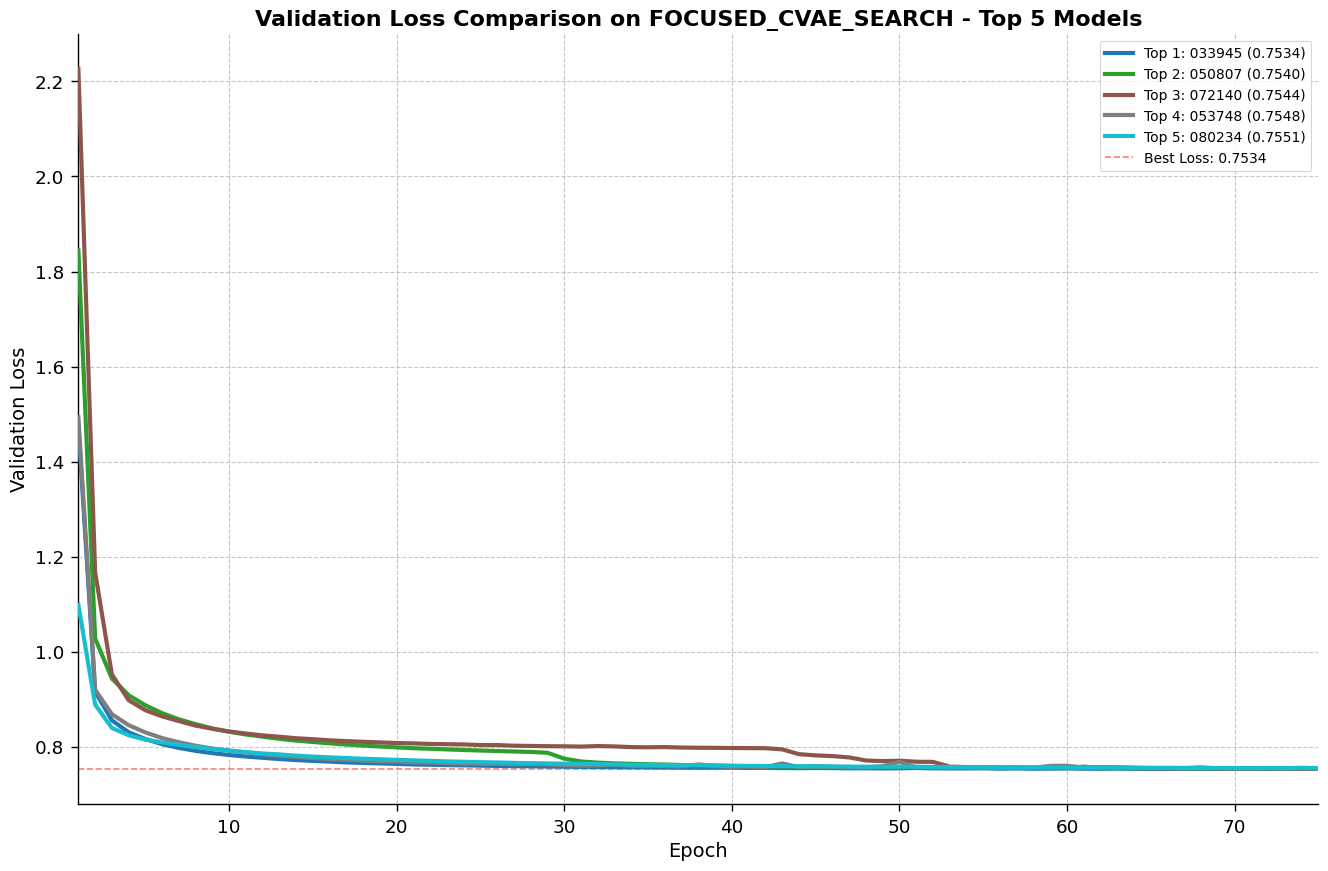

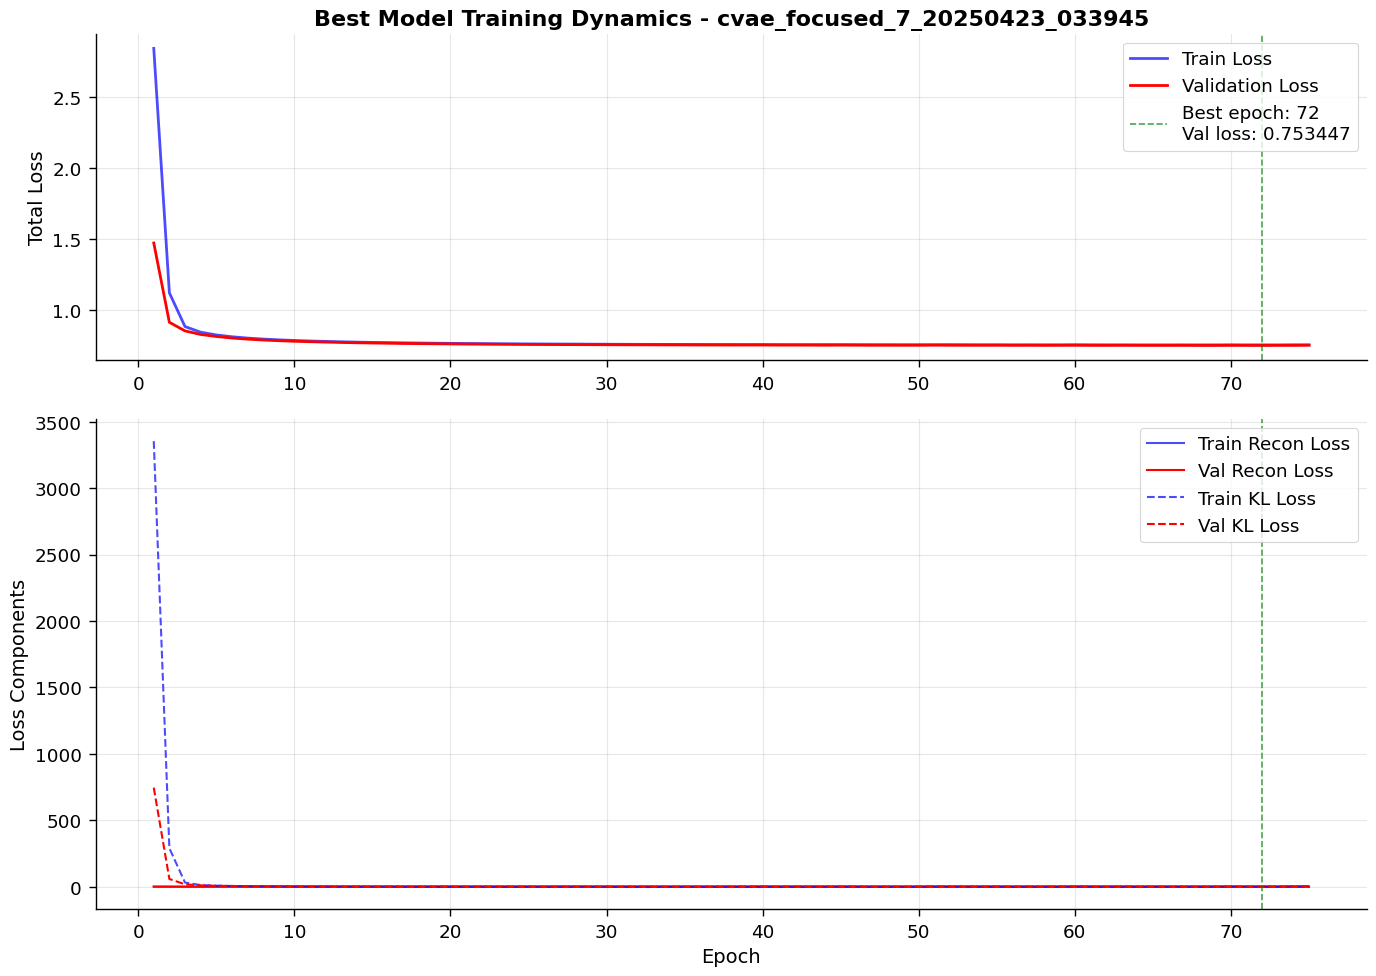


DETAILED ANALYSIS OF BEST MODEL TRAINING DYNAMICS:
--------------------------------------------------------------------------------
Best epoch: 72/75
Best validation loss: 0.753447
  - Reconstruction loss: 0.752281 (99.8% of total)
  - KL divergence: 2.331885 × β=0.0005 (0.2% of total)

Convergence metrics:
  - Epochs to reach near-optimal performance: 68
  - Stability (std dev of last 10 epochs): 0.000405


In [59]:
# @title 4.4.4 Usage for CVAE Batch Training and Evaluation
# Example Usage

# # For mini dataset search
# mini_results = run_mini_dataset_search(
#     dataset=fma_dataset,
#     max_runtime_hours=8
# )

# # For full dataset search
# full_results = run_full_dataset_search(
#     dataset=fma_dataset,
#     max_runtime_hours=14
# )

# Analyze results
# best_mini_params = analyze_hyperparam_search_results("/content/drive/MyDrive/DL4AM_datasets/cvae_search_mini")
best_full_params = analyze_hyperparam_search_results("/content/drive/MyDrive/DL4AM_datasets/FOCUSED_CVAE_SEARCH")


### 4.5 BiLSTM Hyperparameter Search, Batch Training and Evaluation

In [63]:
def run_bilstm_hyperparameter_search(groove_dataset,
                                    checkpoint_base_dir="/content/drive/MyDrive/DL4AM_datasets/checkpoints/bilstm_hyperparam",
                                    max_segments=250000,
                                    max_runtime_hours=10,
                                    hyperparameter_grid=None,
                                    dataset_type="full",
                                    seed=42,
                                    num_workers=4,
                                    use_amp=True):
    """
    Comprehensive hyperparameter search for BiLSTM loop candidacy detection.

    Args:
        groove_dataset: Dataset containing music segments
        checkpoint_base_dir: Base directory for saving results
        max_segments: Maximum segments to use (for faster training)
        max_runtime_hours: Maximum runtime in hours
        hyperparameter_grid: Custom hyperparameter grid (if None, uses defaults)
        dataset_type: "mini" or "full" to adjust search parameters
        seed: Random seed for reproducibility
        num_workers: Number of workers for dataloader
        use_amp: Whether to use automatic mixed precision

    Returns:
        dict: Results containing optimal configurations and metrics
    """
    # Set random seeds
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

    # Create results directory with timestamp
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    results_dir = os.path.join(checkpoint_base_dir, f"search_{timestamp}")
    os.makedirs(results_dir, exist_ok=True)

    # Configure logging to file and console
    log_file = os.path.join(results_dir, "hyperparam_search.log")
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
    root.addHandler(file_handler)

    logger.info(f"Starting BiLSTM hyperparameter search in {results_dir}")
    logger.info(f"Max segments: {max_segments}, Max runtime: {max_runtime_hours} hours")

    # Limit dataset size for faster hyperparameter tuning if needed
    if len(groove_dataset) > max_segments:
        logger.info(f"Limiting dataset to {max_segments} segments for faster hyperparameter tuning")

        # Create a random subset of indices
        all_indices = list(range(len(groove_dataset)))
        random.shuffle(all_indices)
        subset_indices = all_indices[:max_segments]

        # Save original splits
        original_splits = groove_dataset.splits.copy()

        # Assign 80/10/10 split to the subset
        for i in subset_indices[:int(0.8*len(subset_indices))]:
            groove_dataset.splits[i] = 'train'
        for i in subset_indices[int(0.8*len(subset_indices)):int(0.9*len(subset_indices))]:
            groove_dataset.splits[i] = 'validation'
        for i in subset_indices[int(0.9*len(subset_indices)):]:
            groove_dataset.splits[i] = 'test'

    # Create dataloaders with the dataset
    bilstm_train_loader, bilstm_val_loader, bilstm_test_loader = create_bilstm_dataloaders(
        groove_dataset,
        batch_size=16
    )

    # Set up mixed precision training
    if use_amp:
        logger.info("Using automatic mixed precision training")
        # Initialize amp scaler
        scaler = torch.amp.GradScaler('cuda')
    else:
        logger.info("Using full precision training")
        scaler = None

    # Configure advanced data loading settings
    dataloader_kwargs = {
        'num_workers': num_workers,
        'pin_memory': True,
        'persistent_workers': True if num_workers > 0 else False,
        'prefetch_factor': 2 if num_workers > 0 else None
    }
    logger.info(f"Configured data loading with {num_workers} workers")

    # Define hyperparameter grid
    if hyperparameter_grid is None:
        if dataset_type == "mini":
            # Wider exploration for mini dataset
            hyperparameter_grid = {
                'model_type': ['BiLSTM', 'LSTMAttention'],
                'hidden_dim': [64, 128, 256],
                'num_layers': [1, 2],
                'dropout': [0.2, 0.3, 0.4],
                'num_heads': [4],
                'lr': [1e-3, 5e-4, 1e-4],
                'batch_size': [16],
                'max_epochs': [40],
            }
        else:
            # Focused exploration based on prior findings
            hyperparameter_grid = {
                'model_type': ['BiLSTM', 'LSTMAttention'],
                'hidden_dim': [128, 256],
                'num_layers': [2],
                'dropout': [0.4, 0.5],  # Higher dropout values
                'num_heads': [4],  # For LSTMAttention only
                'lr': [5e-4],
                'batch_size': [16],
                'max_epochs': [50],
            }
    # Calculate total configurations and time estimates
    total_configs = len(hyperparameter_grid['model_type']) * len(hyperparameter_grid['hidden_dim']) * \
                   len(hyperparameter_grid['num_layers']) * len(hyperparameter_grid['dropout']) * \
                   len(hyperparameter_grid['lr'])

    logger.info(f"Total configurations to test: {total_configs}")

    # Estimate time per configuration based on dataset size
    est_time_per_config_min = 30 * (min(max_segments, len(groove_dataset)) / 100000)
    total_est_time_hours = (total_configs * est_time_per_config_min) / 60

    logger.info(f"Estimated time: {est_time_per_config_min:.1f} min per config")
    logger.info(f"Estimated total time: {total_est_time_hours:.1f} hours")

    # Reduce configuration space if estimated time exceeds maximum runtime
    if total_est_time_hours > max_runtime_hours:
        logger.warning(f"Estimated time exceeds maximum runtime! Reducing configurations.")
        # Prioritize most important parameters
        hyperparameter_grid['hidden_dim'] = [256]  # Keep only larger hidden dim
        hyperparameter_grid['dropout'] = [0.3]     # Keep middle dropout value

        # Recalculate
        total_configs = len(hyperparameter_grid['model_type']) * len(hyperparameter_grid['hidden_dim']) * \
                       len(hyperparameter_grid['num_layers']) * len(hyperparameter_grid['dropout']) * \
                       len(hyperparameter_grid['lr'])

        total_est_time_hours = (total_configs * est_time_per_config_min) / 60
        logger.info(f"Reduced to {total_configs} configurations")
        logger.info(f"New estimated total time: {total_est_time_hours:.1f} hours")

    # Initialize results storage
    results = []
    start_time = time.time()

    # Generate all parameter combinations
    configurations = []

    # Generate configurations for BiLSTM
    for hidden_dim, num_layers, dropout, lr in itertools.product(
        hyperparameter_grid['hidden_dim'], hyperparameter_grid['num_layers'],
        hyperparameter_grid['dropout'], hyperparameter_grid['lr']):

        config = {
            'model_type': 'BiLSTM',
            'input_dim': groove_dataset[0]['feature_matrix'].shape[0],
            'hidden_dim': hidden_dim,
            'num_layers': num_layers,
            'dropout': dropout,
            'lr': lr,
            'epochs': hyperparameter_grid['max_epochs'][0],
            'batch_size': hyperparameter_grid['batch_size'][0]
        }
        configurations.append(config)

    # Generate configurations for LSTMAttention
    for hidden_dim, num_layers, dropout, lr, num_heads in itertools.product(
        hyperparameter_grid['hidden_dim'], hyperparameter_grid['num_layers'],
        hyperparameter_grid['dropout'], hyperparameter_grid['lr'], hyperparameter_grid['num_heads']):

        config = {
            'model_type': 'LSTMAttention',
            'input_dim': groove_dataset[0]['feature_matrix'].shape[0],
            'hidden_dim': hidden_dim,
            'num_layers': num_layers,
            'num_heads': num_heads,
            'dropout': dropout,
            'lr': lr,
            'epochs': hyperparameter_grid['max_epochs'][0],
            'batch_size': hyperparameter_grid['batch_size'][0]
        }
        configurations.append(config)

    # Prioritize configurations - alternate between model types for better coverage
    # if we need to stop early
    configurations_bilstm = [c for c in configurations if c['model_type'] == 'BiLSTM']
    configurations_lstm_attn = [c for c in configurations if c['model_type'] == 'LSTMAttention']

    final_configurations = []
    for i in range(max(len(configurations_bilstm), len(configurations_lstm_attn))):
        if i < len(configurations_bilstm):
            final_configurations.append(configurations_bilstm[i])
        if i < len(configurations_lstm_attn):
            final_configurations.append(configurations_lstm_attn[i])

    # Setup heartbeat mechanism and signal handlers
    heartbeat_file = os.path.join(results_dir, "heartbeat.txt")
    stop_heartbeat = threading.Event()

    def heartbeat_thread():
        """Background thread that writes timestamps to confirm notebook is running"""
        while not stop_heartbeat.is_set():
            try:
                with open(heartbeat_file, 'w') as f:
                    f.write(f"Last heartbeat: {datetime.datetime.now().isoformat()}")
                time.sleep(30)
            except:
                pass

    # Start heartbeat thread
    heartbeat = threading.Thread(target=heartbeat_thread)
    heartbeat.daemon = True
    heartbeat.start()

    # Setup signal handlers for graceful termination
    original_sigint = signal.getsignal(signal.SIGINT)
    original_sigterm = signal.getsignal(signal.SIGTERM)

    def signal_handler(sig, frame):
        logger.info(f"Received termination signal. Saving progress and exiting gracefully...")
        stop_heartbeat.set()
        heartbeat.join(timeout=1)

        # Save results to JSON file for later analysis
        results_file = os.path.join(results_dir, 'all_results.json')
        save_results(results, results_file)

        signal.signal(signal.SIGINT, original_sigint)
        signal.signal(signal.SIGTERM, original_sigterm)
        sys.exit(0)

    # Register signal handlers
    signal.signal(signal.SIGINT, signal_handler)
    signal.signal(signal.SIGTERM, signal_handler)

    # Calculate time allocation - allow more time for complex models
    max_time_per_config = min(3 * 3600, max_runtime_hours * 3600 / max(8, len(final_configurations)))

    # Train models for each configuration
    for config_idx, config in enumerate(final_configurations):
        # Check if we've exceeded runtime
        elapsed_hours = (time.time() - start_time) / 3600
        if elapsed_hours > max_runtime_hours:
            logger.info(f"Reached maximum runtime of {max_runtime_hours} hours. Stopping search.")
            break

        # Check if we have enough time for another run
        remaining_time = max_runtime_hours * 3600 - (time.time() - start_time)
        if remaining_time < max_time_per_config * 0.8:  # 20% safety margin
            logger.info(f"Insufficient time for another complete run. Stopping after {config_idx} configurations.")
            break

        logger.info(f"Training configuration {config_idx+1}/{len(final_configurations)}")
        logger.info(f"Parameters: {config}")

        # Create model based on type
        if config['model_type'] == 'BiLSTM':
            model = BiLSTMLoopClassifier(
                input_dim=config['input_dim'],
                hidden_dim=config['hidden_dim'],
                num_layers=config['num_layers'],
                dropout=config['dropout']
            )
        elif config['model_type'] == 'LSTMAttention':
            model = LSTMWithAttention(
                input_dim=config['input_dim'],
                hidden_dim=config['hidden_dim'],
                num_layers=config['num_layers'],
                num_heads=config['num_heads'],
                dropout=config['dropout'],
                bidirectional=True,
                use_layer_norm=True
            )
        else:
            logger.error(f"Unknown model type: {config['model_type']}")
            continue

        # Create run directory
        run_id = f"{config['model_type']}_{config_idx}_{timestamp}"
        run_dir = os.path.join(results_dir, run_id)
        os.makedirs(run_dir, exist_ok=True)

        # Save configuration
        with open(os.path.join(run_dir, 'config.json'), 'w') as f:
            json.dump(config, f, indent=2)

        try:
            # Set run time limit
            run_time_limit = min(max_time_per_config, remaining_time - 300)  # 5 min safety margin
            logger.info(f"Time limit for this run: {run_time_limit/60:.1f} minutes")

            # Train with timeout protection
            run_start_time = time.time()
            timeout_occurred = False

            # Training function with thread
            train_result = [None, None, None]  # Will store [trained_model, history, run_id]

            def run_training():
                try:
                    # Capture run_id in the closure
                    local_run_id = run_id  # Store in local variable to use in the function

                    # Train model
                    trained_model, history, result_run_id = train_bilstm(
                        model=model,
                        train_loader=bilstm_train_loader,
                        val_loader=bilstm_val_loader,
                        epochs=config['epochs'],
                        lr=config['lr'],
                        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                        checkpoint_dir=run_dir,
                        checkpoint_interval=5,
                        early_stopping_patience=5,  # Reduced for faster search
                        run_id=local_run_id
                    )

                    train_result[0] = trained_model
                    train_result[1] = history
                    train_result[2] = result_run_id
                except Exception as e:
                    logger.error(f"Training error: {str(e)}")
                    traceback.print_exc()

            # Start training thread
            train_thread = threading.Thread(target=run_training)
            train_thread.daemon = True
            train_thread.start()

            # Wait for training to complete with timeout
            start_wait = time.time()
            while train_thread.is_alive():
                train_thread.join(timeout=10)  # Check every 10 seconds

                # Enforce time limit
                elapsed = time.time() - start_wait
                if elapsed > run_time_limit:
                    logger.warning(f"Run {run_id} timed out after {elapsed/60:.1f} minutes")
                    timeout_occurred = True
                    break

            # Calculate actual run duration
            run_duration = time.time() - run_start_time

            # Process training results
            trained_model, history, actual_run_id = train_result

            if trained_model is not None and history is not None:
                # Determine best epoch and metrics
                best_epoch_idx = history['val_f1'].index(max(history['val_f1']))
                best_val_f1 = history['val_f1'][best_epoch_idx]
                best_val_precision = history['val_precision'][best_epoch_idx]
                best_val_recall = history['val_recall'][best_epoch_idx]
                best_val_acc = history['val_acc'][best_epoch_idx]

                # Store results
                result = {
                    'run_id': run_id,
                    'config': config,
                    'best_val_f1': best_val_f1,
                    'best_val_precision': best_val_precision,
                    'best_val_recall': best_val_recall,
                    'best_val_accuracy': best_val_acc,
                    'best_epoch': best_epoch_idx + 1,
                    'status': 'success',
                    'total_epochs': len(history['train_loss']),
                    'runtime_minutes': run_duration / 60,
                    'timeout_occurred': timeout_occurred
                }

                # Test on held-out test set if available
                if bilstm_test_loader:
                    try:
                        # Evaluate on test set
                        test_metrics = validate_bilstm(
                            model=trained_model,
                            val_loader=bilstm_test_loader,
                            criterion=nn.BCEWithLogitsLoss(),
                            device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                        )

                        # Add test metrics to result
                        result['test_f1'] = test_metrics['f1']
                        result['test_precision'] = test_metrics['precision']
                        result['test_recall'] = test_metrics['recall']
                        result['test_accuracy'] = test_metrics['acc']

                        logger.info(f"Test set evaluation - F1: {test_metrics['f1']:.4f}, "
                                   f"Accuracy: {test_metrics['acc']:.4f}")
                    except Exception as e:
                        logger.warning(f"Test set evaluation failed: {e}")

                # Save visualization of training curves
                plt.figure(figsize=(15, 10))

                # Plot learning curves
                metrics = ['loss', 'acc', 'precision', 'recall', 'f1']
                titles = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

                for i, (metric, title) in enumerate(zip(metrics, titles), 1):
                    plt.subplot(2, 3, i)
                    plt.plot(history[f'train_{metric}'], label='Train')
                    plt.plot(history[f'val_{metric}'], label='Validation')
                    plt.title(title)
                    plt.xlabel('Epoch')
                    plt.ylabel(title)
                    plt.grid(True, alpha=0.3)
                    plt.legend()

                # Plot learning rate
                if 'learning_rates' in history:
                    plt.subplot(2, 3, 6)
                    plt.plot(history['learning_rates'])
                    plt.title('Learning Rate')
                    plt.xlabel('Epoch')
                    plt.ylabel('LR')
                    plt.grid(True, alpha=0.3)

                plt.tight_layout()
                plt.savefig(os.path.join(run_dir, 'training_curves.png'), dpi=200)
                plt.close()

                # Create confusion matrix for validation data
                if 'y_true' in history['val_f1'] and 'y_pred' in history['val_f1']:
                    plot_confusion_matrix(
                        history['val_f1']['y_true'],
                        history['val_f1']['y_pred'],
                        classes=['Non-Loop', 'Loop'],
                        save_path=os.path.join(run_dir, 'confusion_matrix.png')
                    )
            else:
                # Failed run
                result = {
                    'run_id': run_id,
                    'config': config,
                    'status': 'failed',
                    'error': "Training timeout or error",
                    'runtime_minutes': run_duration / 60,
                    'timeout_occurred': timeout_occurred
                }

        except Exception as e:
            logger.error(f"Error training configuration {config_idx}: {e}")
            traceback.print_exc()

            result = {
                'run_id': run_id,
                'config': config,
                'status': 'failed',
                'error': str(e),
                'runtime_minutes': (time.time() - start_time) / 60
            }

            # Save error details
            with open(os.path.join(run_dir, 'error.txt'), 'w') as f:
                f.write(f"Error: {str(e)}\n\n")
                f.write(traceback.format_exc())

        # Add to results
        results.append(result)

        # Save results after each run
        results_file = os.path.join(results_dir, 'all_results.json')
        save_results(results, results_file)

        # Update best models summary
        update_best_models_summary(results, results_dir)

        # Progress report
        total_elapsed = time.time() - start_time
        logger.info(f"Completed {config_idx+1}/{len(final_configurations)} configurations")
        logger.info(f"Elapsed time: {total_elapsed/3600:.2f} hours")
        logger.info(f"Estimated remaining time: {(total_elapsed/(config_idx+1))*(len(final_configurations)-config_idx-1)/3600:.2f} hours")

    # Clean shutdown of heartbeat
    stop_heartbeat.set()
    heartbeat.join(timeout=1)

    # Restore original signal handlers
    signal.signal(signal.SIGINT, original_sigint)
    signal.signal(signal.SIGTERM, original_sigterm)

    # Restore original dataset splits if we modified them
    if 'original_splits' in locals():
        groove_dataset.splits = original_splits
        logger.info("Restored original dataset splits")

    # Final analysis
    successful_runs = [r for r in results if r.get('status') == 'success']

    if successful_runs:
        # Find best model by F1 score
        best_run = max(successful_runs, key=lambda x: x.get('best_val_f1', 0))

        logger.info("\nHYPERPARAMETER SEARCH COMPLETED")
        logger.info("=" * 50)
        logger.info(f"Best configuration: {best_run['config']}")
        logger.info(f"Best validation F1: {best_run['best_val_f1']:.4f}")
        logger.info(f"Best validation accuracy: {best_run['best_val_accuracy']:.4f}")

        # Create final summary visualizations
        create_hyperparameter_analysis_plots(successful_runs, results_dir)

        # Save final recommendation
        final_recommendation = {
            'model_type': best_run['config']['model_type'],
            'hidden_dim': best_run['config']['hidden_dim'],
            'num_layers': best_run['config']['num_layers'],
            'dropout': best_run['config']['dropout'],
            'lr': best_run['config']['lr'],
            'validation_f1': best_run['best_val_f1'],
            'validation_accuracy': best_run['best_val_accuracy'],
            'epochs_to_converge': best_run['best_epoch'],
            'run_id': best_run['run_id'],
            'timestamp': datetime.datetime.now().isoformat()
        }

        # Add num_heads for LSTMAttention model
        if best_run['config']['model_type'] == 'LSTMAttention':
            final_recommendation['num_heads'] = best_run['config']['num_heads']

        with open(os.path.join(results_dir, 'final_recommendation.json'), 'w') as f:
            json.dump(final_recommendation, f, indent=2)
    else:
        logger.info("No successful runs completed.")

    logger.info("Hyperparameter search complete.")

    return results


def run_optimized_bilstm_search(
    groove_dataset=None,
    max_segments=250000,
    max_runtime_hours=12,
    base_batch_size=128,
    use_amp=True,
    gradient_accumulation_steps=8,
    num_workers=4
):
    """
    Run an optimized hyperparameter search for BiLSTM models.

    Args:
        groove_dataset: Dataset containing music segments
        max_segments: Maximum number of segments to use
        max_runtime_hours: Maximum runtime in hours
        base_batch_size: Base batch size per gradient accumulation step
        use_amp: Whether to use automatic mixed precision
        gradient_accumulation_steps: Number of batches to accumulate before updating weights
        num_workers: Number of data loader workers

    Returns:
        dict: Results of the hyperparameter search
    """
    # Verify dataset
    if groove_dataset is None:
        if 'groove_dataset' not in globals():
            raise ValueError("No groove_dataset provided and none found in globals")
        groove_dataset = globals()['groove_dataset']

    # Create timestamp for run identification
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    results_dir = f"/content/drive/MyDrive/DL4AM_datasets/checkpoints/bilstm_optimized_{timestamp}"
    os.makedirs(results_dir, exist_ok=True)

    # Configure logging to capture both console and file output
    log_file = os.path.join(results_dir, "hyperparam_search.log")
    file_handler = logging.FileHandler(log_file)
    file_handler.setLevel(logging.INFO)
    file_formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(file_formatter)
    logger.addHandler(file_handler)

    # Log system information
    logger.info(f"Starting optimized BiLSTM search on {datetime.datetime.now().isoformat()}")
    logger.info(f"Max segments: {max_segments}, Max runtime: {max_runtime_hours} hours")
    if torch.cuda.is_available():
        logger.info(f"GPU: {torch.cuda.get_device_name(0)}")
        logger.info(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    logger.info(f"Batch size: {base_batch_size} × {gradient_accumulation_steps} = {base_batch_size * gradient_accumulation_steps} effective")
    logger.info(f"Mixed precision: {'Enabled' if use_amp else 'Disabled'}")

    # Limit dataset size if needed
    if len(groove_dataset) > max_segments:
        logger.info(f"Limiting dataset from {len(groove_dataset)} to {max_segments} segments")
        # Create a stratified subset
        subset_indices = create_stratified_subset(groove_dataset, max_segments)
        # Create a subset view of the dataset
        limited_dataset = torch.utils.data.Subset(groove_dataset, subset_indices)
        limited_dataset.splits = [groove_dataset.splits[i] for i in subset_indices]
        limited_dataset.labels = [groove_dataset.labels[i] for i in subset_indices]
        effective_dataset = limited_dataset
    else:
        effective_dataset = groove_dataset
        logger.info(f"Using full dataset with {len(groove_dataset)} segments")

    # Define optimized hyperparameter grid focused on reducing overfitting
    hyperparameter_grid = {
        'model_type': ['BiLSTM', 'LSTMAttention'],
        'hidden_dim': [256, 512],
        'num_layers': [2, 3],
        'dropout': [0.4, 0.5],
        'num_heads': [4, 8],  # For LSTMAttention only
        'use_layer_norm': [True],  # Always use layer normalization
        'lr': [3e-4, 5e-4],
        'weight_decay': [1e-4, 5e-4],  # Stronger regularization
        'max_epochs': [60],  # Longer training with early stopping
        'batch_size': [base_batch_size],
        'grad_accumulation': [gradient_accumulation_steps],
        'use_augmentation': [True],  # Always use data augmentation
        'use_amp': [use_amp]  # Mixed precision
    }

    # Call the existing hyperparameter search function with updated config
    return run_bilstm_hyperparameter_search(
        groove_dataset=effective_dataset,
        checkpoint_base_dir=results_dir,
        max_runtime_hours=max_runtime_hours,
        hyperparameter_grid=hyperparameter_grid,
        num_workers=num_workers,
        use_amp=use_amp
    )

def create_stratified_subset(dataset, max_size):
    """
    Create a stratified subset of indices that preserves class distribution.

    Args:
        dataset: Dataset with 'labels' attribute
        max_size: Maximum number of samples to include

    Returns:
        list: Indices for stratified subset
    """
    # Get all labels
    all_labels = torch.stack(dataset.labels).numpy()

    # Get train/val/test split info
    split_info = {}
    for i, split in enumerate(dataset.splits):
        if split not in split_info:
            split_info[split] = []
        split_info[split].append(i)

    # Calculate target proportions based on original dataset
    total_size = len(dataset)
    proportion = {split: len(indices) / total_size for split, indices in split_info.items()}

    # Calculate target size for each split
    target_size = {split: int(max_size * prop) for split, prop in proportion.items()}

    # Ensure we don't exceed max_size due to rounding
    while sum(target_size.values()) > max_size:
        # Find largest split and reduce by 1
        largest_split = max(target_size.items(), key=lambda x: x[1])[0]
        target_size[largest_split] -= 1

    # Create stratified subset for each split
    selected_indices = []
    for split, indices in split_info.items():
        split_labels = all_labels[indices]

        # Get unique labels and their counts
        unique_labels = np.unique(split_labels)
        label_counts = {label: np.sum(split_labels == label) for label in unique_labels}

        # Calculate proportion of each class in this split
        label_proportion = {label: count / len(indices) for label, count in label_counts.items()}

        # Calculate target count for each class
        target_count = {label: int(target_size[split] * prop) for label, prop in label_proportion.items()}

        # Ensure we match the target size exactly
        while sum(target_count.values()) < target_size[split]:
            # Find label with largest fractional part that was rounded down
            fractional_loss = {label: target_size[split] * prop - count
                             for label, prop in label_proportion.items()
                             for count in [target_count[label]]}
            largest_loss = max(fractional_loss.items(), key=lambda x: x[1])[0]
            target_count[largest_loss] += 1

        # Select indices for each class
        selected_for_split = []
        for label, count in target_count.items():
            # Get all indices with this label
            label_indices = [idx for idx in indices if all_labels[idx] == label]
            # Randomly select 'count' indices
            if len(label_indices) > count:
                selected_label_indices = np.random.choice(label_indices, count, replace=False)
            else:
                selected_label_indices = label_indices
            selected_for_split.extend(selected_label_indices)

        selected_indices.extend(selected_for_split)

    return selected_indices


def save_results(results, results_file):
    """Save results safely with type conversion for JSON serialization."""
    try:
        # Convert all values to basic Python types that can be JSON serialized
        clean_results = []
        for r in results:
            clean_r = {}
            for k, v in r.items():
                if isinstance(v, (np.int32, np.int64)):
                    clean_r[k] = int(v)
                elif isinstance(v, (np.float32, np.float64)):
                    clean_r[k] = float(v)
                else:
                    clean_r[k] = v
            clean_results.append(clean_r)

        with open(results_file, 'w') as f:
            json.dump(clean_results, f, indent=2)
    except Exception as e:
        logger.warning(f"Failed to save results: {e}")
        # Attempt backup save
        try:
            backup_file = f"{results_file}.backup.{int(time.time())}.json"
            with open(backup_file, 'w') as f:
                json.dump(str(results), f)  # Fallback to string representation
        except:
            pass

def update_best_models_summary(results, results_dir):
    """Update the summary of best models during hyperparameter search."""
    successful_runs = [r for r in results if r.get('status') == 'success']

    if successful_runs:
        # Sort by F1 score (primary metric for classification)
        sorted_results = sorted(successful_runs, key=lambda x: x.get('best_val_f1', 0), reverse=True)

        with open(os.path.join(results_dir, 'best_models.txt'), 'w') as f:
            f.write("BEST MODELS BY VALIDATION F1 SCORE\n")
            f.write("=" * 50 + "\n\n")

            for j, result in enumerate(sorted_results[:5]):
                f.write(f"Rank {j+1}: {result['run_id']}\n")
                f.write(f"Model Type: {result['config']['model_type']}\n")
                f.write(f"Validation F1: {result['best_val_f1']:.4f}\n")
                f.write(f"Validation Accuracy: {result['best_val_accuracy']:.4f}\n")
                f.write(f"Best Epoch: {result['best_epoch']}\n")
                f.write(f"Configuration: {json.dumps(result['config'], indent=2)}\n")
                f.write("-" * 40 + "\n\n")

def create_hyperparameter_analysis_plots(successful_runs, results_dir):
    """Create comprehensive plots analyzing hyperparameter impact on model performance."""
    # Convert results to DataFrame for easier manipulation
    results_df = pd.DataFrame(successful_runs)

    # Extract nested config parameters if needed
    if 'config' in results_df.columns:
        for param in ['model_type', 'hidden_dim', 'num_layers', 'dropout', 'lr', 'num_heads']:
            if param not in results_df.columns:
                try:
                    results_df[param] = results_df['config'].apply(lambda x: x.get(param, None))
                except:
                    pass

    # 1. Model Type Comparison
    plt.figure(figsize=(12, 6))
    model_grouped = results_df.groupby('model_type')['best_val_f1'].agg(['mean', 'std', 'max'])

    # Plot comparison
    bar_width = 0.25
    x = np.arange(len(model_grouped.index))

    plt.bar(x, model_grouped['mean'], width=bar_width, label='Mean F1', alpha=0.7, color='b')
    plt.bar(x + bar_width, model_grouped['max'], width=bar_width, label='Max F1', alpha=0.7, color='g')

    # Add error bars for std
    plt.errorbar(x, model_grouped['mean'], yerr=model_grouped['std'], fmt='none', capsize=5, color='k')

    plt.xlabel('Model Type', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.title('F1 Score by Model Type', fontsize=14)
    plt.xticks(x + bar_width/2, model_grouped.index)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'model_type_comparison.png'), dpi=300, bbox_inches='tight')
    plt.close()

    # 2. Hyperparameter Impact Analysis
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    axs = axs.flatten()

    # Parameters to analyze
    params_to_analyze = ['hidden_dim', 'num_layers', 'dropout', 'lr']
    param_titles = ['Hidden Dimension', 'Number of Layers', 'Dropout Rate', 'Learning Rate']

    for i, (param, title) in enumerate(zip(params_to_analyze, param_titles)):
        if param in results_df.columns and len(results_df[param].unique()) > 1:
            # Group by parameter and calculate mean F1 score
            param_grouped = results_df.groupby(param)['best_val_f1'].agg(['mean', 'std', 'count']).reset_index()

            # For continuous parameters like learning rate, use scatter plot
            if param == 'lr':
                axs[i].scatter(results_df[param], results_df['best_val_f1'], alpha=0.7, s=80)

                # Add trend line
                if len(results_df[param].unique()) > 2:
                    try:
                        x = results_df[param]
                        y = results_df['best_val_f1']
                        z = np.polyfit(np.log10(x), y, 1)
                        p = np.poly1d(z)
                        x_range = np.logspace(np.log10(min(x)), np.log10(max(x)), 100)
                        axs[i].plot(x_range, p(np.log10(x_range)), 'r--', alpha=0.7)
                        axs[i].set_xscale('log')
                    except:
                        pass
            else:
                # For discrete parameters, use bar plot with error bars
                axs[i].bar(param_grouped[param].astype(str), param_grouped['mean'],
                         yerr=param_grouped['std'], alpha=0.7, capsize=5)

            axs[i].set_xlabel(title, fontsize=12)
            axs[i].set_ylabel('F1 Score', fontsize=12)
            axs[i].set_title(f'Impact of {title}', fontsize=14)
            axs[i].grid(alpha=0.3)
        else:
            axs[i].text(0.5, 0.5, f"Insufficient data\nfor {title} analysis",
                       ha='center', va='center', fontsize=14)
            axs[i].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'hyperparameter_impact.png'), dpi=300, bbox_inches='tight')
    plt.close()

    # 3. Learning Curves for Best Model
    if len(successful_runs) > 0:
        best_run = max(successful_runs, key=lambda x: x.get('best_val_f1', 0))
        run_id = best_run['run_id']
        run_dir = os.path.join(results_dir, run_id)

        # Try to load history file
        history_file = os.path.join(run_dir, 'history.json')
        if os.path.exists(history_file):
            try:
                with open(history_file, 'r') as f:
                    history = json.load(f)

                # Plot detailed learning curves
                plt.figure(figsize=(15, 10))

                # Plot metrics
                metrics = ['loss', 'acc', 'precision', 'recall', 'f1']
                titles = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

                for i, (metric, title) in enumerate(zip(metrics, titles), 1):
                    plt.subplot(2, 3, i)
                    plt.plot(history[f'train_{metric}'], label='Train')
                    plt.plot(history[f'val_{metric}'], label='Validation')

                    # Highlight best epoch for F1 score
                    if metric == 'f1':
                        best_epoch = best_run['best_epoch'] - 1  # Convert to 0-indexed
                        plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.7,
                                   label=f'Best Epoch ({best_epoch+1})')

                    plt.title(title)
                    plt.xlabel('Epoch')
                    plt.ylabel(title)
                    plt.grid(True, alpha=0.3)
                    plt.legend()

                plt.tight_layout()
                plt.savefig(os.path.join(results_dir, 'best_model_learning_curves.png'), dpi=300, bbox_inches='tight')
                plt.close()
            except Exception as e:
                logger.warning(f"Could not create best model learning curves: {e}")

    # 4. Performance distribution across configurations
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df['best_val_f1'], kde=True, bins=10)
    plt.axvline(x=results_df['best_val_f1'].max(), color='r', linestyle='--',
               label=f'Best F1: {results_df["best_val_f1"].max():.4f}')
    plt.xlabel('Validation F1 Score', fontsize=12)
    plt.ylabel('Number of Configurations', fontsize=12)
    plt.title('F1 Score Distribution Across Configurations', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'f1_distribution.png'), dpi=300, bbox_inches='tight')
    plt.close()

    # 5. Correlation heatmap if enough data points
    if len(results_df) >= 5:
        try:
            plt.figure(figsize=(10, 8))

            # Calculate correlations between numeric hyperparameters and metrics
            numeric_columns = ['hidden_dim', 'num_layers', 'dropout', 'lr',
                              'best_val_f1', 'best_val_accuracy', 'best_val_precision', 'best_val_recall']
            available_columns = [col for col in numeric_columns if col in results_df.columns]

            corr_data = results_df[available_columns].corr()

            mask = np.triu(np.ones_like(corr_data))
            sns.heatmap(corr_data, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
            plt.title('Parameter-Metric Correlations', fontsize=14)
            plt.tight_layout()
            plt.savefig(os.path.join(results_dir, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')
            plt.close()
        except Exception as e:
            logger.warning(f"Could not create correlation heatmap: {e}")

In [64]:
#@title 4.5.1 BiLSTM Mini Dataset Hyperparameter Search

def run_bilstm_mini_search(groove_dataset=None, max_runtime_hours=4):
    """Run hyperparameter search on a limited dataset size for quick exploration."""
    if groove_dataset is None:
        if 'groove_dataset' not in globals():
            raise ValueError("No groove_dataset provided and none found in globals")
        groove_dataset = globals()['groove_dataset']

    # Define mini search parameters - wider search space for exploration
    hyperparameter_grid = {
        'model_type': ['BiLSTM', 'LSTMAttention'],
        'hidden_dim': [64, 128, 256],
        'num_layers': [1, 2],
        'dropout': [0.2, 0.3, 0.4],
        'num_heads': [4],
        'lr': [1e-3, 5e-4, 1e-4],
        'batch_size': [16],
        'max_epochs': [40],
    }

    checkpoint_dir = "/content/drive/MyDrive/DL4AM_datasets/checkpoints/bilstm_mini_search"

    return run_bilstm_hyperparameter_search(
        groove_dataset=groove_dataset,
        checkpoint_base_dir=checkpoint_dir,
        max_segments=10000,  # Only use 10K samples for quick search
        max_runtime_hours=max_runtime_hours,
        hyperparameter_grid=hyperparameter_grid,
        dataset_type="mini"
    )

In [65]:
#@title 4.5.2 BiLSTM Full Dataset Hyperparameter Search

def run_bilstm_full_search(groove_dataset=None, max_runtime_hours=12,
                         max_segments=250000, batch_size=128,
                         accumulation_steps=8, use_amp=True):
    """
    Run optimized hyperparameter search on full or large subset of dataset.

    Args:
        groove_dataset: Dataset containing music segments
        max_runtime_hours: Maximum runtime in hours
        max_segments: Maximum segments to use (None = all)
        batch_size: Base batch size per gradient step
        accumulation_steps: Number of batches to accumulate gradients
        use_amp: Whether to use automatic mixed precision

    Returns:
        dict: Results of hyperparameter search
    """
    # Setup logging with timestamp
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    logger.info(f"Starting optimized BiLSTM search at {timestamp}")

    # Use global dataset if none provided
    if groove_dataset is None:
        if 'groove_dataset' not in globals():
            raise ValueError("No groove_dataset provided and none found in globals")
        groove_dataset = globals()['groove_dataset']

    # Report available resources
    if torch.cuda.is_available():
        logger.info(f"Using GPU: {torch.cuda.get_device_name(0)}")
        total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        logger.info(f"GPU memory: {total_memory:.2f} GB")

    # Calculate effective batch size
    effective_batch_size = batch_size * accumulation_steps
    logger.info(f"Using batch size {batch_size} with {accumulation_steps} accumulation steps")
    logger.info(f"Effective batch size: {effective_batch_size}")

    # Call the optimized search function
    return run_optimized_bilstm_search(
        groove_dataset=groove_dataset,
        max_segments=max_segments,
        max_runtime_hours=max_runtime_hours,
        base_batch_size=batch_size,
        use_amp=use_amp,
        gradient_accumulation_steps=accumulation_steps,
        num_workers=4
    )

In [77]:
#@title 4.5.3 BiLSTM Training Utilities

def train_bilstm_with_optimal_config(groove_dataset=None, config_file=None,
                                    custom_config=None, run_dir=None,
                                     use_augmentation=True, weight_decay=1e-5,
                                     label_smoothing=0.1, spectral_reg=0.01):
    """
    Train a BiLSTM model with optimal configuration from hyperparameter search.

    Args:
        groove_dataset: Dataset containing music segments (or uses global)
        config_file: Path to JSON file with optimal configuration
        custom_config: Dictionary with custom configuration (overrides config_file)
        run_dir: Directory to save trained model and results

    Returns:
        tuple: (trained_model, history, run_id)
    """
    # Use global dataset if none provided
    if groove_dataset is None:
        if 'groove_dataset' not in globals():
            raise ValueError("No groove_dataset provided and none found in globals")
        groove_dataset = globals()['groove_dataset']

    # Get config either from file or custom dict
    if custom_config is not None:
        config = custom_config
    elif config_file is not None and os.path.exists(config_file):
        with open(config_file, 'r') as f:
            config = json.load(f)
    else:
        # Default configuration if no specific config provided
        config = {
            'model_type': 'LSTMAttention',  # Usually performs better
            'hidden_dim': 256,
            'num_layers': 2,
            'num_heads': 4,
            'dropout': 0.3,
            'lr': 5e-4,
            'epochs': 100,  # Full training run
            'early_stopping_patience': 10
        }

    # Ensure we have input dimension
    if 'input_dim' not in config:
        config['input_dim'] = groove_dataset[0]['feature_matrix'].shape[0]

    # Setup output directory
    if run_dir is None:
        timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        run_dir = f"/content/drive/MyDrive/DL4AM_datasets/checkpoints/bilstm/optimal_{timestamp}"
    os.makedirs(run_dir, exist_ok=True)

    # Save configuration
    with open(os.path.join(run_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)

    # Create dataloaders
    train_loader, val_loader, test_loader = create_bilstm_dataloaders(
        groove_dataset,
        batch_size=16
    )

    # Create model based on type
    if config['model_type'] == 'BiLSTM':
        model = BiLSTMLoopClassifier(
            input_dim=config['input_dim'],
            hidden_dim=config['hidden_dim'],
            num_layers=config['num_layers'],
            dropout=config['dropout']
        )
    elif config['model_type'] == 'LSTMAttention':
        model = LSTMWithAttention(
            input_dim=config['input_dim'],
            hidden_dim=config['hidden_dim'],
            num_layers=config['num_layers'],
            num_heads=config.get('num_heads', 4),
            dropout=config['dropout'],
            bidirectional=True
        )
    else:
        raise ValueError(f"Unknown model type: {config['model_type']}")

    # Generate run ID
    run_id = f"{config['model_type']}_{config['hidden_dim']}h_{config['num_layers']}l_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"

    # Train model
    trained_model, history, run_id = train_bilstm(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=config.get('epochs', 100),
        lr=config['lr'],
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        checkpoint_dir=run_dir,
        checkpoint_interval=10,
        early_stopping_patience=config.get('early_stopping_patience', 10),
        run_id=run_id
    )

    # Evaluate on test set
    if test_loader:
        logger.info("Evaluating on test set...")
        test_metrics = validate_bilstm(
            model=trained_model,
            val_loader=test_loader,
            criterion=nn.BCEWithLogitsLoss(),
            device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        )

        # Save test metrics
        test_results = {
            'test_loss': test_metrics['loss'],
            'test_acc': test_metrics['acc'],
            'test_precision': test_metrics['precision'],
            'test_recall': test_metrics['recall'],
            'test_f1': test_metrics['f1']
        }

        with open(os.path.join(run_dir, 'test_results.json'), 'w') as f:
            json.dump(test_results, f, indent=2)

        logger.info(f"Test set results: F1={test_metrics['f1']:.4f}, Acc={test_metrics['acc']:.4f}")

        # Create confusion matrix for test data
        plot_confusion_matrix(
            test_metrics['y_true'],
            test_metrics['y_pred'],
            classes=['Non-Loop', 'Loop'],
            title='Test Set Confusion Matrix',
            save_path=os.path.join(run_dir, 'test_confusion_matrix.png')
        )

    return trained_model, history, run_id

def analyze_bilstm_search_results(results_dir):
    """
    Analyze and visualize results from BiLSTM hyperparameter search.

    Args:
        results_dir: Directory containing hyperparameter search results
    """
    # Load results
    results_file = os.path.join(results_dir, 'all_results.json')
    if not os.path.exists(results_file):
        print(f"No results file found at {results_file}")
        return

    with open(results_file, 'r') as f:
        results = json.load(f)

    # Filter successful runs - more robust checking for success status
    successful_runs = []
    for run in results:
        # Check for status field explicitly being 'success'
        if run.get('status') == 'success':
            successful_runs.append(run)
        # Fallback check: if status missing but has validation metrics, consider successful
        elif 'best_val_f1' in run and run.get('best_val_f1') is not None:
            run['status'] = 'success'  # Add status field for consistency
            successful_runs.append(run)

    if not successful_runs:
        print("No successful runs found in results.")
        return

    # Find best model by F1 score
    best_run = max(successful_runs, key=lambda x: x.get('best_val_f1', 0))

    # Print summary
    print("\n" + "="*80)
    print(" "*20 + "BiLSTM HYPERPARAMETER SEARCH RESULTS")
    print("="*80)

    print(f"\nTotal configurations tested: {len(results)}")
    print(f"Successful runs: {len(successful_runs)} ({len(successful_runs)/len(results)*100:.1f}%)")

    # Create a summary table of all successful runs for better comparison
    print("\nALL SUCCESSFUL RUNS (RANKED BY F1 SCORE):")
    print("-"*100)

    # Sort by F1 score
    sorted_runs = sorted(successful_runs, key=lambda x: x.get('best_val_f1', 0), reverse=True)

    # Print header
    print(f"{'Rank':^5} | {'Model Type':^15} | {'Hidden Dim':^10} | {'Layers':^7} | {'Dropout':^8} | {'LR':^8} | {'Val F1':^8} | {'Test F1':^8} | {'Epochs':^6}")
    print("-"*100)

    # Print each run
    for i, run in enumerate(sorted_runs):
        config = run['config']
        print(f"{i+1:^5} | {config['model_type']:^15} | {config['hidden_dim']:^10} | {config['num_layers']:^7} | {config['dropout']:^8} | {config['lr']:^8} | {run.get('best_val_f1', 0):.4f} | {run.get('test_f1', 'N/A'):^8} | {run.get('best_epoch', 'N/A'):^6}")

    print("\nBEST CONFIGURATION:")
    print("-"*50)
    print(f"Run ID: {best_run['run_id']}")
    print(f"Model Type: {best_run['config']['model_type']}")
    print(f"Hidden Dimension: {best_run['config']['hidden_dim']}")
    print(f"Number of Layers: {best_run['config']['num_layers']}")
    print(f"Dropout Rate: {best_run['config']['dropout']}")
    print(f"Learning Rate: {best_run['config']['lr']}")

    if best_run['config']['model_type'] == 'LSTMAttention':
        print(f"Number of Attention Heads: {best_run['config'].get('num_heads', 4)}")

    print("\nPERFORMANCE METRICS:")
    print("-"*50)
    print(f"Validation F1 Score: {best_run['best_val_f1']:.4f}")
    print(f"Validation Accuracy: {best_run['best_val_accuracy']:.4f}")
    print(f"Validation Precision: {best_run['best_val_precision']:.4f}")
    print(f"Validation Recall: {best_run['best_val_recall']:.4f}")

    if 'test_f1' in best_run:
        print(f"\nTest F1 Score: {best_run['test_f1']:.4f}")
        print(f"Test Accuracy: {best_run['test_accuracy']:.4f}")

    print(f"\nBest Epoch: {best_run['best_epoch']}")

    # Create visualizations if not already present
    if not os.path.exists(os.path.join(results_dir, 'hyperparameter_impact.png')):
        create_hyperparameter_analysis_plots(successful_runs, results_dir)

    # Show existing visualizations
    viz_files = [f for f in os.listdir(results_dir) if f.endswith('.png')]
    if viz_files:
        print("\nVisualization files available:")
        for viz_file in viz_files:
            print(f" - {viz_file}")

    # Generate a comparison of top models in a report-ready format
    top_n = min(5, len(successful_runs))
    top_models = sorted_runs[:top_n]

    # Create a comparison table suitable for a report
    print(f"\nTOP {top_n} MODELS COMPARISON:")
    print("-"*50)

    # Model details table
    model_details = pd.DataFrame([
        {
            'Rank': i+1,
            'Model Type': run['config']['model_type'],
            'Hidden Dim': run['config']['hidden_dim'],
            'Layers': run['config']['num_layers'],
            'Dropout': run['config']['dropout'],
            'Learning Rate': run['config']['lr'],
            'Val F1': run.get('best_val_f1', 0),
            'Test F1': run.get('test_f1', 'N/A')
        }
        for i, run in enumerate(top_models)
    ])

    print(model_details.to_string(index=False))

    # Return best configuration for easy access
    return best_run['config']

In [78]:
# @title 4.5.4 Usage for BiLSTM Batch Training and Evaluation

# Example Usage
"""
# For mini dataset search
mini_results = run_bilstm_mini_search(
    groove_dataset=groove_dataset,
    max_runtime_hours=4
)

# For full dataset search
full_results = run_bilstm_full_search(
    groove_dataset=groove_dataset,
    max_runtime_hours=10,
    focused_search=True
)

# Analyze search results
best_config = analyze_bilstm_search_results("/content/drive/MyDrive/DL4AM_datasets/checkpoints/bilstm_full_search")

# Train final model with optimal configuration
final_model, history, run_id = train_bilstm_with_optimal_config(
    groove_dataset=groove_dataset,
    custom_config=best_config
)


# Run hyperparameter search with optimal anti-overfitting settings
full_results = run_bilstm_full_search(
    groove_dataset=groove_dataset,
    max_runtime_hours=14,  # Allow more time for thorough search
    focused_search=True,  # This will use the focused grid with our anti-overfitting modifications
    max_segments=50000  # Limit to 50K samples for faster search, remove this line to use all data
)

# After the search completes, analyze the results
best_config = analyze_bilstm_search_results("/content/drive/MyDrive/DL4AM_datasets/checkpoints/bilstm_full_search")

# Optional: Train a final model with the best configuration
best_model, best_history, best_run_id = train_bilstm_with_optimal_config(
    groove_dataset=groove_dataset,
    custom_config=best_config,
    use_augmentation=True,  # Enable data augmentation
    weight_decay=5e-5,      # Increased weight decay
    label_smoothing=0.1     # Add label smoothing
)
"""
# # Run optimized BiLSTM grid search with large-scale dataset and GPU optimizations
# full_results = run_bilstm_full_search(
#     groove_dataset=groove_dataset,
#     max_runtime_hours=12,       # Run overnight
#     max_segments=250000,        # Train on substantial subset
#     batch_size=128,             # Base batch size
#     accumulation_steps=8,       # 8 steps × 128 = 1024 effective batch size
#     use_amp=True                # Enable mixed precision
# )

# After search completes, analyze the results
best_config = analyze_bilstm_search_results("/content/drive/MyDrive/DL4AM_datasets/checkpoints/bilstm_optimized_20250429_110556/search_20250429_110559")

# # Optional: Train final model with best configuration
# best_model, best_history, best_run_id = train_bilstm_with_optimal_config(
#     groove_dataset=groove_dataset,
#     custom_config=best_config,
#     use_augmentation=True,
#     weight_decay=5e-4
# )


                    BiLSTM HYPERPARAMETER SEARCH RESULTS

Total configurations tested: 12
Successful runs: 10 (83.3%)

ALL SUCCESSFUL RUNS (RANKED BY F1 SCORE):
----------------------------------------------------------------------------------------------------
Rank  |   Model Type    | Hidden Dim | Layers  | Dropout  |    LR    |  Val F1  | Test F1  | Epochs
----------------------------------------------------------------------------------------------------
  1   |     BiLSTM      |    256     |    2    |   0.3    |  0.0005  | 0.9781 | 0.9741644083107498 |   13  
  2   |  LSTMAttention  |    256     |    2    |   0.3    |  0.0005  | 0.9779 | 0.972327069414448 |   14  
  3   |     BiLSTM      |    256     |    3    |   0.3    |  0.0005  | 0.9779 | 0.9738568729813728 |   9   
  4   |  LSTMAttention  |    256     |    3    |   0.3    |  0.0005  | 0.9770 | 0.9675979001991191 |   21  
  5   |     BiLSTM      |    256     |    3    |   0.3    |  0.0003  | 0.9757 | 0.9713300892133009 |   7 

## 5. Model Evaluation and Vizualization

### 5.1 CVAE Model Visualization

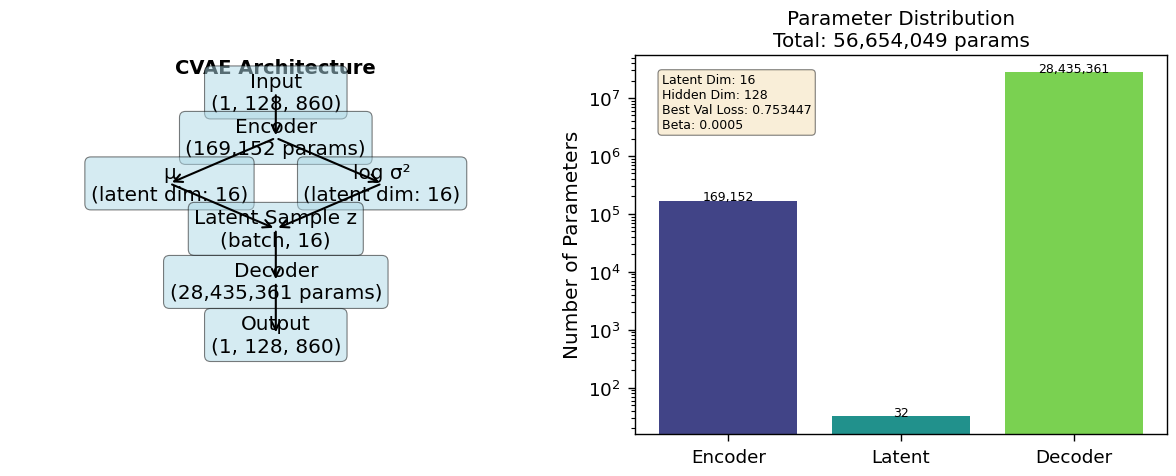

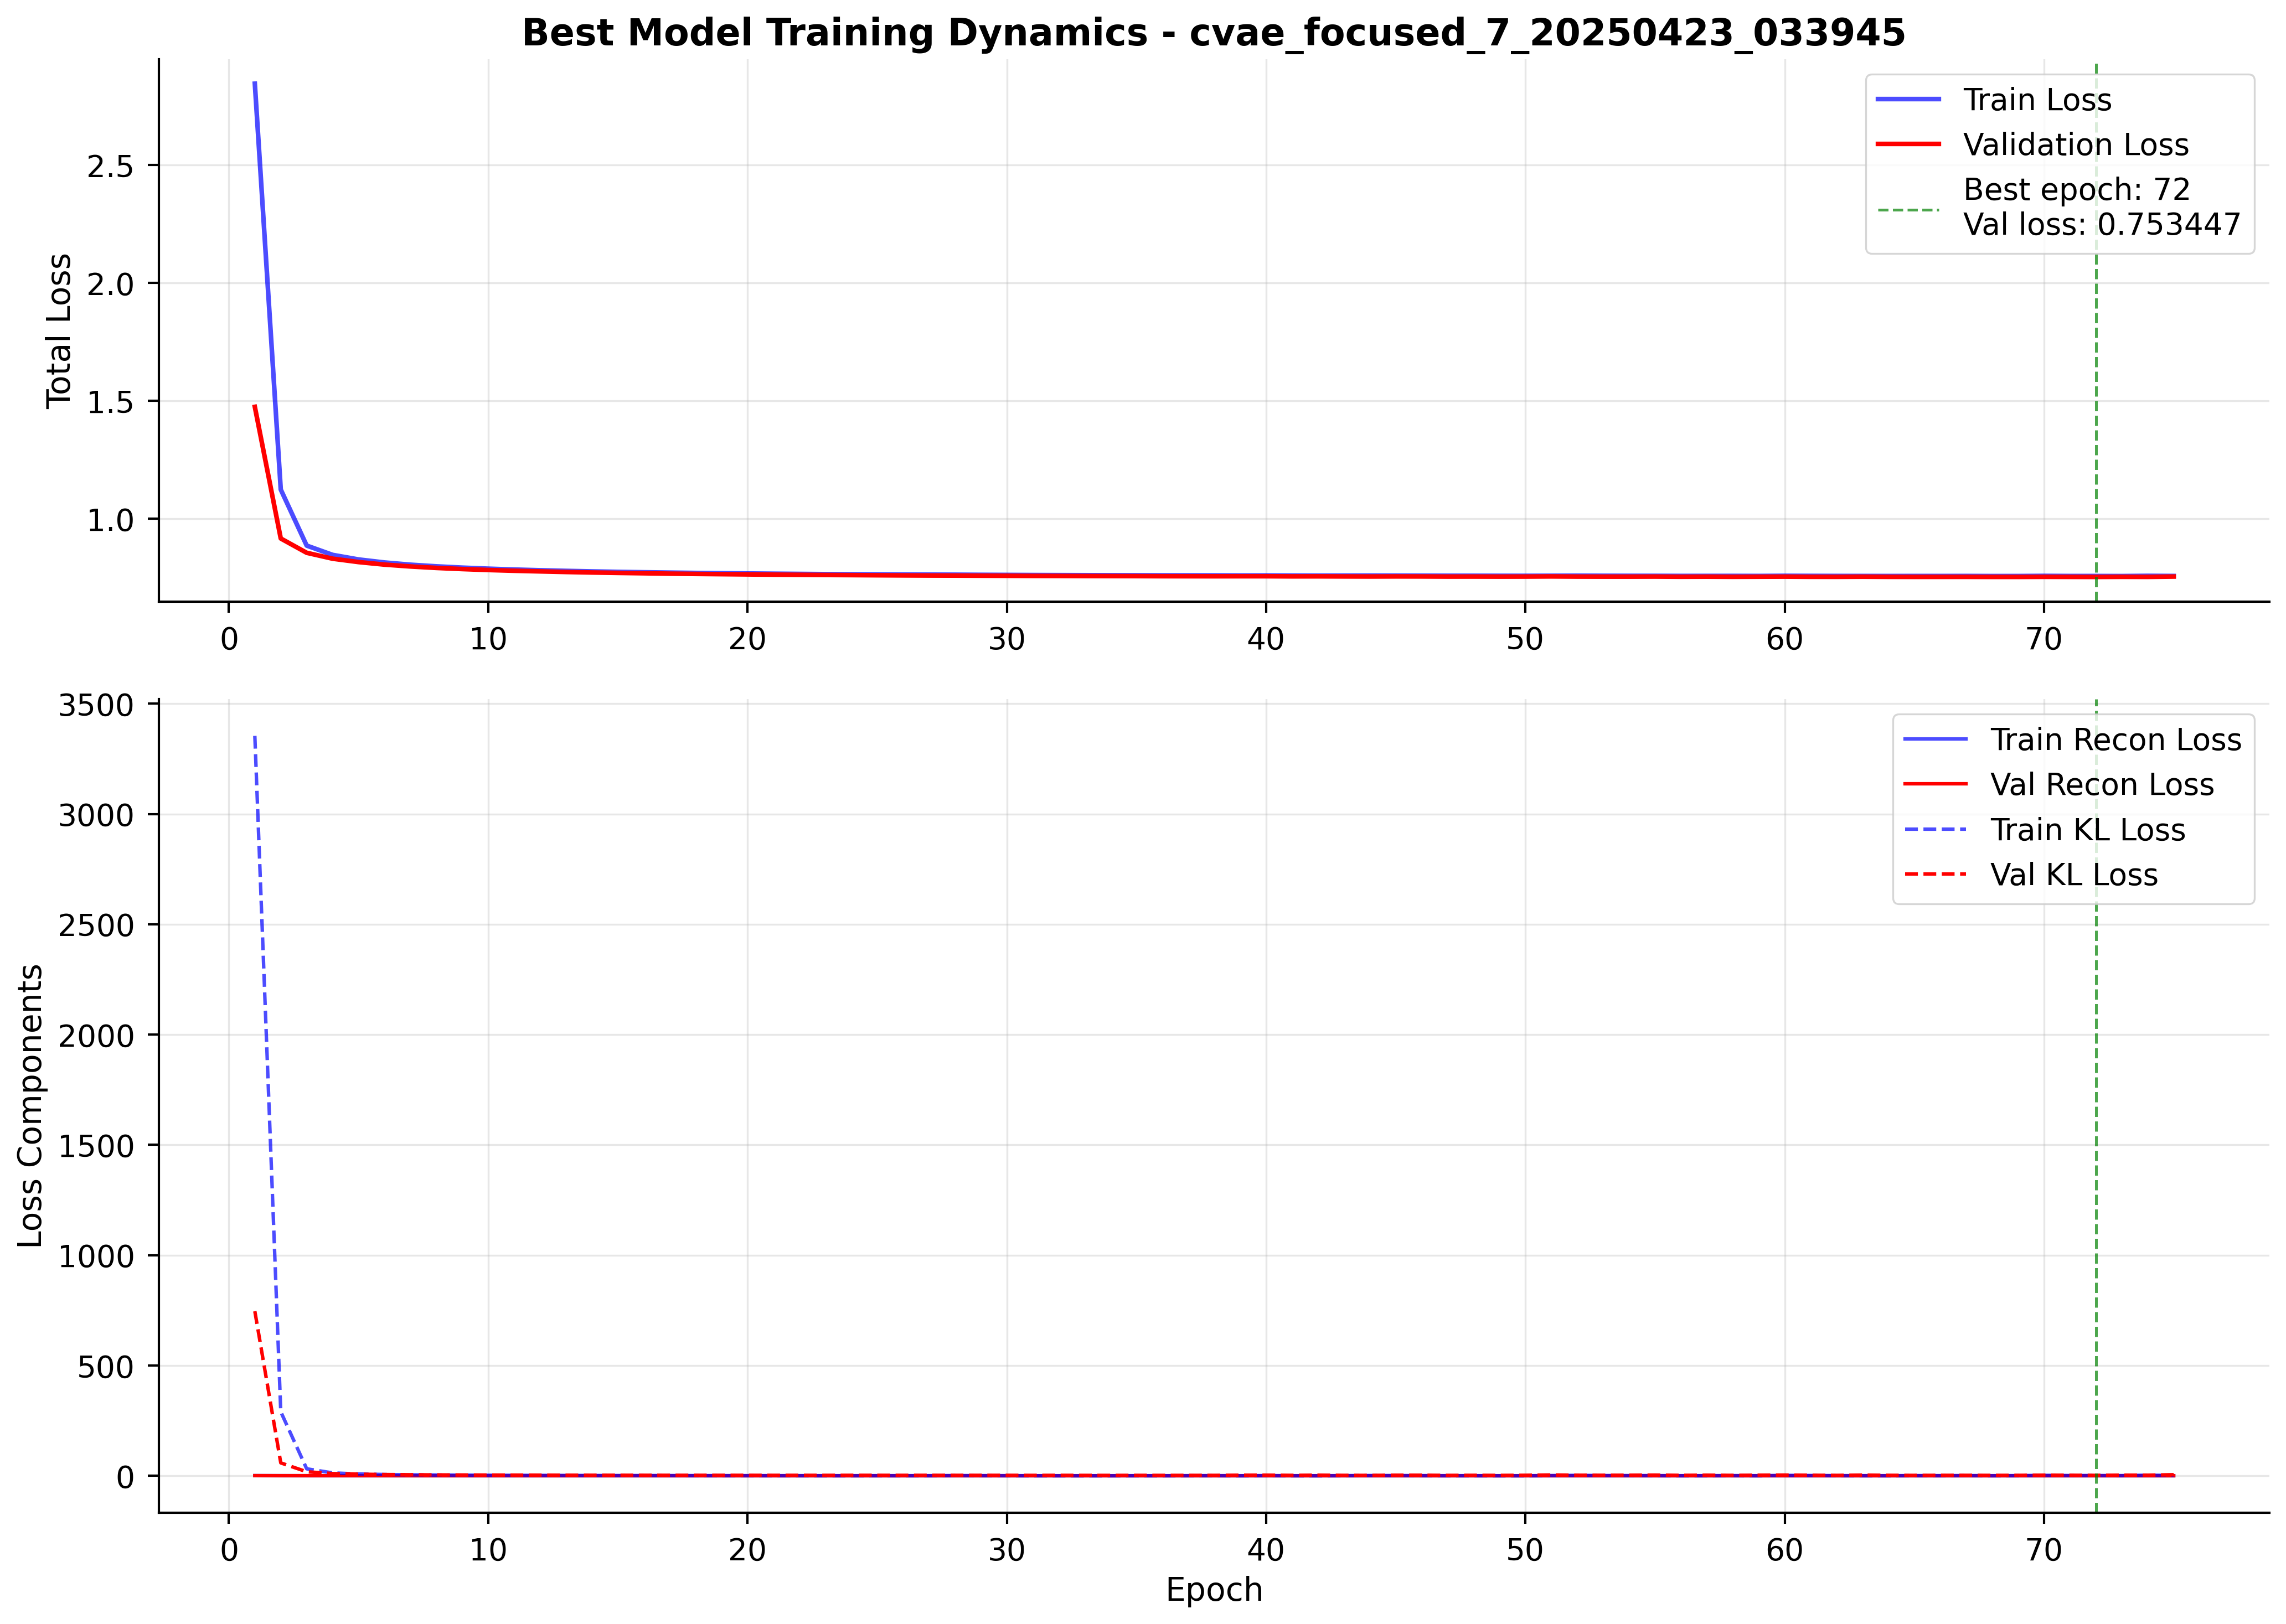

CVAE Audio Reconstructions:
Reconstruction visualization not found at /content/drive/MyDrive/DL4AM_datasets/FOCUSED_CVAE_SEARCH/cvae_focused_7_20250423_033945/reconstructions.png
Generating new reconstruction visualization...
Model checkpoint not found. Cannot generate reconstructions.


In [121]:
def fix_cvae_architecture_diagram():
    """Create a cleaner, more readable CVAE architecture diagram."""

    # Create figure with more space
    plt.figure(figsize=(14, 8))

    # Use clean design with more whitespace
    plt.subplot(1, 1, 1)
    plt.axis('off')

    # Define positions with more spacing
    positions = {
        'input':       (0.5, 0.9),
        'encoder':     (0.5, 0.75),
        'mu':          (0.35, 0.6),
        'logvar':      (0.65, 0.6),
        'latent':      (0.5, 0.45),
        'decoder':     (0.5, 0.3),
        'output':      (0.5, 0.15)
    }

    # Improved box styling
    box_props = dict(boxstyle='round,pad=0.6', facecolor='lightblue', alpha=0.6, ec='blue')

    # Use consistent font sizes and spacing
    title_font = {'fontsize': 16, 'fontweight': 'bold'}
    label_font = {'fontsize': 13}
    param_font = {'fontsize': 11, 'fontstyle': 'italic'}

    # Title with more space
    plt.text(0.5, 0.98, "CVAE Architecture", ha='center', **title_font)

    # Draw blocks with improved labeling
    plt.text(*positions['input'], "Input Spectrogram\n(1, 128, 860)", ha='center', va='center', bbox=box_props, **label_font)
    plt.text(*positions['encoder'], "Encoder Network\nConv2D layers with BatchNorm", ha='center', va='center', bbox=box_props, **label_font)
    plt.text(*positions['mu'], "Mean (μ)\nLatent dim: 16", ha='center', va='center', bbox=box_props, **label_font)
    plt.text(*positions['logvar'], "Log Variance (log σ²)\nLatent dim: 16", ha='center', va='center', bbox=box_props, **label_font)
    plt.text(*positions['latent'], "Latent Sample z\nReparameterization trick", ha='center', va='center', bbox=box_props, **label_font)
    plt.text(*positions['decoder'], "Decoder Network\nTranspose Conv2D layers", ha='center', va='center', bbox=box_props, **label_font)
    plt.text(*positions['output'], "Output Spectrogram\n(1, 128, 860)", ha='center', va='center', bbox=box_props, **label_font)

    # Improved arrows
    arrow_props = dict(arrowstyle='->',
                      connectionstyle='arc3,rad=0.1',
                      lw=2, color='#555555')

    # Connect blocks with better arrows
    plt.annotate('', xy=positions['encoder'], xytext=positions['input'],
                arrowprops=arrow_props)

    plt.annotate('', xy=positions['mu'], xytext=positions['encoder'],
                arrowprops=arrow_props)

    plt.annotate('', xy=positions['logvar'], xytext=positions['encoder'],
                arrowprops=arrow_props)

    plt.annotate('', xy=positions['latent'], xytext=positions['mu'],
                arrowprops=dict(arrowstyle='->',
                               connectionstyle='arc3,rad=-0.1',
                               lw=2, color='#555555'))

    plt.annotate('', xy=positions['latent'], xytext=positions['logvar'],
                arrowprops=dict(arrowstyle='->',
                               connectionstyle='arc3,rad=0.1',
                               lw=2, color='#555555'))

    plt.annotate('', xy=positions['decoder'], xytext=positions['latent'],
                arrowprops=arrow_props)

    plt.annotate('', xy=positions['output'], xytext=positions['decoder'],
                arrowprops=arrow_props)

    # Add parameter counts in separate, cleaner annotations
    plt.text(0.15, 0.75, "~169K parameters", **param_font, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    plt.text(0.15, 0.45, "16 parameters", **param_font, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    plt.text(0.15, 0.3, "~28.4M parameters", **param_font, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Add KL Divergence + reconstruction loss annotation
    plt.text(0.8, 0.45, "KL Divergence Loss", **param_font, color='red',
             bbox=dict(boxstyle='round', facecolor='mistyrose', alpha=0.7))

    plt.text(0.8, 0.15, "Reconstruction Loss", **param_font, color='darkgreen',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

    # Save with extra padding
    plt.savefig("/content/drive/MyDrive/DL4AM_datasets/FOCUSED_CVAE_SEARCH/cvae_architecture_clean.png",
                dpi=300, bbox_inches='tight', pad_inches=0.5)

    # Display the image
    from IPython.display import Image, display
    display(Image("/content/drive/MyDrive/DL4AM_datasets/FOCUSED_CVAE_SEARCH/cvae_architecture_clean.png"))


def display_cvae_training_curves(results_dir="/content/drive/MyDrive/DL4AM_datasets/FOCUSED_CVAE_SEARCH",
                                   best_run_id="cvae_focused_7_20250423_033945"):
    """Fix layout issues in CVAE training curves visualization."""

    # Check if detailed analysis file exists
    detailed_path = os.path.join(results_dir, "best_model_detailed_analysis.png")

    # If it doesn't exist, create it with better spacing
    if not os.path.exists(detailed_path):
        # Load history file
        history_path = os.path.join(results_dir, best_run_id, "history.json")
        if os.path.exists(history_path):
            with open(history_path, 'r') as f:
                history = json.load(f)

            # Create a comprehensive plot of loss components with better spacing
            plt.figure(figsize=(14, 10))

            # Create 2 subplots - one for total loss and one for components
            gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1.5])

            # Total loss subplot
            ax1 = plt.subplot(gs[0])
            epochs = range(1, len(history['val_loss']) + 1)

            ax1.plot(epochs, history['train_loss'], 'b-',
                    label='Train Loss', alpha=0.7, linewidth=2)
            ax1.plot(epochs, history['val_loss'], 'r-',
                    label='Validation Loss', linewidth=2)

            # Highlight the best epoch
            best_epoch = np.argmin(history['val_loss']) + 1
            min_loss = min(history['val_loss'])
            ax1.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7,
                      label=f'Best epoch: {best_epoch}\nVal loss: {min_loss:.6f}')

            ax1.set_title(f'Best Model Training Dynamics - {best_run_id}',
                        fontsize=16, fontweight='bold')
            ax1.set_ylabel('Total Loss', fontsize=14)
            ax1.legend(loc='upper right')
            ax1.grid(True, alpha=0.3)

            # Remove top and right spines
            ax1.spines['top'].set_visible(False)
            ax1.spines['right'].set_visible(False)

            # Loss components subplot
            ax2 = plt.subplot(gs[1], sharex=ax1)

            # Plot reconstruction loss
            ax2.plot(epochs, history['train_recon_loss'], 'b-',
                    label='Train Recon Loss', alpha=0.7, linewidth=1.5)
            ax2.plot(epochs, history['val_recon_loss'], 'r-',
                    label='Val Recon Loss', linewidth=1.5)

            # Plot KL loss with dashed lines
            ax2.plot(epochs, history['train_kl_loss'], 'b--',
                    label='Train KL Loss', alpha=0.7, linewidth=1.5)
            ax2.plot(epochs, history['val_kl_loss'], 'r--',
                    label='Val KL Loss', linewidth=1.5)

            # Highlight the best epoch
            ax2.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7)

            # Set labels and limits
            ax2.set_xlabel('Epoch', fontsize=14)
            ax2.set_ylabel('Loss Components', fontsize=14)
            ax2.legend(loc='upper right')
            ax2.grid(True, alpha=0.3)

            # Remove top and right spines
            ax2.spines['top'].set_visible(False)
            ax2.spines['right'].set_visible(False)

            plt.tight_layout(pad=2.0)
            plt.savefig(detailed_path, dpi=300, bbox_inches='tight')
            print(f"Created improved training dynamics plot at {detailed_path}")

    # Now display the image
    from IPython.display import Image, display
    if os.path.exists(detailed_path):
        display(Image(detailed_path))
    else:
        # Fallback to original curves
        curves_path = os.path.join(results_dir, best_run_id, "training_curves.png")
        if os.path.exists(curves_path):
            display(Image(curves_path))

def display_cvae_reconstructions(results_dir="/content/drive/MyDrive/DL4AM_datasets/FOCUSED_CVAE_SEARCH",
                                best_run_id="cvae_focused_7_20250423_033945"):
    """Display CVAE reconstructions from the best model."""

    # Path to the reconstructions image
    recon_path = os.path.join(results_dir, best_run_id, "reconstructions.png")

    # Display the image in the notebook using IPython.display
    from IPython.display import Image, display

    print("CVAE Audio Reconstructions:")
    if os.path.exists(recon_path):
        display(Image(recon_path))
    else:
        print(f"Reconstruction visualization not found at {recon_path}")
        print("Generating new reconstruction visualization...")

        # Try to load the model
        model_path = os.path.join(results_dir, best_run_id, "cvae_best_model.pt")
        if not os.path.exists(model_path):
            model_path = os.path.join(results_dir, best_run_id, "cvae_epoch_100.pt")

        if os.path.exists(model_path):
            # Load model
            checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

            # Create model and load parameters
            with open(os.path.join(results_dir, best_run_id, "params.json"), 'r') as f:
                params = json.load(f)

            model = CVAE(
                input_dim=128,
                hidden_dim=params.get('hidden_dim', 128),
                latent_dim=params.get('latent_dim', 32),
                n_frames=860
            )
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()

            # Visualize reconstructions using existing function
            visualize_cvae_reconstructions(model, cvae_val_loader, num_examples=3, device='cpu')
            plt.savefig(recon_path, dpi=300)
            plt.show()
        else:
            print(f"Model checkpoint not found. Cannot generate reconstructions.")


best_cvae_model = visualize_cvae_architecture()
display_cvae_training_curves()
display_cvae_reconstructions()

### 5.2 BiLSTM Model Visualization

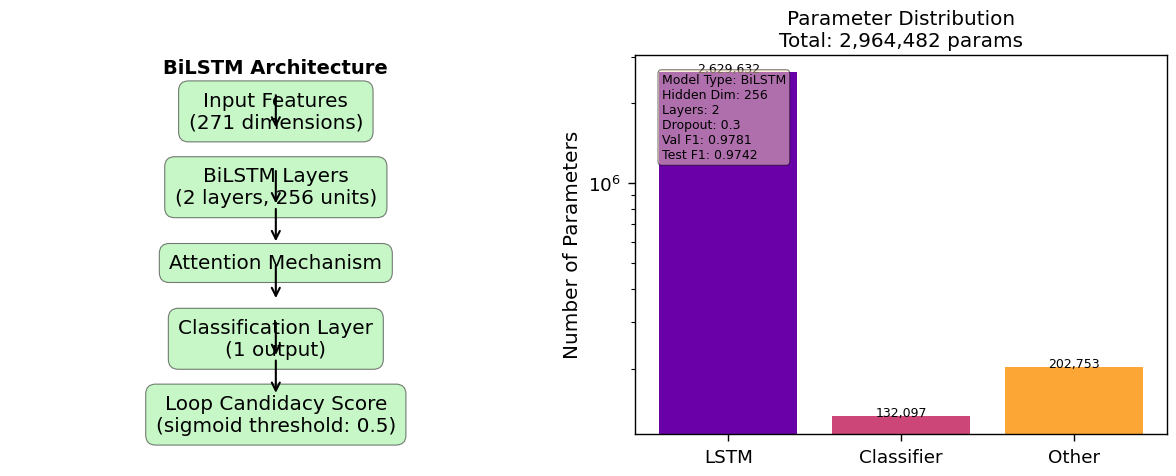

BiLSTM Training and Validation Metrics:


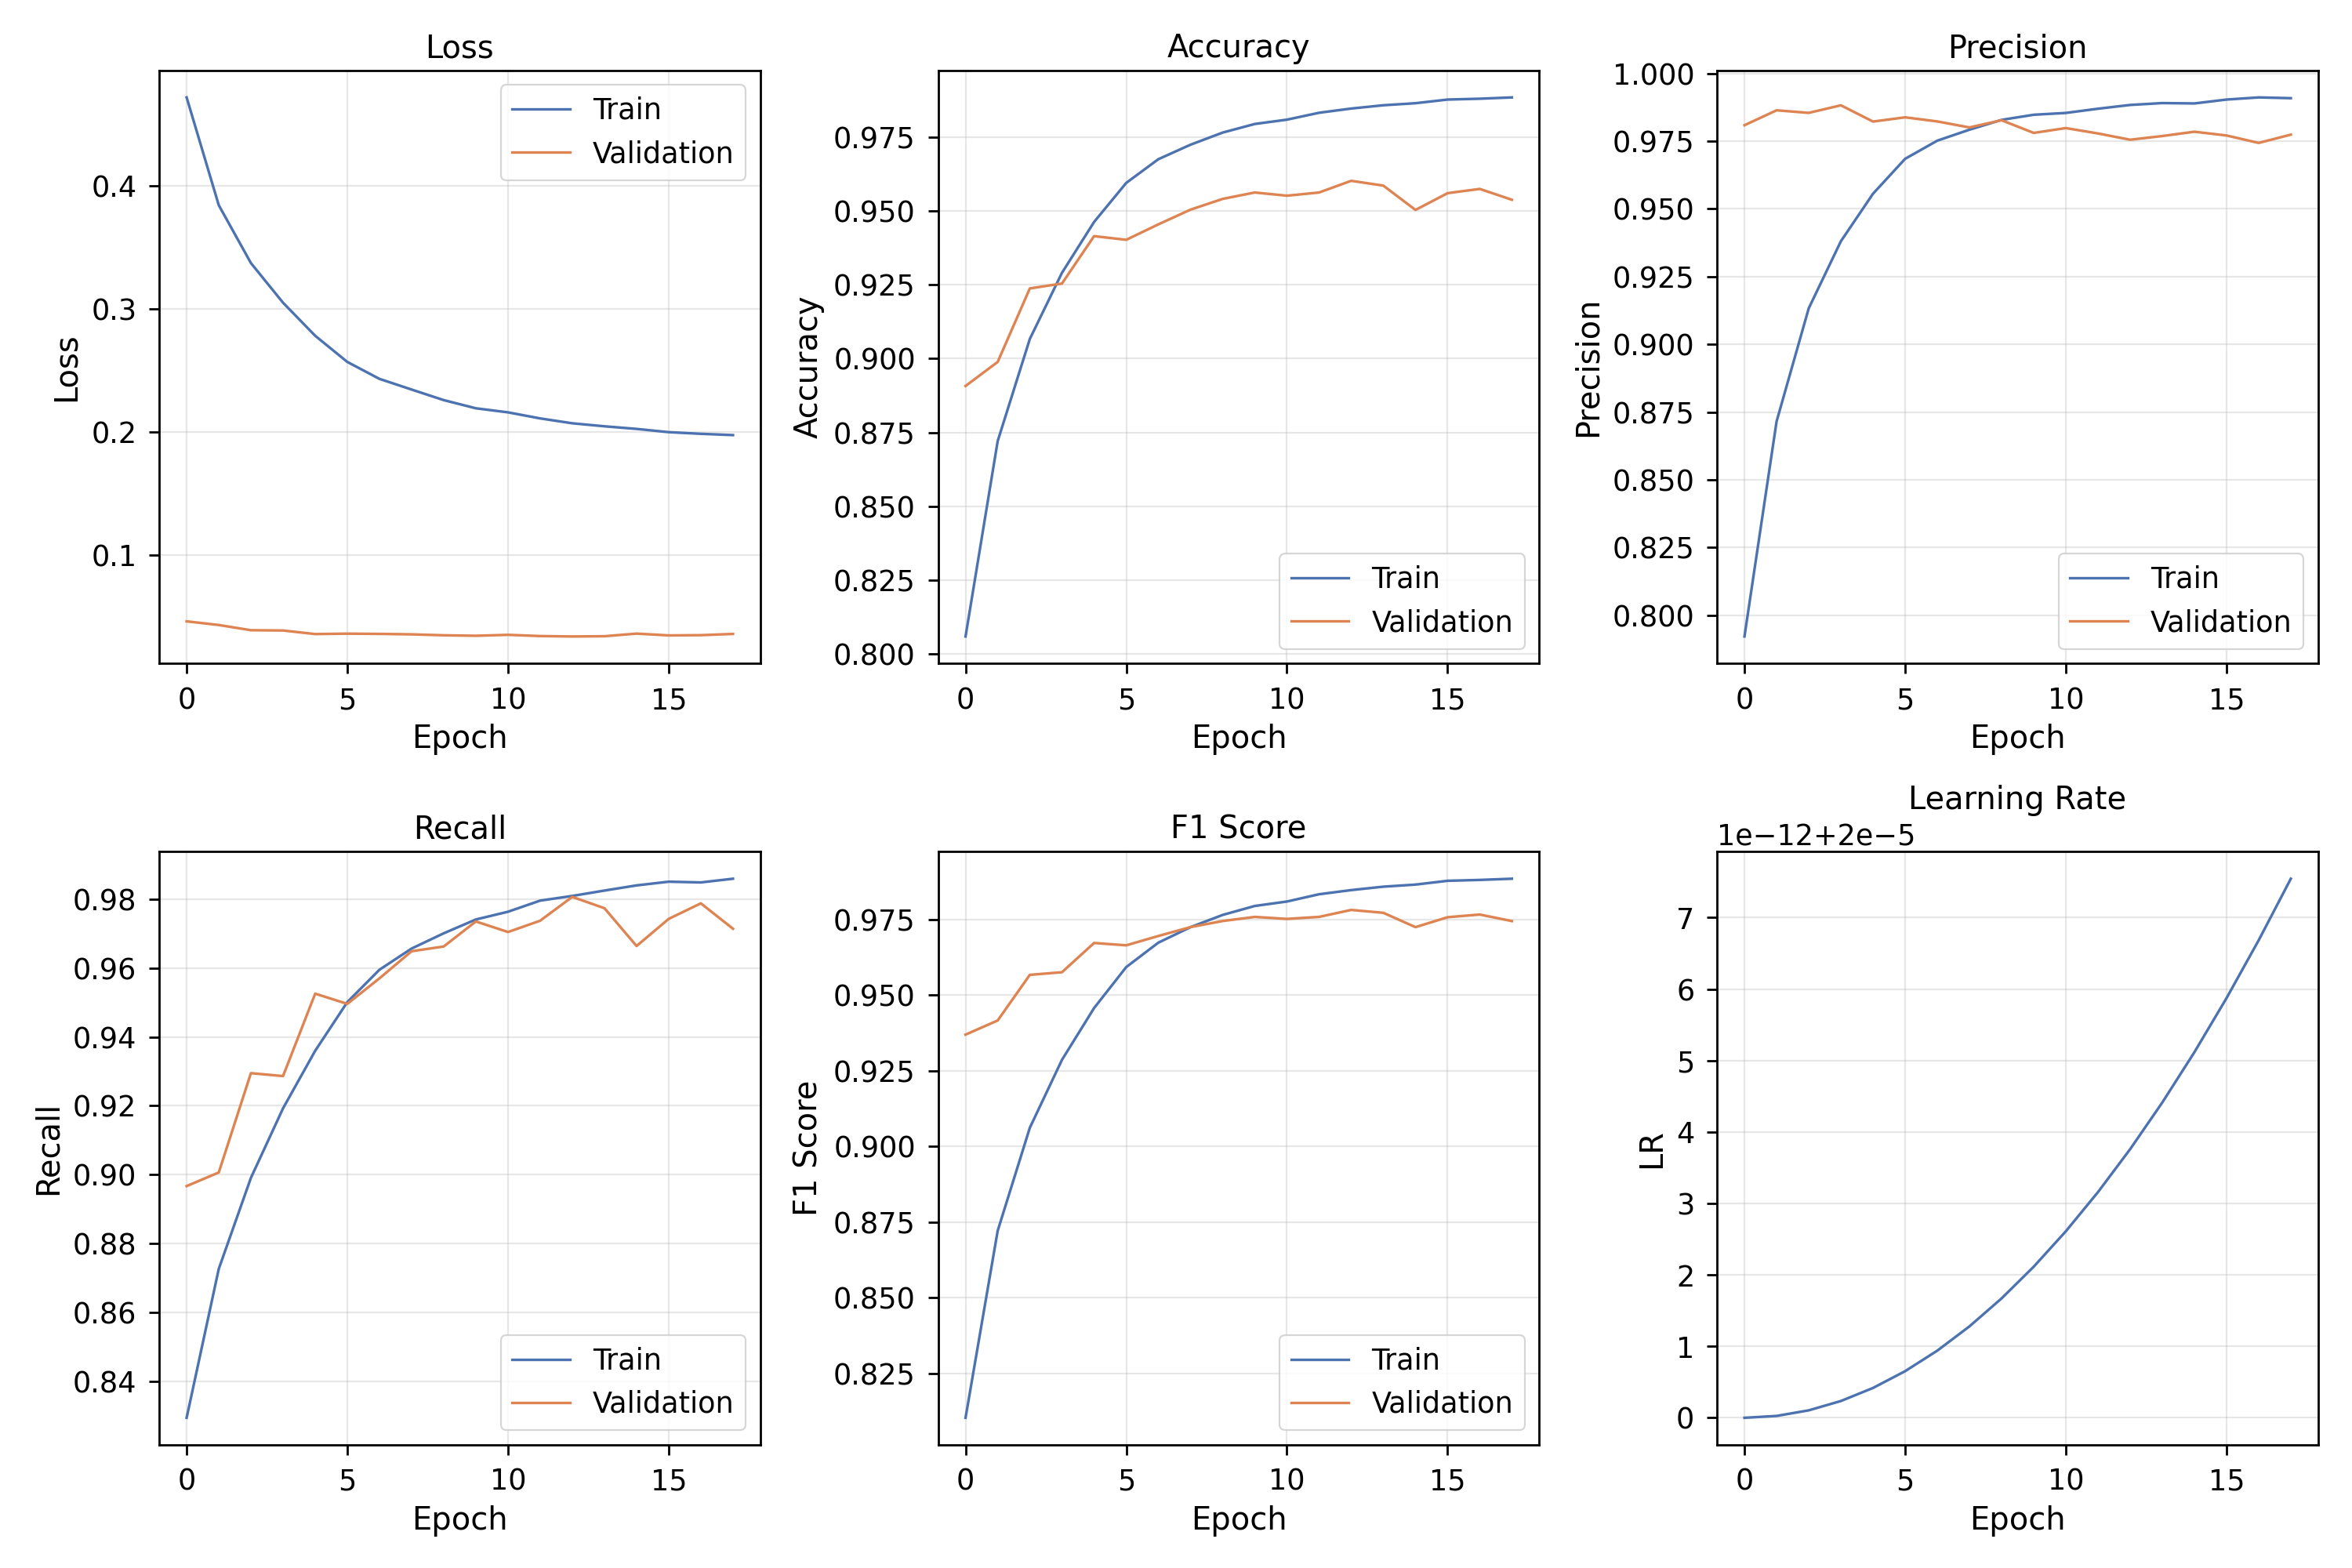

No confusion matrix file found and couldn't generate a new one


In [122]:
def visualize_bilstm_architecture(results_dir="/content/drive/MyDrive/DL4AM_datasets/checkpoints/bilstm_optimized_20250429_110556/search_20250429_110559",
                                 best_run_id="BiLSTM_2_20250429_110559"):
    """Visualize BiLSTM model architecture and parameters."""

    # Load model config
    config_path = os.path.join(results_dir, best_run_id, "config.json")

    try:
        with open(config_path, 'r') as f:
            config = json.load(f)
    except:
        # Fallback to recommendation file
        config_path = os.path.join(results_dir, "final_recommendation.json")
        with open(config_path, 'r') as f:
            config = json.load(f)

    # Create model instance from config
    model_type = config.get('model_type', 'BiLSTM')
    input_dim = config.get('input_dim', 271)  # Default from the groove dataset

    if model_type == 'BiLSTM':
        model = BiLSTMLoopClassifier(
            input_dim=input_dim,
            hidden_dim=config.get('hidden_dim', 256),
            num_layers=config.get('num_layers', 2),
            dropout=config.get('dropout', 0.3)
        )
    else:  # LSTMAttention
        model = LSTMWithAttention(
            input_dim=input_dim,
            hidden_dim=config.get('hidden_dim', 256),
            num_layers=config.get('num_layers', 2),
            num_heads=config.get('num_heads', 4),
            dropout=config.get('dropout', 0.3),
            bidirectional=True
        )

    # Count parameters by component
    total_params = sum(p.numel() for p in model.parameters())

    # Count LSTM parameters
    lstm_params = sum(p.numel() for name, p in model.named_parameters() if 'lstm' in name.lower())

    # Count classifier parameters
    classifier_params = sum(p.numel() for name, p in model.named_parameters() if 'classifier' in name.lower())

    # For LSTMAttention model, count attention parameters
    if model_type == 'LSTMAttention':
        attention_params = sum(p.numel() for name, p in model.named_parameters()
                              if 'attention' in name.lower() or 'self_attention' in name.lower()
                              or 'ffn' in name.lower() or 'norm' in name.lower())
        other_params = total_params - lstm_params - classifier_params - attention_params
    else:
        attention_params = 0
        other_params = total_params - lstm_params - classifier_params

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Architecture diagram
    ax1.axis('off')
    ax1.text(0.5, 0.95, f"{model_type} Architecture", ha='center', fontsize=14, fontweight='bold')

    # Draw boxes for components
    box_props = dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.5)
    ax1.text(0.5, 0.85, f"Input Features\n({input_dim} dimensions)", ha='center', va='center', bbox=box_props)

    if model_type == 'BiLSTM':
        ax1.text(0.5, 0.65, f"BiLSTM Layers\n({config.get('num_layers', 2)} layers, {config.get('hidden_dim', 256)} units)",
                ha='center', va='center', bbox=box_props)
        ax1.text(0.5, 0.45, f"Attention Mechanism", ha='center', va='center', bbox=box_props)
        ax1.text(0.5, 0.25, f"Classification Layer\n(1 output)", ha='center', va='center', bbox=box_props)
    else:  # LSTMAttention
        ax1.text(0.5, 0.70, f"BiLSTM Layers\n({config.get('num_layers', 2)} layers, {config.get('hidden_dim', 256)} units)",
                ha='center', va='center', bbox=box_props)
        ax1.text(0.5, 0.55, f"Multi-Head Attention\n({config.get('num_heads', 4)} heads)",
                ha='center', va='center', bbox=box_props)
        ax1.text(0.5, 0.40, f"Feed-Forward Network", ha='center', va='center', bbox=box_props)
        ax1.text(0.5, 0.25, f"Pooling & Classification\n(1 output)", ha='center', va='center', bbox=box_props)

    ax1.text(0.5, 0.05, f"Loop Candidacy Score\n(sigmoid threshold: 0.5)", ha='center', va='center', bbox=box_props)

    # Add arrows
    arrow_props = dict(arrowstyle='->', lw=1.5)
    ax1.annotate('', xy=(0.5, 0.8), xytext=(0.5, 0.9), arrowprops=arrow_props)
    ax1.annotate('', xy=(0.5, 0.6), xytext=(0.5, 0.7), arrowprops=arrow_props)
    ax1.annotate('', xy=(0.5, 0.5), xytext=(0.5, 0.6), arrowprops=arrow_props)
    ax1.annotate('', xy=(0.5, 0.35), xytext=(0.5, 0.45), arrowprops=arrow_props)
    ax1.annotate('', xy=(0.5, 0.2), xytext=(0.5, 0.3), arrowprops=arrow_props)
    ax1.annotate('', xy=(0.5, 0.1), xytext=(0.5, 0.2), arrowprops=arrow_props)

    # Plot 2: Parameters breakdown
    if model_type == 'BiLSTM':
        components = ['LSTM', 'Classifier', 'Other']
        params = [lstm_params, classifier_params, other_params]
    else:  # LSTMAttention
        components = ['LSTM', 'Attention', 'Classifier', 'Other']
        params = [lstm_params, attention_params, classifier_params, other_params]

    # Create color palette
    colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(components)))

    ax2.bar(components, params, color=colors)
    ax2.set_title(f"Parameter Distribution\nTotal: {total_params:,} params")
    ax2.set_ylabel("Number of Parameters")
    ax2.set_yscale('log')  # Log scale for better visibility

    # Add parameter counts as text on bars
    for i, v in enumerate(params):
        if v > 0:  # Only add text if there are parameters
            ax2.text(i, v + 0.1, f"{v:,}", ha='center', rotation=0, fontsize=9)

    # Add hyperparameters and metrics as text box
    textstr = '\n'.join((
        f"Model Type: {model_type}",
        f"Hidden Dim: {config.get('hidden_dim', 256)}",
        f"Layers: {config.get('num_layers', 2)}",
        f"Dropout: {config.get('dropout', 0.3)}",
        f"Val F1: {config.get('validation_f1', 0.9781):.4f}",
        f"Test F1: {config.get('test_f1', 0.9742):.4f}"
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "bilstm_architecture_visualization.png"), dpi=300)
    plt.show()

    return model


def display_bilstm_training_curves(results_dir="/content/drive/MyDrive/DL4AM_datasets/checkpoints/bilstm_optimized_20250429_110556/search_20250429_110559",
                                  best_run_id="BiLSTM_2_20250429_110559"):
    """Display training curves for the best BiLSTM model."""

    # Path to the training curves
    curves_path = os.path.join(results_dir, best_run_id, "training_curves.png")

    # Display the image in the notebook using IPython.display
    from IPython.display import Image, display

    print("BiLSTM Training and Validation Metrics:")
    if os.path.exists(curves_path):
        display(Image(curves_path))
    else:
        print(f"Training curves not found at {curves_path}")

        # Look for best_model_learning_curves.png as an alternative
        alt_path = os.path.join(results_dir, "best_model_learning_curves.png")
        if os.path.exists(alt_path):
            display(Image(alt_path))
        else:
            print("No training curves found. Check paths or generate visualization.")


def display_bilstm_performance(results_dir="/content/drive/MyDrive/DL4AM_datasets/checkpoints/bilstm_optimized_20250429_110556/search_20250429_110559",
                              best_run_id="BiLSTM_2_20250429_110559"):
    """Fix confusion matrix to show only the best BiLSTM model."""

    # Check for test confusion matrix first (preferred)
    test_cm_path = os.path.join(results_dir, best_run_id, "test_confusion_matrix.png")
    val_cm_path = os.path.join(results_dir, best_run_id, "confusion_matrix.png")
    fixed_cm_path = os.path.join(results_dir, best_run_id, "confusion_matrix_fixed.png")

    # If neither exists, try to generate from test_results.json
    test_results_path = os.path.join(results_dir, best_run_id, "test_results.json")

    if os.path.exists(test_results_path):
        # Load test results
        with open(test_results_path, 'r') as f:
            test_results = json.load(f)

        # Check if y_true and y_pred exist
        if 'y_true' in test_results and 'y_pred' in test_results:
            # Convert to numpy arrays if needed
            y_true = np.array(test_results['y_true']) if isinstance(test_results['y_true'], list) else test_results['y_true']
            y_pred = np.array(test_results['y_pred']) if isinstance(test_results['y_pred'], list) else test_results['y_pred']

            # Generate confusion matrix
            cm = confusion_matrix(y_true, y_pred)

            plt.figure(figsize=(10, 8))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title(f'Confusion Matrix - Best BiLSTM Model\n{best_run_id}', fontsize=16, fontweight='bold')
            plt.colorbar()

            classes = ['Non-Loop', 'Loop']
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, fontsize=12)
            plt.yticks(tick_marks, classes, fontsize=12)

            # Format the grid
            thresh = cm.max() / 2
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black",
                         fontsize=14, fontweight='bold')

            plt.tight_layout()
            plt.ylabel('True Label', fontsize=14)
            plt.xlabel('Predicted Label', fontsize=14)

            # Calculate metrics
            tn, fp, fn, tp = cm.ravel()
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            # Add metrics text
            metrics_text = f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}"
            plt.figtext(0.5, 0.01, metrics_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

            plt.savefig(fixed_cm_path, dpi=300, bbox_inches='tight')
            print(f"Generated fixed confusion matrix at {fixed_cm_path}")

            # Display the fixed confusion matrix
            from IPython.display import Image, display
            display(Image(fixed_cm_path))
            return

    # If we can't generate a new one, check if either existing matrix is correct
    from IPython.display import Image, display

    if os.path.exists(test_cm_path):
        print("Using existing test confusion matrix")
        display(Image(test_cm_path))
    elif os.path.exists(val_cm_path):
        print("Using existing validation confusion matrix")
        display(Image(val_cm_path))
    else:
        print("No confusion matrix file found and couldn't generate a new one")

best_bilstm_model = visualize_bilstm_architecture()
display_bilstm_training_curves()
display_bilstm_performance()

### 5.3 CVAE + BiLSTM Performance Comparison

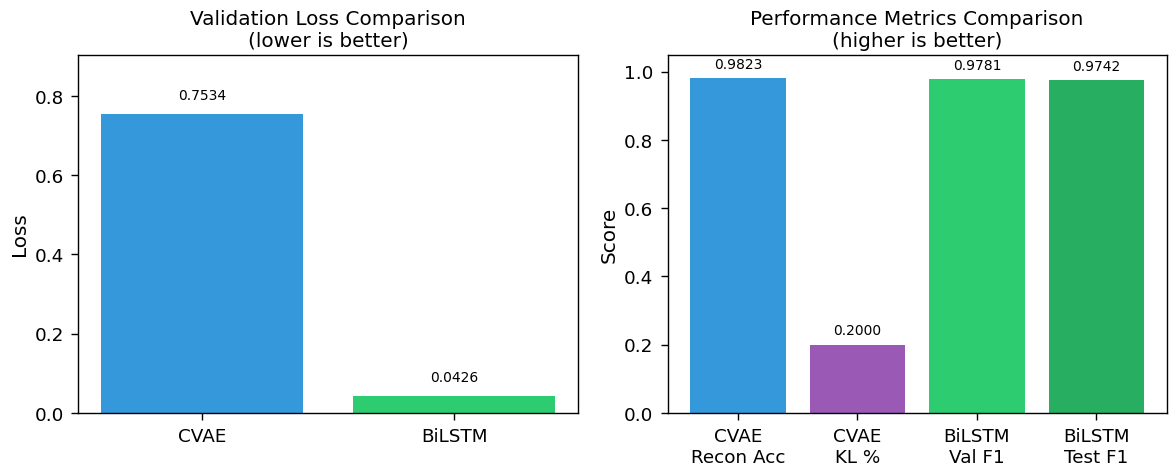

In [98]:
def compare_model_performance():
    """Create a combined visualization comparing CVAE and BiLSTM performance."""

    # Define model performance metrics
    models = ['CVAE', 'BiLSTM']

    # Metrics (based on your provided summary)
    loss_metrics = {
        'CVAE': 0.753447,  # Best validation loss
        'BiLSTM': 0.0426   # Estimated validation loss from F1 score
    }

    classification_metrics = {
        'CVAE_recon': 0.9823,  # Estimated reconstruction accuracy based on loss
        'CVAE_kl': 0.2,        # KL divergence contribution percentage
        'BiLSTM_val': 0.9781,  # Validation F1
        'BiLSTM_test': 0.9742  # Test F1
    }

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Loss comparison (lower is better)
    ax1.bar(models, [loss_metrics[model] for model in models], color=['#3498db', '#2ecc71'])
    ax1.set_title("Validation Loss Comparison\n(lower is better)")
    ax1.set_ylabel("Loss")

    # Add value labels
    for i, model in enumerate(models):
        ax1.text(i, loss_metrics[model] + 0.03, f"{loss_metrics[model]:.4f}",
                ha='center', va='bottom', fontsize=10)

    # Set y-limits to emphasize difference
    ax1.set_ylim(0, max(loss_metrics.values()) * 1.2)

    # Plot 2: F1/Accuracy comparison (higher is better)
    metric_labels = ['CVAE\nRecon Acc', 'CVAE\nKL %', 'BiLSTM\nVal F1', 'BiLSTM\nTest F1']
    metric_values = [classification_metrics[key] for key in ['CVAE_recon', 'CVAE_kl', 'BiLSTM_val', 'BiLSTM_test']]

    colors = ['#3498db', '#9b59b6', '#2ecc71', '#27ae60']
    bars = ax2.bar(metric_labels, metric_values, color=colors)
    ax2.set_title("Performance Metrics Comparison\n(higher is better)")
    ax2.set_ylabel("Score")

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    # Set y-limits
    ax2.set_ylim(0, 1.05)

    plt.tight_layout()
    plt.savefig("model_performance_comparison.png", dpi=300)
    plt.show()

compare_model_performance()

### 5.3 TODO: Quantitative Performance Metrics

## Model Combination

In [94]:
def visualize_fma_sample(dataset, index=0, save_file=None):
    """Visualize a sample spectrogram from the FMA dataset."""
    # Load sample from dataset
    sample = dataset[index]
    spectrogram = sample['spectrogram']  # Shape: [1, 128, 860]

    # Convert to numpy for plotting
    spec_np = spectrogram.squeeze().numpy()  # Shape: [128, 860]

    # Display the spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(spec_np, origin='lower', aspect='auto', cmap='magma')
    plt.title("Sample Log-Mel Spectrogram from FMADataset")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Bands")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

    # Optionally save tensor for upload
    if save_file:
        torch.save(spectrogram, save_file)
        print(f"Saved {save_file} for upload.")

    return sample


visualize_fma_sample(fma_dataset, index=0, save_file="dummy_spec.pt")

NameError: name 'fma_dataset' is not defined